In [28]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Sklearn and TensorFlow related imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# CatBoost and TensorFlow Decis
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from catboost import CatBoostRegressor

from sklearn.preprocessing import OrdinalEncoder  # For tree-based models
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression

import optuna
import json

In [29]:
#Load datasets
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


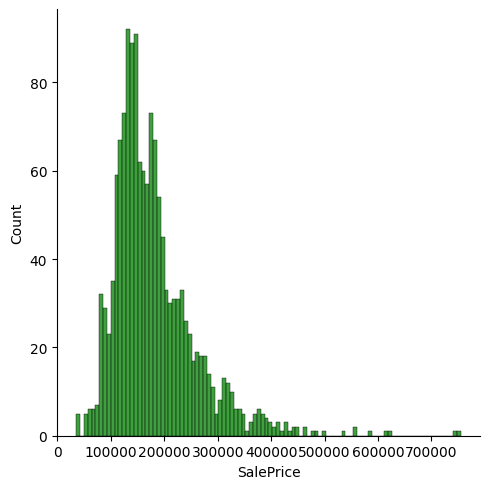

In [30]:
print(df.SalePrice.describe())

sns.displot(df["SalePrice"], color= 'g', bins = 100)

In [31]:
df_num = df.select_dtypes(include=['float64','int64'])
df_num.head()

Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   
2          2002       162.0         486  ...           0           42   
3          1970         0.0         216  ...           0           35   
4          2000       350.0         655  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0              0          0            0         0        0       2    2008   
1              0          0            0         0        0       5    2007   
2              0          0            0         0        0       9    2008   
3            272          0            0         0        0       2    2006   
4              0          0            0         0        0      12    2008   

   SalePrice  
0     208500  
1     181500  
2     223500  
3     140000  
4     250000  

[5 rows x 38 columns]

array([[<AxesSubplot: title={'center': 'MSSubClass'}>,
        <AxesSubplot: title={'center': 'LotFrontage'}>,
        <AxesSubplot: title={'center': 'LotArea'}>,
        <AxesSubplot: title={'center': 'OverallQual'}>,
        <AxesSubplot: title={'center': 'OverallCond'}>,
        <AxesSubplot: title={'center': 'YearBuilt'}>],
       [<AxesSubplot: title={'center': 'YearRemodAdd'}>,
        <AxesSubplot: title={'center': 'MasVnrArea'}>,
        <AxesSubplot: title={'center': 'BsmtFinSF1'}>,
        <AxesSubplot: title={'center': 'BsmtFinSF2'}>,
        <AxesSubplot: title={'center': 'BsmtUnfSF'}>,
        <AxesSubplot: title={'center': 'TotalBsmtSF'}>],
       [<AxesSubplot: title={'center': '1stFlrSF'}>,
        <AxesSubplot: title={'center': '2ndFlrSF'}>,
        <AxesSubplot: title={'center': 'LowQualFinSF'}>,
        <AxesSubplot: title={'center': 'GrLivArea'}>,
        <AxesSubplot: title={'center': 'BsmtFullBath'}>,
        <AxesSubplot: title={'center': 'BsmtHalfBath'}>],
     

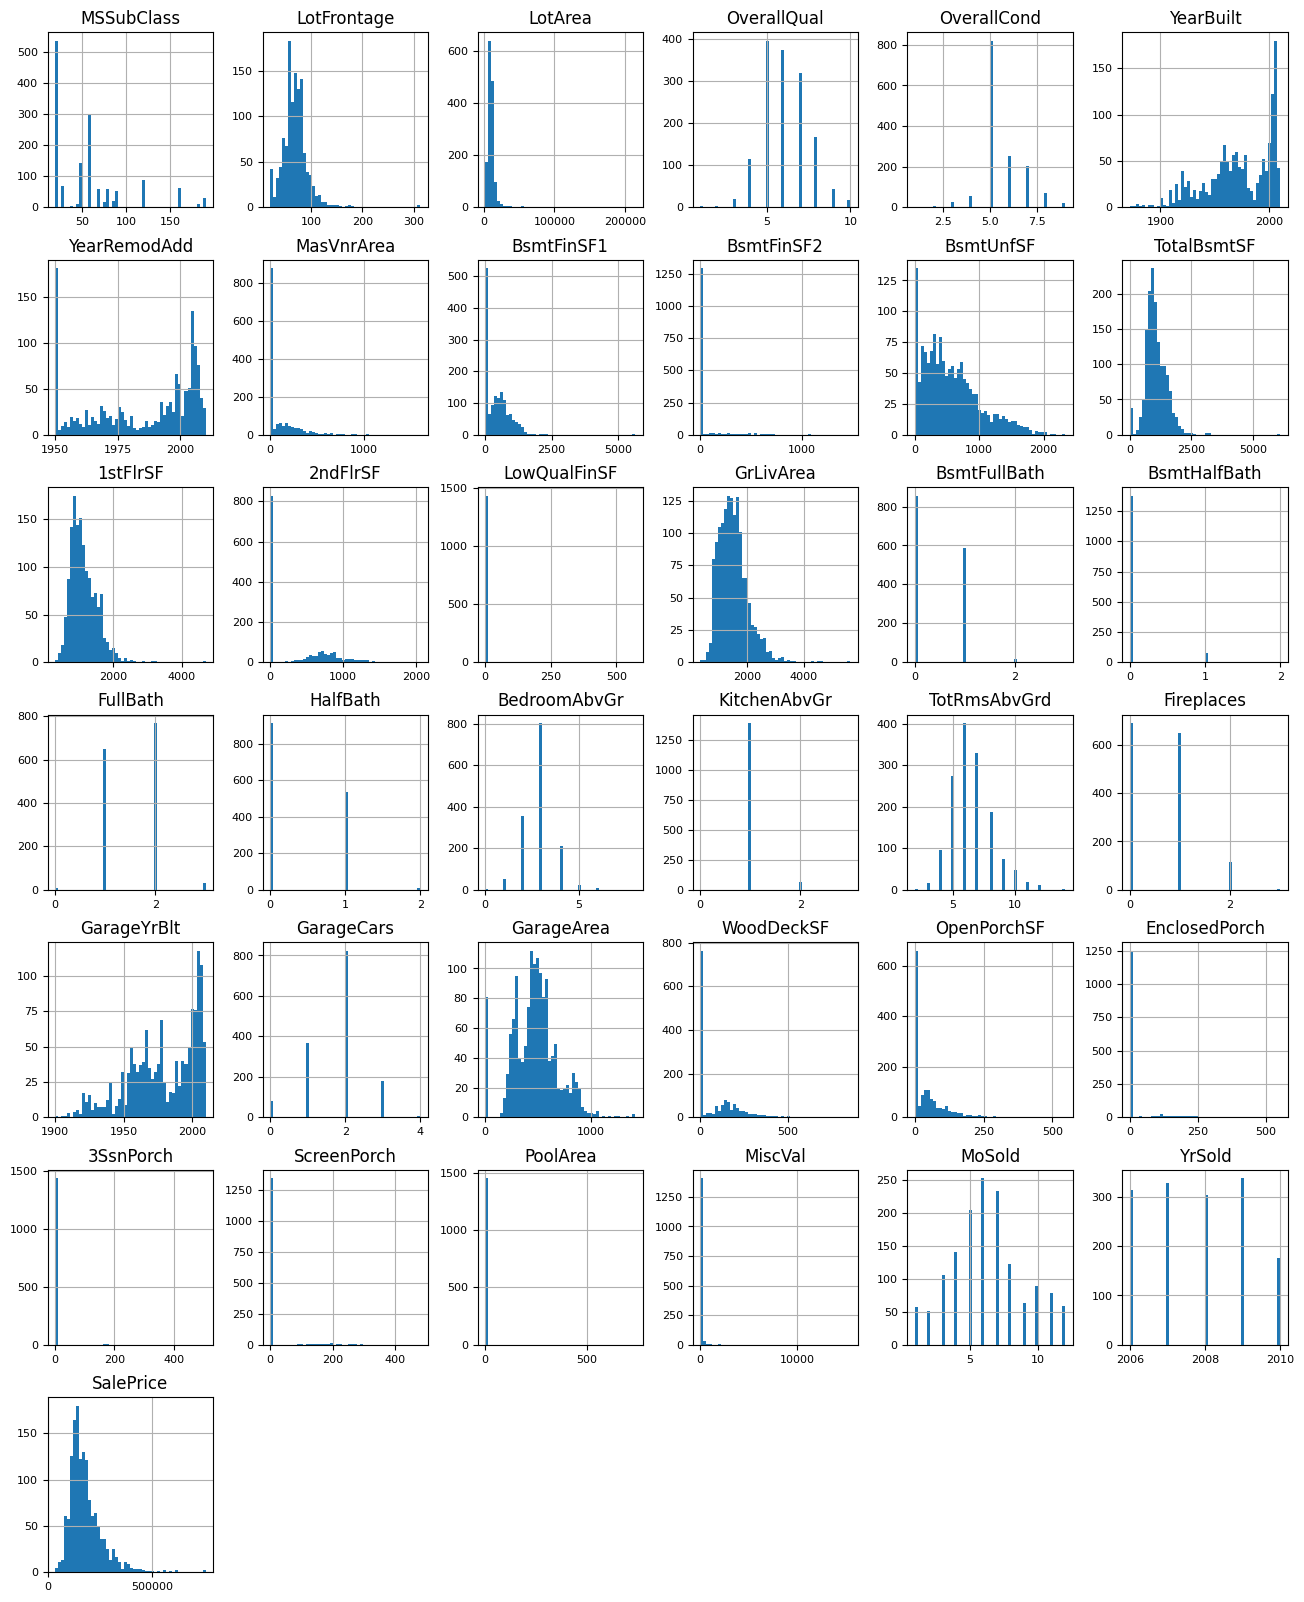

In [32]:
df_num = df_num.drop(columns = ['Id'])
df_num.hist(figsize=(16,20), bins =50, xlabelsize =8, ylabelsize=8)


--------Start of df2 transformations--------

In [33]:
#Encode categ
def encode_categ(df):
    for col in df.select_dtypes(include=["object", "category"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

def fillnan(X):
                    # Check if X is a DataFrame, and apply fillna
    if isinstance(X, pd.DataFrame):
        return X.fillna("nan")
    else:
        raise TypeError("Input must be a pandas DataFrame or a numpy array")
                # If the data isn't a DataFrame, just apply fillna to numpy array
    
#Calculate mutual information
def mutualInfo(df):
    # Calculate mutual information
    mi_scores = mutual_info_regression(df.drop(columns = ["SalePrice"]), df.SalePrice, random_state=42)
    # Create a results dataframe
    mi_df = pd.DataFrame({'Feature': df.drop(columns = ['SalePrice']).columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False)

    #Plot mutual Info.
    plt.figure(figsize=(10, 6))
    sns.barplot(x='MI Score', y='Feature', data=mi_df.head(20), palette='viridis')
    plt.title('Top 20 Features by Mutual Information Score')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Feature')
    plt.show()

In [34]:
#Apply feature engineering on df2 
df2 = df.copy()
df2 = fillnan(df2)
df2 = encode_categ(df2)

df2['log_lotArea'] = np.log1p(df['LotArea'])

df2["GrLivArea_Neigh"] = df2.GrLivArea * df2['Neighborhood']
df2["OverallQual_Neigh"] = df2.OverallQual * df2['Neighborhood']
df2["CarSpace"] = df2['GarageArea'] * df2['GarageCars']
df2['CombinedCondition'] = df2['Condition1'].astype(str) + "_" + df2['Condition2'].astype(str)

df2["LivLotRatio"] = df2.GrLivArea / df2.LotArea
df2["Spaciousness"] = (df2["1stFlrSF"]+df2["2ndFlrSF"])/df2.TotRmsAbvGrd
df2["TotalOutsideSF"] = df2.WoodDeckSF + df2.OpenPorchSF+df2.EnclosedPorch+df2["3SsnPorch"]+df2.ScreenPorch


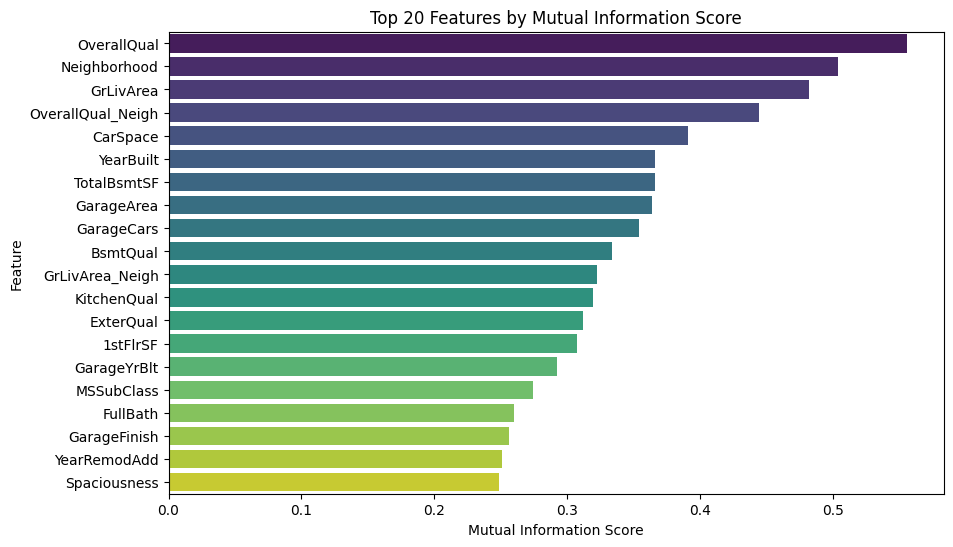

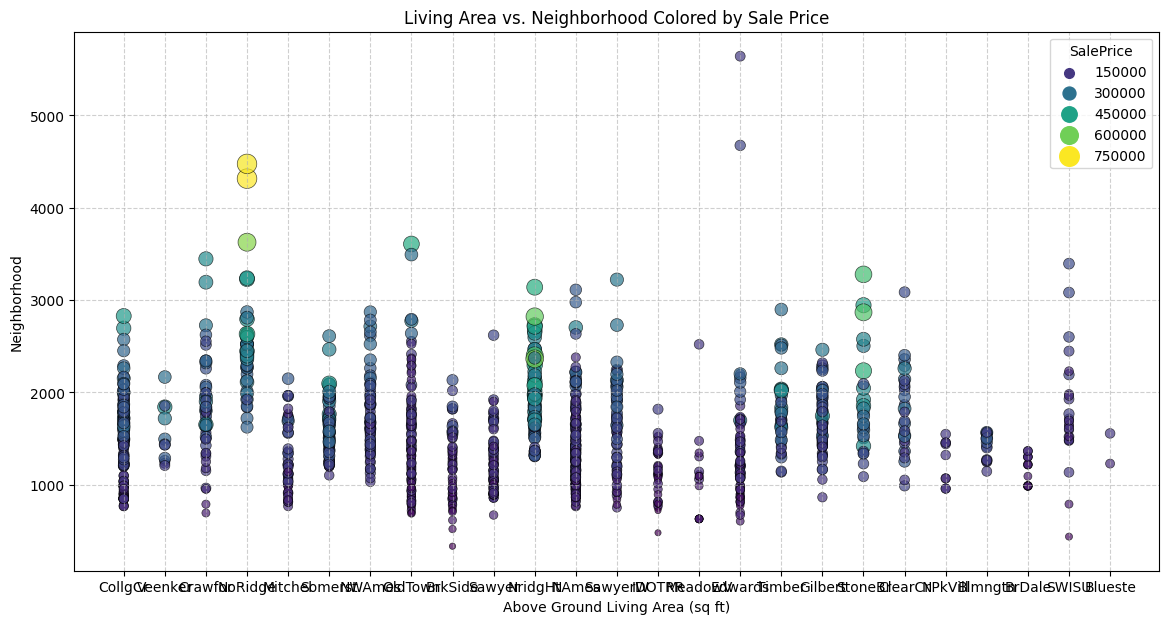

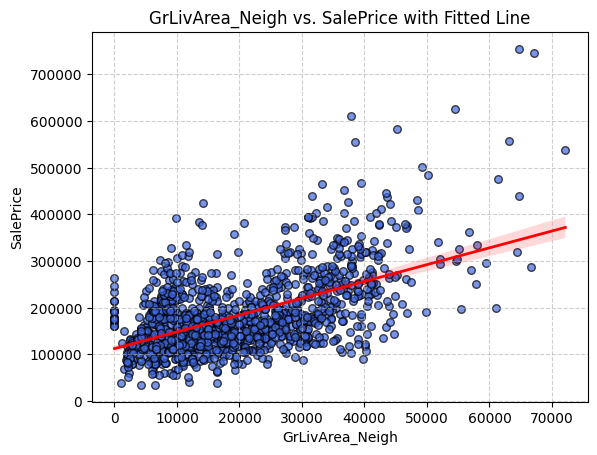

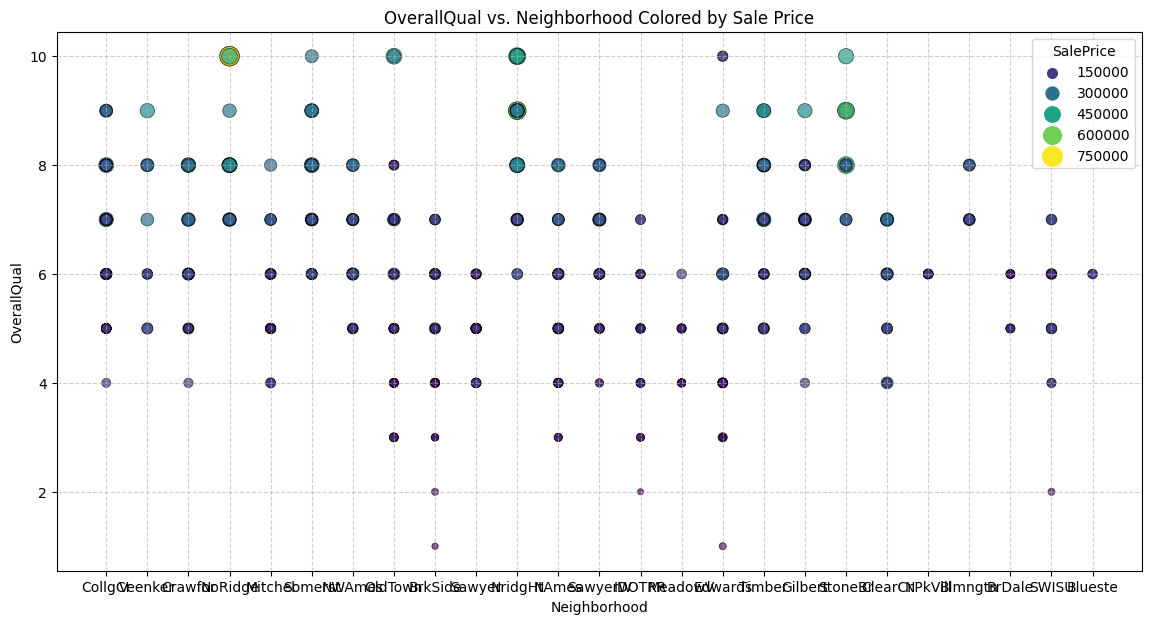

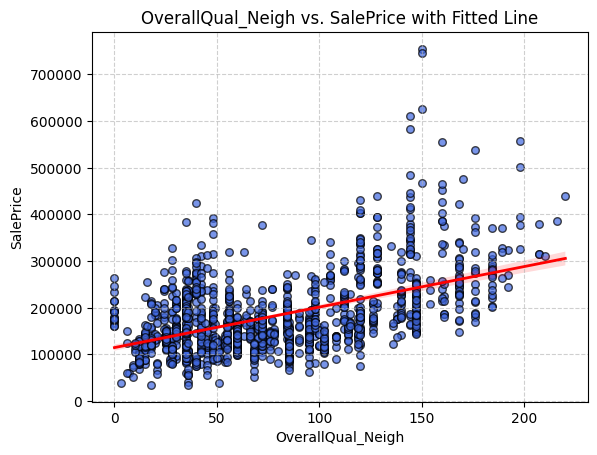

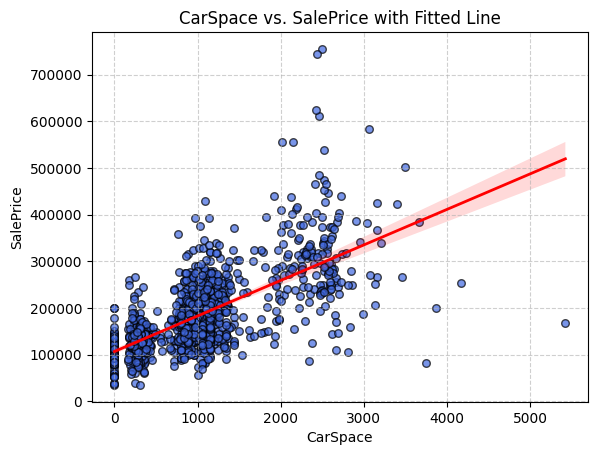

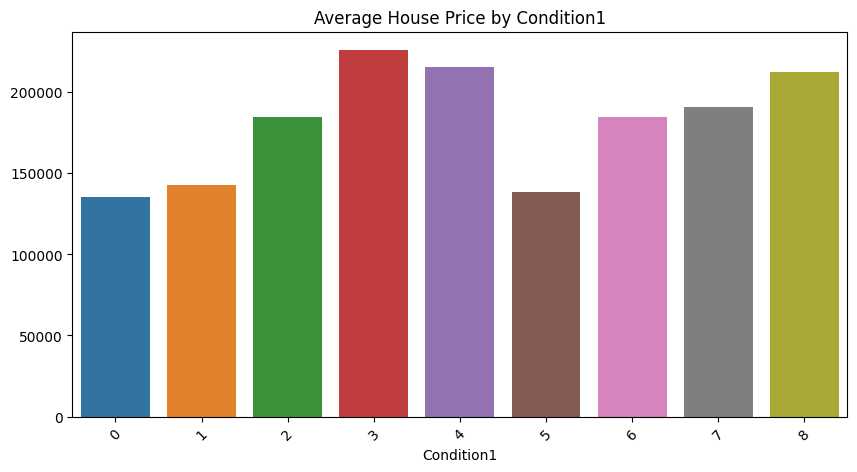

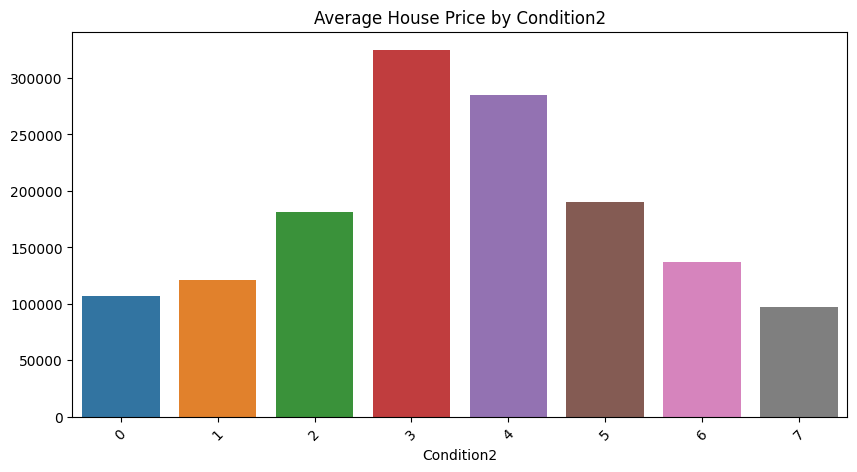

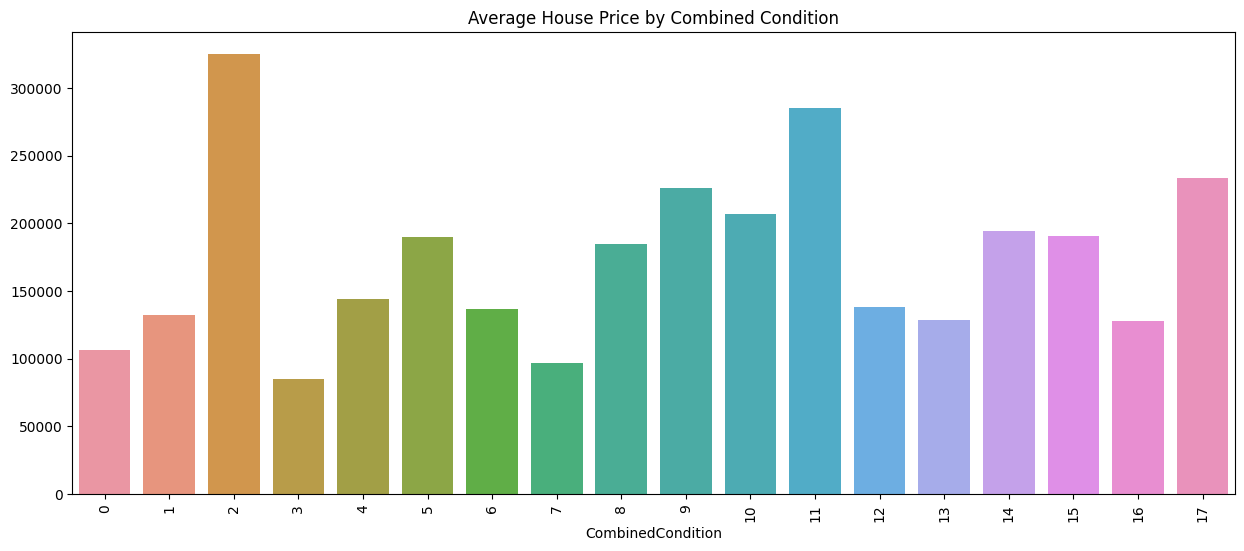

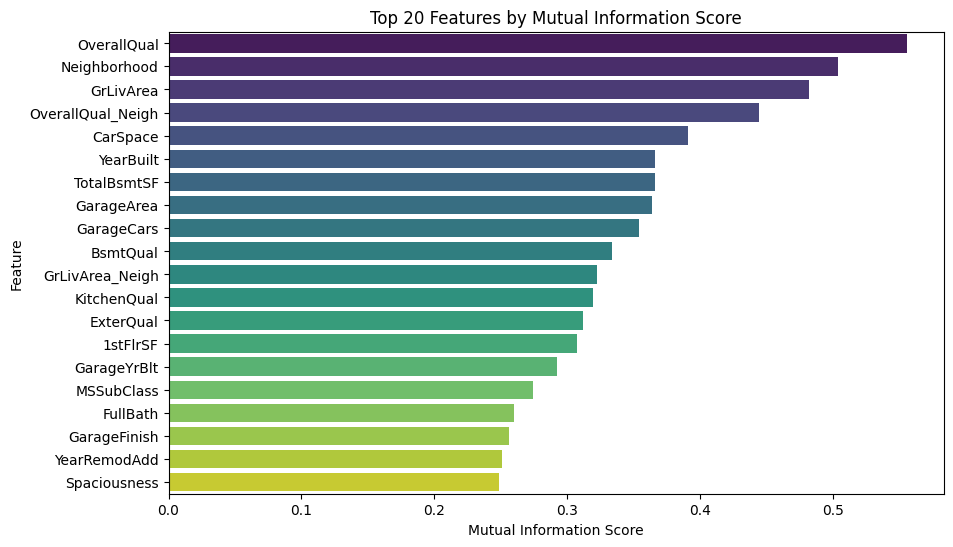

In [72]:
#Call encode categ + Create df2.

mutualInfo(df2)

#GRLivArea + Neighborhood VS SalePrice
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df, 
    x='Neighborhood', 
    y='GrLivArea', 
    hue='SalePrice', 
    palette='viridis', 
    size='SalePrice',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k'
)

plt.title('Living Area vs. Neighborhood Colored by Sale Price')
plt.xlabel('Above Ground Living Area (sq ft)')
plt.ylabel('Neighborhood')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Scatterplot with regression line
sns.regplot(
    data=df2, 
    x='GrLivArea_Neigh', 
    y='SalePrice', 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  # Scatter customizations
    line_kws={'color': 'red', 'linewidth': 2},  # Regression line customizations
    color='royalblue',  # Color of scatter points
    logistic=False,  # We are fitting a linear regression, not logistic
)

# Adding labels and title
plt.title('GrLivArea_Neigh vs. SalePrice with Fitted Line')
plt.xlabel('GrLivArea_Neigh')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


#OverallQuality + Neighborhood VS SalePrice
plt.figure(figsize=(14, 7))
sns.scatterplot(
    data=df, 
    x='Neighborhood', 
    y='OverallQual', 
    hue='SalePrice', 
    palette='viridis', 
    size='SalePrice',
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='k'
)

plt.title('OverallQual vs. Neighborhood Colored by Sale Price')
plt.xlabel('Neighborhood')
plt.ylabel('OverallQual')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Scatterplot with regression line
sns.regplot(
    data=df2, 
    x='OverallQual_Neigh', 
    y='SalePrice', 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  # Scatter customizations
    line_kws={'color': 'red', 'linewidth': 2},  # Regression line customizations
    color='royalblue',  # Color of scatter points
    logistic=False,  # We are fitting a linear regression, not logistic
)

# Adding labels and title
plt.title('OverallQual_Neigh vs. SalePrice with Fitted Line')
plt.xlabel('OverallQual_Neigh')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()



# Scatterplot with regression line
sns.regplot(
    data=df2, 
    x='CarSpace', 
    y='SalePrice', 
    scatter_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'k'},  # Scatter customizations
    line_kws={'color': 'red', 'linewidth': 2},  # Regression line customizations
    color='royalblue',  # Color of scatter points
    logistic=False,  # We are fitting a linear regression, not logistic
)

# Adding labels and title
plt.title('CarSpace vs. SalePrice with Fitted Line')
plt.xlabel('CarSpace')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

df2 = fillnan(df2)

# Analyze Condition1
cond1_prices = df2.groupby('Condition1')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cond1_prices.index, y=cond1_prices.values)
plt.title('Average House Price by Condition1')
plt.xticks(rotation=45)
plt.show()

# Analyze Condition2
cond2_prices = df2.groupby('Condition2')['SalePrice'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=cond2_prices.index, y=cond2_prices.values)
plt.title('Average House Price by Condition2')
plt.xticks(rotation=45)
plt.show()

# Combine both conditions
combined_prices = df2.groupby('CombinedCondition')['SalePrice'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(x=combined_prices.index, y=combined_prices.values)
plt.title('Average House Price by Combined Condition')
plt.xticks(rotation=90)
plt.show()

mutualInfo(df2)

------End of df2 transformations-----

------Start working on df3-----------

In [36]:
df3 = df.copy()

In [37]:
#Function to get count of missing values in each column

def get_cols_with_missing_values(DataFrame):
    missing_na_columns=(DataFrame.isnull().sum())
    return missing_na_columns[missing_na_columns > 0]

In [38]:
#Handling missing values:
#Get a list of all the categorical features that have the keyword 'Qual' OR 'Cond' OR 'Qu' OR 'QC' in the feature name
feature_rating_Qual = [col for col in df3.columns if 'Qual' in col and df3[col].dtypes=='object']
feature_rating_Cond = [col for col in df3.columns if 'Cond' in col and col not in ['Condition1', 'Condition2', 'SaleCondition'] and df3[col].dtypes=='object']
feature_rating_Qu = [col for col in df3.columns if 'Qu' in col and df3[col].dtypes=='object' and col not in feature_rating_Qual]
feature_rating_QC = [col for col in df3.columns if 'QC' in col and df3[col].dtypes=='object']

cat_feature_with_rating = feature_rating_Qual + feature_rating_Cond + feature_rating_Qu + feature_rating_QC
for x in cat_feature_with_rating:
    print(x)

#Categorical features who have NA as a correct value

cat_feature_with_legit_na = ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature']
ordinal_cat_features = cat_feature_with_rating + cat_feature_with_legit_na
df3[ordinal_cat_features].head()

#On checking the data description, Missing is valid in some categorical

#Handling Missing Values in Ordinal Categorical features by replacing them with 'Missing' keyword

df3[ordinal_cat_features] = df3[ordinal_cat_features].fillna("Missing")
#Making sure the missing values have been handled
print(get_cols_with_missing_values(df3[ordinal_cat_features]))

#Imputing the mode into the rest of categorical features
categorical_cols=[cname for cname in df3.columns if df3[cname].dtypes=='object' and cname!='ind']
remaining_cat_cols = [cname for cname in categorical_cols if cname not in ordinal_cat_features]
#Handling Missing Values in Categorical features by replacing them with the feature mode value
for col in remaining_cat_cols:
    df3[col] = df3[col].fillna(df3[col].mode()[0])


#Handling Missing Values in Numerical features by replacing them with Mean value
numerical_cols=[cname for cname in df3.columns if df3[cname].dtypes!='object']
df3[numerical_cols]=df3[numerical_cols].fillna(df3[numerical_cols].mean())
#Select categorical columns with low cardinality
categorical_cols=[cname for cname in df3.columns if df3[cname].dtypes=='object' and df3[cname].nunique()<10]
numerical_cols=[cname for cname in df3.columns if df3[cname].dtypes!='object']

# Keep selected columns only
my_cols = numerical_cols + categorical_cols

df3 = df3[my_cols].copy()

ExterQual
BsmtQual
KitchenQual
GarageQual
ExterCond
BsmtCond
GarageCond
FireplaceQu
HeatingQC
PoolQC
Series([], dtype: int64)


In [39]:
#Drop 'Id' feature
df3.drop('Id', axis=1, inplace=True)

In [40]:
#Dealing wiht year, bathroom number and square footage.
#Features with year
df3['GarageYrBlt'] = df3['GarageYrBlt'].astype('int')
df3['GarageYrBlt'] = df3['YrSold'] - df3['GarageYrBlt']
df3['YearBuilt'] = df3['YrSold'] - df3['YearBuilt']
df3['YearRemodAdd'] = df3['YrSold'] - df3['YearRemodAdd']
df3.drop(["YrSold"], axis=1, inplace=True)
df3.drop(["MoSold"], axis=1, inplace=True)

#Features with square footage
#TotalBsmtSF(Total square feet of basement area) = BsmtFinSF1(Type 1 finished square feet) + BsmtFinSF2(Type 2 finished square feet) + BsmtUnfSF(Unfinished square feet of basement area)
df3.drop(["TotalBsmtSF"], axis=1, inplace=True)
#Basement finished area
df3['BsmtFinSF'] = df3['BsmtFinSF1'] + df3['BsmtFinSF2']
df3.drop(["BsmtFinSF1"], axis=1, inplace=True)
df3.drop(["BsmtFinSF2"], axis=1, inplace=True)
#Total floor square feet
df3['TotalFlrSF'] = df3['1stFlrSF'] + df3['2ndFlrSF']

df3.drop(["1stFlrSF"], axis=1, inplace=True)
df3.drop(["2ndFlrSF"], axis=1, inplace=True)

#Bathroom feature
df3['Total_Bath'] = (df3['FullBath'] 
        + (0.5*df3['HalfBath']) 
        + df3['BsmtFullBath'] 
        + (0.5*df3['BsmtHalfBath']))

df3.drop(["FullBath"], axis=1, inplace=True)
df3.drop(["HalfBath"], axis=1, inplace=True)
df3.drop(["BsmtFullBath"], axis=1, inplace=True)
df3.drop(["BsmtHalfBath"], axis=1, inplace=True)

In [41]:
#Year Remodel add is -1 on row 523. This is the only such value. 
#This was the reason of -inf. Since next we take the log1p = log(x+1). In case of this row it was log(0) which is inf. 
df3.at[523, 'YearRemodAdd'] += 1


In [42]:
#Dealing with skewed data 
numerical_cols = [cname for cname in df3.columns if df3[cname].dtypes!='object' and cname!='SalePrice']
skew_df = pd.DataFrame(numerical_cols, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df3[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

#Apply log1p transformation
for column in skew_df.query("Skewed == True")['Feature'].values:
    df3[column] = np.log1p(df3[column])

In [43]:
#There is one row which contains -inf value in YearRemodAdd
numeric_df = df3.select_dtypes(include=[np.number])
print(np.isinf(numeric_df).any())
problematic_rows = df3[np.isinf(numeric_df).any(axis=1)]
print(problematic_rows)

#Check if this is the case for the initial database
numeric_df = df.select_dtypes(include=[np.number])
print(np.isinf(numeric_df).any())




MSSubClass       False
LotFrontage      False
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea       False
BsmtUnfSF        False
LowQualFinSF     False
GrLivArea        False
BedroomAbvGr     False
KitchenAbvGr     False
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt      False
GarageCars       False
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
SalePrice        False
BsmtFinSF        False
TotalFlrSF       False
Total_Bath       False
dtype: bool
Empty DataFrame
Columns: [MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtUnfSF, LowQualFinSF, GrLivArea, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolAre

------End of df3 transformations--------

In [44]:
#split the dataset
def split_dataset(dataset, test_ratio=0.30):
  np.random.seed(42)
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [45]:
#Defining the models
models = {
    "Logistic Regression": LogisticRegression(),
     "Random Forest": RandomForestClassifier(),
     "Gradient Boosting": GradientBoostingClassifier(),
     "SVM": SVC(),
     "KNN": KNeighborsClassifier(),
     "Decision Tree": DecisionTreeClassifier(),
    "TensorFlow Decision Forest": tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION),
    "Cat Boost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)
}

model_linear = {
    "Logistic Regression": LogisticRegression(),
     "SVM": SVC(),
     "KNN": KNeighborsClassifier()
}
model_tree = {
    "Decision Tree": DecisionTreeClassifier(),
    "TensorFlow Decision Forest": tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION),
    "Cat Boost": CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

model_deep ={}

datasets = {
    "Original Dataset": df,  # Original dataset
}

dataset2 = {
    "Dataset 2": df2, 
}

dataset3 = {
    "Dataset 3":df3
}

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpba6bzosa as temporary training directory
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpojmkk0gh as temporary training directory


In [46]:
# Preprocessing Pipeline
class FillNaN(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
                # Check if X is a DataFrame, and apply fillna
        if isinstance(X, pd.DataFrame):
            return X.fillna("nan")
        else:
            # If the data isn't a DataFrame, just apply fillna to numpy array
            return pd.DataFrame(X).fillna("nan")
        
# Preprocessing Pipeline
def create_preprocessing_pipeline(model_name, categorical_columns, numerical_columns, model_tree =model_tree, model_linear = model_linear):
    if model_name in model_linear:  # For linear models like Logistic Regression, SVM, KNN
        return ColumnTransformer(
            transformers=[
                ('cat', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value="nan")),
                    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))  # OneHot encoding
                ]), categorical_columns),
                ('num', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value=0)),  # Handle missing values
                    ('scaler', StandardScaler())  # Standard scaling for numerical features
                ]), numerical_columns)
            ]
        )
    elif model_name in model_tree:  # For tree-based models like Random Forest, CatBoost
        return ColumnTransformer(
            transformers=[
                ('cat', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value="nan")),  # Handle missing values
                    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Label encoding for categorical features
                ]), categorical_columns),
                ('num', Pipeline(steps=[
                    ('fillna', SimpleImputer(strategy='constant', fill_value=0))  # Handle missing values
                ]), numerical_columns)
            ]
        )
    else:  # For deep learning models
        return "passthrough"  # Deep learning models typically handle preprocessing differently (or not at all)


In [47]:
#Train & Evaluate Models on Multiple Datasets
def train_and_evaluate_models(models_dict, datasets, model_deep=model_deep, tune_models=False):
    results = {}
    best_params = {}

    # Loop through each dataset created (after feature engineering)
    for dataset_name, dataset in datasets.items():

        print(f"\nEvaluating models on dataset: {dataset_name}...")

        X = dataset.drop(columns=["SalePrice"])  
        y = dataset["SalePrice"]  
        
        categorical_columns = X.select_dtypes(include=["object", "category"]).columns.tolist()
        numerical_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Store results for this dataset
        data_results = {}

        # Loop through each model in the dictionary
        for model_name, model in models_dict.items():
            print(f"Training {model_name}...")

            # Check if the model has been tuned already
            if model_name in best_params:
                print(f"Using pre-tuned parameters for {model_name}")
                model.set_params(**best_params[model_name])
            
            # Get the appropriate preprocessing pipeline for the model
            preprocessor = create_preprocessing_pipeline(model_name, categorical_columns, numerical_columns)
            
            if tune_models:
                # Perform hyperparameter tuning for supported models
                if model_name == "Logistic Regression":
                    param_grid = {
                        "C": [0.01, 0.1, 1, 10, 100],
                        "solver": ["lbfgs", "liblinear"]
                    }
                    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
                    grid_search.fit(X_train, y_train)
                    best_params[model_name] = grid_search.best_params_
                    print(f"Best parameters for {model_name}: {best_params[model_name]}")
                    model = grid_search.best_estimator_

                elif model_name == "Cat Boost":
                    param_grid = {
                        'iterations': [100, 500, 1000],
                        'depth': [4, 6, 8],
                        'learning_rate': [0.01, 0.05, 0.1],
                    }
                    grid_search = GridSearchCV(model, param_grid, cv=3, verbose=10, n_jobs=-1)
                    grid_search.fit(X_train, y_train)
                    best_params[model_name] = grid_search.best_params_
                    print(f"Best parameters for {model_name}: {best_params[model_name]}")
                    model = grid_search.best_estimator_

            if model_name == "TensorFlow Decision Forest":
                # For TFDF, use a basic manual approach (hyperparameter tuning can be complex for TFDF)
                model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)

                best_params[model_name] = {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}  # Placeholder
                print(f"Best parameters for {model_name}: {best_params[model_name]}")

                # Proceed with training the model using the "best" parameters
                label = 'SalePrice'
                train_ds_pd, valid_ds_pd = split_dataset(dataset, test_ratio=0.30)
                train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
                valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
                model.fit(train_ds)  # Train TFDF model
                y_pred = model.predict(valid_ds)  # Predict using tfdf model
                y_pred = np.array([pred[0] for pred in y_pred])  # Extract predictions
                rmse = np.sqrt(mean_squared_error(valid_ds_pd[label], y_pred))

            else:
                # For other models, use standard sklearn pipelines
                pipeline = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('model', model)
                ])

                # Train the model
                pipeline.fit(X_train, y_train)

                # Evaluate the model
                y_pred = pipeline.predict(X_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            data_results[model_name] = rmse
            print(f"{model_name} - Score: {rmse:.4f}")

        # Store results for the dataset
        results[dataset_name] = data_results

    return results, best_params


In [48]:
def printResults(results): 
    print("\nModel Performance across different datasets:")
    for dataset_name, dataset_results in results.items():
        print(f"\nResults for {dataset_name}:")
        for model_name, score in dataset_results.items():
            print(f"{model_name}: {score:.4f}")

In [49]:
# Calling: Train and evaluate models on multiple datasets
results, best_params = train_and_evaluate_models(models, datasets)

printResults(results)


Evaluating models on dataset: Original Dataset...
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 43323.9499
Training Random Forest...
Random Forest - Score: 40181.9298
Training Gradient Boosting...
Gradient Boosting - Score: 69971.8319
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 66520.1997
Training KNN...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 15, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


KNN - Score: 56653.4566
Training Decision Tree...
Decision Tree - Score: 55681.7203
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwoxhjgri as temporary training directory
Best parameters for TensorFlow Decision Forest: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}
Reading training dataset...


2025-02-19 07:54:10.219485: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 07:54:10.219502: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 07:54:10.219529: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.997028. Found 1001 examples.
Training model...


I0000 00:00:1739948052.305929 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948052.307052 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948052.307059 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948052.309425 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948052.309431 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948052.311435 7613901 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (3 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948052.311452 7613901 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:00.788696
Compiling model...


I0000 00:00:1739948053.036853 7654385 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34334.4
2025-02-19 07:54:13.036872: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 143
2025-02-19 07:54:13.041557: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 114 tree(s) i.e. 114  iteration(s).
2025-02-19 07:54:13.041818: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:114 valid-loss:34334.406250 valid-rmse:34334.406250
I0000 00:00:1739948053.043250 7654385 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwoxhjgri with prefix 7f09a6dba0e6433e
I0000 00:00:1739948053.046344 7654385 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 87ms/step
TensorFlow Decision Forest - Score: 22013.6205
Training Cat Boost...
0:	learn: 72973.9133222	total: 3.88ms	remaining: 1.93s
100:	learn: 15454.4215422	total: 109ms	remaining: 432ms
200:	learn: 9856.2472198	total: 215ms	remaining: 320ms
300:	learn: 6958.4447382	total: 320ms	remaining: 212ms
400:	learn: 5011.3097360	total: 425ms	remaining: 105ms
499:	learn: 3597.6854655	total: 530ms	remaining: 0us
Cat Boost - Score: 25353.8696

Model Performance across different datasets:

Results for Original Dataset:
Logistic Regression: 43323.9499
Random Forest: 40181.9298
Gradient Boosting: 69971.8319
SVM: 66520.1997
KNN: 56653.4566
Decision Tree: 55681.7203
TensorFlow Decision Forest: 22013.6205
Cat Boost: 25353.8696


In [50]:
# Calling: Train and evaluate models on dataset2

results2, best_params2 = train_and_evaluate_models(models, dataset2)


Evaluating models on dataset: Dataset 2...
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 54986.6738
Training Random Forest...
Random Forest - Score: 41239.1017
Training Gradient Boosting...
Gradient Boosting - Score: 75159.1802
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 63374.0684
Training KNN...
KNN - Score: 56306.7384
Training Decision Tree...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision Tree - Score: 54762.6555
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpa0rcbtuo as temporary training directory
Best parameters for TensorFlow Decision Forest: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}
Reading training dataset...


2025-02-19 07:59:59.165301: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 07:59:59.165348: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 07:59:59.165351: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.428062. Found 1001 examples.
Training model...


I0000 00:00:1739948399.656414 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948399.656430 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948399.656434 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948399.656632 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948399.656637 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948399.657365 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948399.657409 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.771289
Compiling model...


I0000 00:00:1739948400.383955 7657880 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33418.1
2025-02-19 08:00:00.383978: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 124
2025-02-19 08:00:00.396489: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 95 tree(s) i.e. 95  iteration(s).
2025-02-19 08:00:00.396697: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:95 valid-loss:33418.058594 valid-rmse:33418.058594
I0000 00:00:1739948400.401556 7657880 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpa0rcbtuo with prefix 3cb9c544d32c4e3a
I0000 00:00:1739948400.415662 7657880 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 65ms/step
TensorFlow Decision Forest - Score: 21566.4420
Training Cat Boost...
0:	learn: 72922.6221147	total: 13.3ms	remaining: 6.64s
100:	learn: 14703.0872678	total: 137ms	remaining: 542ms
200:	learn: 9332.3230771	total: 260ms	remaining: 386ms
300:	learn: 6666.4422574	total: 384ms	remaining: 254ms
400:	learn: 4625.1052550	total: 509ms	remaining: 126ms
499:	learn: 3440.9459468	total: 632ms	remaining: 0us
Cat Boost - Score: 23543.1692


In [51]:
# Calling: Train and evaluate models on dataset3

results3, best_params3 = train_and_evaluate_models(models, dataset3)


Evaluating models on dataset: Dataset 3...
Training Logistic Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 13, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic Regression - Score: 42059.3339
Training Random Forest...
Random Forest - Score: 35979.7431
Training Gradient Boosting...
Gradient Boosting - Score: 64256.9262
Training SVM...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 13, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


SVM - Score: 58948.1611
Training KNN...
KNN - Score: 56536.8710
Training Decision Tree...
Decision Tree - Score: 50515.7858
Training TensorFlow Decision Forest...
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp88v86d03 as temporary training directory
Best parameters for TensorFlow Decision Forest: {'iterations': 500, 'depth': 6, 'learning_rate': 0.1}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 13, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
2025-02-19 08:04:29.115478: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:29.115553: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:29.115557: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.622227. Found 1001 examples.
Training model...


I0000 00:00:1739948669.797549 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948669.797565 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948669.797570 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948669.797762 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948669.797769 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948669.798613 7613901 data_spec_inference.cc:354] 1 item(s) have been pruned (i.e. they are considered out of dictionary) for the column BsmtCond (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948669.798631 7613901 data_spec_inference.cc:354] 2 item(s) have been prun

Model trained in 0:00:00.333878
Compiling model...


I0000 00:00:1739948670.101315 7660629 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32837.7
2025-02-19 08:04:30.101338: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-19 08:04:30.104590: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-19 08:04:30.104853: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:32837.726562 valid-rmse:32837.726562
I0000 00:00:1739948670.105388 7660629 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp88v86d03 with prefix 3a3a5c9094a640a2
I0000 00:00:1739948670.106620 7660629 kernel.cc:944] Save model in resources
I000

Model compiled.


1/1 [==============================] - 0s 81ms/step
TensorFlow Decision Forest - Score: 25547.6473
Training Cat Boost...
0:	learn: 73416.6887570	total: 2.04ms	remaining: 1.02s
100:	learn: 16106.8932255	total: 93.6ms	remaining: 370ms
200:	learn: 10506.6219228	total: 186ms	remaining: 277ms
300:	learn: 7421.7560781	total: 279ms	remaining: 184ms
400:	learn: 5450.4350541	total: 373ms	remaining: 92.1ms
499:	learn: 4255.2984098	total: 466ms	remaining: 0us
Cat Boost - Score: 24820.2809


In [52]:
def combine_dict(dict1, dict2):
    # Combine dictionaries with distinct dataset names
    final_dict = dict1.copy()  # Start with the first dictionary
    final_dict.update(dict2)   # Add the second dictionary
    return final_dict


In [53]:
final_results = combine_dict(results, results2)
final_results = combine_dict(final_results, results3)


In [54]:
# Save to a JSON file
with open("results.json", "w") as file:
    json.dump(final_results, file, indent=4)

print("Results saved to results.json")

Results saved to results.json


In [55]:
#Plot the results
def plot_results(results):
    # Flatten results into a single list of (model, rmse) with dataset appended
    combined_results = [(f"{dataset} - {model}", score) 
                        for dataset, models in results.items() 
                        for model, score in models.items()]
    
    # Sort results by RMSE in descending order
    combined_results = sorted(combined_results, key=lambda x: x[1], reverse=False)
    
    models, scores = zip(*combined_results)
    
    plt.figure(figsize=(12, 7))
    plt.barh(models, scores, color='blue')
    plt.xlabel('RMSE')
    plt.ylabel('Model (Dataset)')
    plt.title('Model Performance (RMSE) Across Datasets')
    plt.gca().invert_yaxis()  # Highest score on top
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()



{'Original Dataset': {'Logistic Regression': 43323.94993668558, 'Random Forest': 40181.92975144708, 'Gradient Boosting': 69971.83187589484, 'SVM': 66520.19972131375, 'KNN': 56653.456598027326, 'Decision Tree': 55681.720314975544, 'TensorFlow Decision Forest': 22013.620527622472, 'Cat Boost': 25353.86961851577}, 'Dataset 2': {'Logistic Regression': 54986.67379700277, 'Random Forest': 41239.1017028775, 'Gradient Boosting': 75159.18019916161, 'SVM': 63374.06836979717, 'KNN': 56306.73840073466, 'Decision Tree': 54762.65552000505, 'TensorFlow Decision Forest': 21566.441962781948, 'Cat Boost': 23543.16922175028}, 'Dataset 3': {'Logistic Regression': 42059.33387630766, 'Random Forest': 35979.74314745203, 'Gradient Boosting': 64256.92622013812, 'SVM': 58948.1610605849, 'KNN': 56536.87096807473, 'Decision Tree': 50515.78584711062, 'TensorFlow Decision Forest': 25547.647283523, 'Cat Boost': 24820.280895923413}}


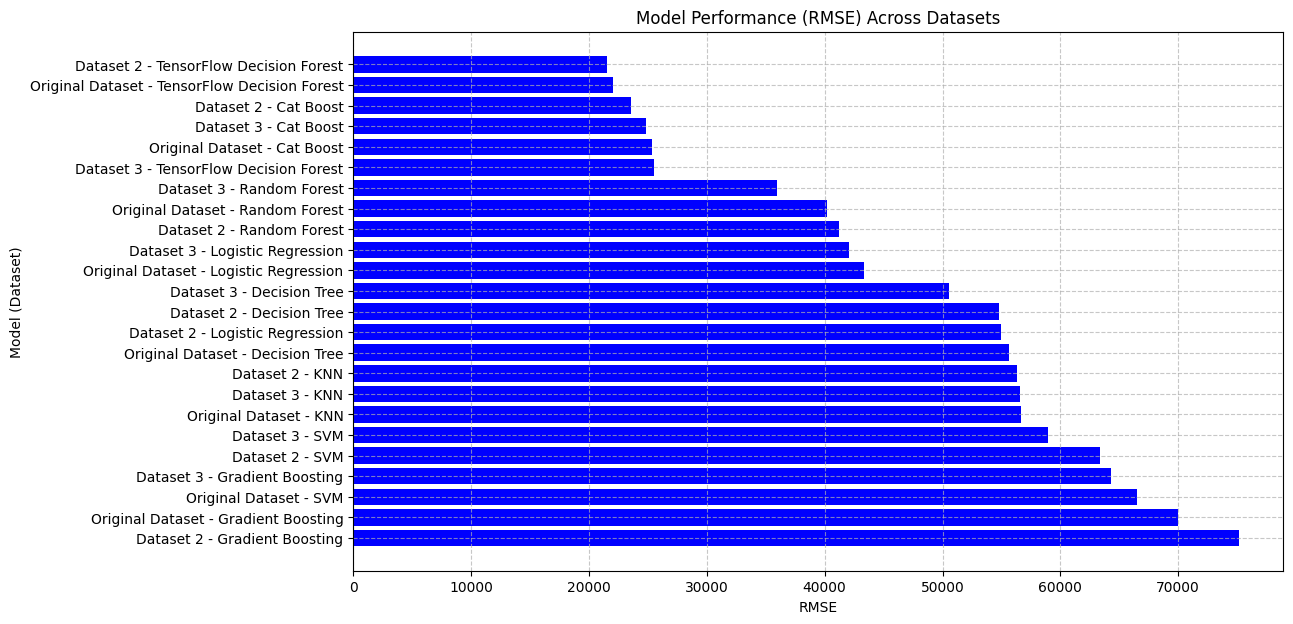

In [56]:
#Call: plot results
print(final_results)
plot_results(final_results)

---------Fine tunning CatBoost and TensorFlow random forest-------

In [57]:
import gc
import traceback

#Fine tunning TFDF with Optuna
# Define the Early Stopping mechanism
def early_stopping(patience=10):
    best_val_loss = np.inf
    epochs_without_improvement = 0

    def check_early_stopping(current_val_loss):
        nonlocal best_val_loss, epochs_without_improvement
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        return epochs_without_improvement >= patience
    
    return check_early_stopping

def objective(trial):
    try:
        # Suggest hyperparameters
        num_trees = trial.suggest_int('num_trees', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 4, 16)
        min_examples = trial.suggest_int('min_examples', 1, 20)
        shrinkage = trial.suggest_float('shrinkage', 0.01, 0.2)
        honest = trial.suggest_categorical('honest', [True, False])

        # Model with suggested parameters
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=num_trees,
            max_depth=max_depth,
            min_examples=min_examples,
            shrinkage=shrinkage,
            honest=honest
        )

        # Prepare dataset
        np.random.seed(42)
        test_indices = np.random.rand(len(df2)) < 0.30
        train_ds_pd, valid_ds_pd = df2.loc[~test_indices], df2.loc[test_indices]


        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label="SalePrice", task=tfdf.keras.Task.REGRESSION)
        
        early_stopper = early_stopping(patience=10)
        # Train model
        history = model.fit(train_ds)

        # Predictions
        predictions = model.predict(valid_ds)
        predictions = [p[0] for p in predictions]

        # Evaluate RMSE
        rmse = np.sqrt(mean_squared_error(valid_ds_pd["SalePrice"], predictions))

        # Clear memory after each trial
        del model  # Delete model to release memory
        del train_ds  # Delete training dataset
        del valid_ds  # Delete validation dataset
        gc.collect()  # Force garbage collection
        # Early stopping check
        if early_stopper(rmse):
            print(f"Early stopping triggered at RMSE: {rmse}")
            return rmse
        else:
            return rmse
    
    except MemoryError as e:
        # Handle MemoryError (out of memory issue)
        print("Memory error occurred:", e)
        tf.keras.backend.clear_session()
        gc.collect()  # Trigger garbage collection
        return float('inf')  # Return a high RMSE value or a custom value to signal failure
    
    except Exception as e:
        # Catch all other exceptions
        print("An error occurred:", e)
        traceback.print_exc()  # This will print the full stack trace for debugging
        tf.keras.backend.clear_session()
        gc.collect()  # Trigger garbage collection
        return float('inf')  # Return a high RMSE value or a custom value to signal failure


tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 1: Broad Exploration (Random Search)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=50)
print("\nPhase 1 - Random Search: ", study.best_params)

# Step 2: Focused Search (TPE)
study.sampler = optuna.samplers.TPESampler()
study.optimize(objective, n_trials=100)
print("\nPhase 2 - TPE Optimization: ", study.best_params)

# Step 3: Final Fine-Tuning (Bayesian)
study.sampler = optuna.samplers.CmaEsSampler()
study.optimize(objective, n_trials=50)
print("\nPhase 3 - Bayesian Optimization: ", study.best_params)

# Best result
print("\nBest RMSE: ", study.best_value)
print("Best Hyperparameters: ", study.best_params)


[I 2025-02-19 08:04:31,273] A new study created in memory with name: no-name-a1d36e73-5e03-4e06-af17-455c15639245


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgjlj5hfk as temporary training directory
Reading training dataset...


2025-02-19 08:04:31.279771: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:31.279781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:31.279784: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.463345. Found 1001 examples.
Training model...


I0000 00:00:1739948671.802782 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948671.802792 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948671.802796 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948671.802971 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948671.802976 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948671.803698 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948671.803739 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.913037
Compiling model...


I0000 00:00:1739948677.650851 7661256 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33247.5
2025-02-19 08:04:37.650875: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 271
2025-02-19 08:04:37.660274: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 242 tree(s) i.e. 242  iteration(s).
2025-02-19 08:04:37.660781: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:242 valid-loss:33247.542969 valid-rmse:33247.542969
I0000 00:00:1739948677.665987 7661256 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgjlj5hfk with prefix 832ff34c925a4cef
I0000 00:00:1739948677.673474 7661256 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:04:38,332] Trial 0 finished with value: 24653.465102561444 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 16, 'shrinkage': 0.01384110095828942, 'honest': False}. Best is trial 0 with value: 24653.465102561444.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmply8gu3s7 as temporary training directory
Reading training dataset...


2025-02-19 08:04:38.336271: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:38.336282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:38.336285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.418434. Found 1001 examples.
Training model...


I0000 00:00:1739948678.803094 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948678.803106 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948678.803111 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948678.803323 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948678.803328 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948678.804038 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948678.804076 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.362966
Compiling model...


I0000 00:00:1739948679.150021 7663592 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36372.4
2025-02-19 08:04:39.150042: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-19 08:04:39.154980: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-19 08:04:39.155221: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:36372.417969 valid-rmse:36372.417969
I0000 00:00:1739948679.155821 7663592 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmply8gu3s7 with prefix 088f148c9d3d4863
I0000 00:00:1739948679.157774 7663592 kernel.cc:944] Save model in resources
I000

Model compiled.


1/1 [==============================] - 0s 65ms/step


[I 2025-02-19 08:04:39,641] Trial 1 finished with value: 24583.46984113286 and parameters: {'num_trees': 1000, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.16886474796872744, 'honest': True}. Best is trial 1 with value: 24583.46984113286.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb_nz7www as temporary training directory
Reading training dataset...


2025-02-19 08:04:39.645140: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:39.645153: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:39.645156: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.414607. Found 1001 examples.
Training model...


I0000 00:00:1739948680.106095 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948680.106105 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948680.106113 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948680.106324 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948680.106331 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948680.107045 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948680.107084 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.792630
Compiling model...


I0000 00:00:1739948681.880004 7664032 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35587
2025-02-19 08:04:41.880031: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 44
2025-02-19 08:04:41.882883: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 15 tree(s) i.e. 15  iteration(s).
2025-02-19 08:04:41.883822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:15 valid-loss:35587.015625 valid-rmse:35587.015625
I0000 00:00:1739948681.884880 7664032 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb_nz7www with prefix 0d7092124abb4076
I0000 00:00:1739948681.886812 7664032 kernel.cc:944] Save model in resources
I0000 

Model compiled.


1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:04:42,391] Trial 2 finished with value: 27604.754836541746 and parameters: {'num_trees': 900, 'max_depth': 16, 'min_examples': 7, 'shrinkage': 0.13586070952375448, 'honest': False}. Best is trial 1 with value: 24583.46984113286.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6cnswobc as temporary training directory
Reading training dataset...


2025-02-19 08:04:42.395910: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:42.395922: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:42.395925: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.419354. Found 1001 examples.
Training model...


I0000 00:00:1739948682.862813 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948682.862824 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948682.862828 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948682.863036 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948682.863041 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948682.863745 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948682.863788 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.787852
Compiling model...


I0000 00:00:1739948683.635473 7664460 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30001.5
2025-02-19 08:04:43.635493: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-19 08:04:43.638724: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-19 08:04:43.639036: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:30001.523438 valid-rmse:30001.523438
I0000 00:00:1739948683.639784 7664460 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6cnswobc with prefix b4906c95b8e548fb
I0000 00:00:1739948683.641193 7664460 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 65ms/step


[I 2025-02-19 08:04:44,125] Trial 3 finished with value: 24685.85109781583 and parameters: {'num_trees': 1000, 'max_depth': 9, 'min_examples': 6, 'shrinkage': 0.09586011394301387, 'honest': True}. Best is trial 1 with value: 24583.46984113286.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpixi6hpeh as temporary training directory
Reading training dataset...


2025-02-19 08:04:44.129204: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:44.129215: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:44.129228: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.419257. Found 1001 examples.
Training model...


I0000 00:00:1739948684.595703 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948684.595715 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948684.595719 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948684.595918 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948684.595927 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948684.596645 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948684.596686 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.429831
Compiling model...


I0000 00:00:1739948686.998277 7664994 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 29689.8
2025-02-19 08:04:46.998300: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 214
2025-02-19 08:04:47.001612: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 185 tree(s) i.e. 185  iteration(s).
2025-02-19 08:04:47.001899: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:185 valid-loss:29689.818359 valid-rmse:29689.818359
I0000 00:00:1739948687.004018 7664994 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpixi6hpeh with prefix e119c360f2304dba
I0000 00:00:1739948687.007162 7664994 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:04:47,525] Trial 4 finished with value: 22577.155413480123 and parameters: {'num_trees': 800, 'max_depth': 15, 'min_examples': 18, 'shrinkage': 0.0630718098653679, 'honest': True}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph_5zghtv as temporary training directory
Reading training dataset...


2025-02-19 08:04:47.529141: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:47.529151: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:47.529154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.418366. Found 1001 examples.
Training model...


I0000 00:00:1739948687.994178 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948687.994189 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948687.994193 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948687.994369 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948687.994374 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948687.995077 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948687.995116 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.654519
Compiling model...


I0000 00:00:1739948688.633563 7666793 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30220.7
2025-02-19 08:04:48.633586: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 120
2025-02-19 08:04:48.636511: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 91 tree(s) i.e. 91  iteration(s).
2025-02-19 08:04:48.636682: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:91 valid-loss:30220.724609 valid-rmse:30220.724609
I0000 00:00:1739948688.637504 7666793 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph_5zghtv with prefix aa41f534222840f0
I0000 00:00:1739948688.639167 7666793 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:04:49,133] Trial 5 finished with value: 24263.462632553616 and parameters: {'num_trees': 700, 'max_depth': 8, 'min_examples': 20, 'shrinkage': 0.17797577618799526, 'honest': True}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjwmfh82r as temporary training directory
Reading training dataset...


2025-02-19 08:04:49.137359: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:49.137368: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:49.137371: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.414997. Found 1001 examples.
Training model...


I0000 00:00:1739948689.600009 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948689.600022 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948689.600025 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948689.600207 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948689.600214 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948689.600918 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948689.600954 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.426920
Compiling model...


I0000 00:00:1739948690.012896 7667839 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32900.7
2025-02-19 08:04:50.012917: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 182
2025-02-19 08:04:50.015752: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 153 tree(s) i.e. 153  iteration(s).
2025-02-19 08:04:50.015844: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:153 valid-loss:32900.679688 valid-rmse:32900.679688
I0000 00:00:1739948690.016636 7667839 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjwmfh82r with prefix b6558b70ed434755
I0000 00:00:1739948690.017801 7667839 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 65ms/step


[I 2025-02-19 08:04:50,521] Trial 6 finished with value: 24112.93382342495 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 1, 'shrinkage': 0.1304234496771678, 'honest': False}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp594av_6n as temporary training directory
Reading training dataset...


2025-02-19 08:04:50.524769: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:50.524779: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:50.524782: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.417729. Found 1001 examples.
Training model...


I0000 00:00:1739948690.989765 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948690.989780 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948690.989783 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948690.989962 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948690.989969 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948690.990697 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948690.990733 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.897019
Compiling model...


I0000 00:00:1739948692.860351 7669374 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32954.5
2025-02-19 08:04:52.860370: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 69
2025-02-19 08:04:52.864704: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 40 tree(s) i.e. 40  iteration(s).
2025-02-19 08:04:52.865766: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:40 valid-loss:32954.539062 valid-rmse:32954.539062
I0000 00:00:1739948692.867405 7669374 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp594av_6n with prefix 003c0b88d3c3454a
I0000 00:00:1739948692.870038 7669374 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:04:53,370] Trial 7 finished with value: 27243.900854423417 and parameters: {'num_trees': 400, 'max_depth': 8, 'min_examples': 1, 'shrinkage': 0.05339713844153918, 'honest': False}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppcahc8tu as temporary training directory
Reading training dataset...


2025-02-19 08:04:53.373850: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:53.373860: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:53.373867: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.418811. Found 1001 examples.
Training model...


I0000 00:00:1739948693.839980 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948693.839989 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948693.839993 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948693.840180 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948693.840186 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948693.840894 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948693.840933 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.229075
Compiling model...


I0000 00:00:1739948696.043767 7670002 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31001
2025-02-19 08:04:56.043795: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 171
2025-02-19 08:04:56.046880: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 142 tree(s) i.e. 142  iteration(s).
2025-02-19 08:04:56.047209: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:142 valid-loss:31000.958984 valid-rmse:31000.958984
I0000 00:00:1739948696.049150 7670002 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppcahc8tu with prefix 5045f327cbe14746
I0000 00:00:1739948696.051626 7670002 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:04:56,569] Trial 8 finished with value: 23819.970692205367 and parameters: {'num_trees': 300, 'max_depth': 16, 'min_examples': 15, 'shrinkage': 0.03215671378959574, 'honest': True}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmutn6l9j as temporary training directory
Reading training dataset...


2025-02-19 08:04:56.573505: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:56.573514: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:56.573518: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.421408. Found 1001 examples.
Training model...


I0000 00:00:1739948697.042946 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948697.042956 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948697.042960 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948697.043131 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948697.043136 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948697.043821 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948697.043857 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.095322
Compiling model...


I0000 00:00:1739948698.121453 7671449 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33280
2025-02-19 08:04:58.121474: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 57
2025-02-19 08:04:58.123808: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 28 tree(s) i.e. 28  iteration(s).
2025-02-19 08:04:58.124294: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:28 valid-loss:33280.007812 valid-rmse:33280.007812
I0000 00:00:1739948698.125244 7671449 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmutn6l9j with prefix 17a6994662d44ae6
I0000 00:00:1739948698.126953 7671449 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:04:58,618] Trial 9 finished with value: 28405.73197880745 and parameters: {'num_trees': 400, 'max_depth': 8, 'min_examples': 5, 'shrinkage': 0.05993167360702157, 'honest': False}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1k3d4lfe as temporary training directory
Reading training dataset...


2025-02-19 08:04:58.622323: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:58.622336: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:04:58.622339: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.419689. Found 1001 examples.
Training model...


I0000 00:00:1739948699.089087 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948699.089098 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948699.089101 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948699.089270 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948699.089274 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948699.089983 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948699.090023 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.593283
Compiling model...


2025-02-19 08:05:01.637367: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:12984.116211 train-rmse:12984.116211 valid-loss:32873.480469 valid-rmse:32873.480469
2025-02-19 08:05:01.637460: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-19 08:05:01.640987: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 96 tree(s) i.e. 96  iteration(s).
2025-02-19 08:05:01.641045: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:96 valid-loss:32802.707031 valid-rmse:32802.707031
I0000 00:00:1739948701.643138 7671984 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1k3d4lfe with prefix 4196a771a3884a3b
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:05:02,324] Trial 10 finished with value: 23265.201779841864 and parameters: {'num_trees': 100, 'max_depth': 13, 'min_examples': 15, 'shrinkage': 0.0621496270904718, 'honest': False}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvc3ha9tk as temporary training directory
Reading training dataset...


2025-02-19 08:05:02.328737: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:02.328748: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:02.328751: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.421803. Found 1001 examples.
Training model...


I0000 00:00:1739948702.799063 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948702.799073 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948702.799077 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948702.799268 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948702.799272 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948702.799961 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948702.800000 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.023183
Compiling model...


I0000 00:00:1739948703.804196 7673244 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30537.3
2025-02-19 08:05:03.804215: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 108
2025-02-19 08:05:03.806835: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 79 tree(s) i.e. 79  iteration(s).
2025-02-19 08:05:03.807146: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:79 valid-loss:30537.337891 valid-rmse:30537.337891
I0000 00:00:1739948703.808263 7673244 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvc3ha9tk with prefix e03c1d34c74d463f
I0000 00:00:1739948703.810710 7673244 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:05:04,312] Trial 11 finished with value: 23369.456994396478 and parameters: {'num_trees': 200, 'max_depth': 12, 'min_examples': 15, 'shrinkage': 0.12249587097080694, 'honest': True}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8dwixqt4 as temporary training directory
Reading training dataset...


2025-02-19 08:05:04.315908: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:04.315918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:04.315921: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.415720. Found 1001 examples.
Training model...


I0000 00:00:1739948704.779516 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948704.779525 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948704.779529 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948704.779730 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948704.779734 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948704.780437 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948704.780475 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.393842
Compiling model...


I0000 00:00:1739948705.161544 7674180 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33007.1
2025-02-19 08:05:05.161564: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-19 08:05:05.162701: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-19 08:05:05.162814: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:33007.125000 valid-rmse:33007.125000
I0000 00:00:1739948705.163357 7674180 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8dwixqt4 with prefix bb20bb52686d43e6
I0000 00:00:1739948705.165103 7674180 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 65ms/step


[I 2025-02-19 08:05:05,686] Trial 12 finished with value: 26372.05611890317 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 18, 'shrinkage': 0.05198582260231571, 'honest': True}. Best is trial 4 with value: 22577.155413480123.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsb8hw31_ as temporary training directory
Reading training dataset...


2025-02-19 08:05:05.690695: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:05.690707: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:05.690764: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.435168. Found 1001 examples.
Training model...


I0000 00:00:1739948706.181576 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948706.181587 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948706.181591 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948706.181766 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948706.181771 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948706.182457 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948706.182494 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:13.968545
Compiling model...


I0000 00:00:1739948720.138388 7613901 decision_forest.cc:761] Model loaded with 500 root(s), 74320 node(s), and 87 input feature(s).
I0000 00:00:1739948720.138715 7613901 abstract_model.cc:1404] Engine "GradientBoostedTreesOptPred" built
2025-02-19 08:05:20.138730: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:05:20,911] Trial 13 finished with value: 21825.145790751947 and parameters: {'num_trees': 500, 'max_depth': 8, 'min_examples': 1, 'shrinkage': 0.010080987194167532, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5stty2ni as temporary training directory
Reading training dataset...


2025-02-19 08:05:20.917322: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:20.917333: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:20.917336: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.451828. Found 1001 examples.
Training model...


I0000 00:00:1739948721.475051 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948721.475074 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948721.475089 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948721.485295 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948721.485357 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948721.490565 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948721.493033 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.522920
Compiling model...


I0000 00:00:1739948722.939790 7679746 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31826
2025-02-19 08:05:22.939813: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-19 08:05:22.942149: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-19 08:05:22.942471: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:31825.996094 valid-rmse:31825.996094
I0000 00:00:1739948722.943726 7679746 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5stty2ni with prefix 503ef876e8fb42cc
I0000 00:00:1739948722.945814 7679746 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:05:23,544] Trial 14 finished with value: 24430.457760091056 and parameters: {'num_trees': 200, 'max_depth': 13, 'min_examples': 18, 'shrinkage': 0.12468095497158717, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkj9sao0l as temporary training directory
Reading training dataset...


2025-02-19 08:05:23.548110: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:23.548120: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:23.548123: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426956. Found 1001 examples.
Training model...


I0000 00:00:1739948724.024423 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948724.024432 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948724.024436 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948724.024632 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948724.024636 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948724.025366 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948724.025408 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.588354
Compiling model...


I0000 00:00:1739948724.596659 7680558 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32267.2
2025-02-19 08:05:24.596681: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 269
2025-02-19 08:05:24.599687: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 240 tree(s) i.e. 240  iteration(s).
2025-02-19 08:05:24.599770: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:240 valid-loss:32267.158203 valid-rmse:32267.158203
I0000 00:00:1739948724.600721 7680558 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkj9sao0l with prefix b9de7196013a4181
I0000 00:00:1739948724.602130 7680558 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:05:25,107] Trial 15 finished with value: 23916.86795267982 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 20, 'shrinkage': 0.029840042717713157, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpp_5lfh7c as temporary training directory
Reading training dataset...


2025-02-19 08:05:25.111143: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:25.111153: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:25.111157: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.421110. Found 1001 examples.
Training model...


I0000 00:00:1739948725.579524 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948725.579533 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948725.579538 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948725.579715 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948725.579721 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948725.580410 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948725.580448 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.649595
Compiling model...


I0000 00:00:1739948727.202408 7682796 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32765
2025-02-19 08:05:27.202432: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 75
2025-02-19 08:05:27.208213: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 46 tree(s) i.e. 46  iteration(s).
2025-02-19 08:05:27.208832: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:46 valid-loss:32764.990234 valid-rmse:32764.990234
I0000 00:00:1739948727.210484 7682796 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpp_5lfh7c with prefix 46bd94bb9d1e42f0
I0000 00:00:1739948727.212853 7682796 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:05:27,725] Trial 16 finished with value: 25891.69844728883 and parameters: {'num_trees': 700, 'max_depth': 9, 'min_examples': 3, 'shrinkage': 0.044234368299234404, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpktqs23kp as temporary training directory
Reading training dataset...


2025-02-19 08:05:27.729487: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:27.729496: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:27.729500: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426193. Found 1001 examples.
Training model...


I0000 00:00:1739948728.203025 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948728.203036 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948728.203040 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948728.203234 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948728.203239 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948728.203959 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948728.204000 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.288061
Compiling model...


I0000 00:00:1739948728.479701 7683471 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31935.3
2025-02-19 08:05:28.479721: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 127
2025-02-19 08:05:28.480936: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 98 tree(s) i.e. 98  iteration(s).
2025-02-19 08:05:28.481022: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:98 valid-loss:31935.339844 valid-rmse:31935.339844
I0000 00:00:1739948728.481644 7683471 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpktqs23kp with prefix 59e99f6753e645ee
I0000 00:00:1739948728.483040 7683471 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:05:28,995] Trial 17 finished with value: 23138.902034660834 and parameters: {'num_trees': 700, 'max_depth': 4, 'min_examples': 8, 'shrinkage': 0.1573760260691746, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8sq38zw2 as temporary training directory
Reading training dataset...


2025-02-19 08:05:28.999661: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:28.999672: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:28.999675: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.423678. Found 1001 examples.
Training model...


I0000 00:00:1739948729.474636 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948729.474647 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948729.474654 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948729.474852 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948729.474858 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948729.475568 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948729.475607 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.675189
Compiling model...


I0000 00:00:1739948734.092170 7684562 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32084.5
2025-02-19 08:05:34.092203: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 518
2025-02-19 08:05:34.099389: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 489 tree(s) i.e. 489  iteration(s).
2025-02-19 08:05:34.099640: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:489 valid-loss:32084.494141 valid-rmse:32084.494141
I0000 00:00:1739948734.104508 7684562 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8sq38zw2 with prefix 51b4d303875a4609
I0000 00:00:1739948734.110688 7684562 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:05:34,653] Trial 18 finished with value: 24165.633651973596 and parameters: {'num_trees': 600, 'max_depth': 11, 'min_examples': 15, 'shrinkage': 0.1588515777220913, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp35eotuvr as temporary training directory
Reading training dataset...


2025-02-19 08:05:34.658036: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:34.658047: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:34.658050: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.423270. Found 1001 examples.
Training model...


I0000 00:00:1739948735.128727 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948735.128736 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948735.128739 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948735.128939 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948735.128944 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948735.129658 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948735.129699 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.887894
Compiling model...


I0000 00:00:1739948736.991761 7688895 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35959.9
2025-02-19 08:05:36.991784: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-19 08:05:36.995867: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-19 08:05:36.997106: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:35959.929688 valid-rmse:35959.929688
I0000 00:00:1739948736.999177 7688895 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp35eotuvr with prefix 8973ffb8cb1245a3
I0000 00:00:1739948737.001739 7688895 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:05:37,622] Trial 19 finished with value: 28408.33955524542 and parameters: {'num_trees': 100, 'max_depth': 15, 'min_examples': 6, 'shrinkage': 0.12786089562656944, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu1jstuii as temporary training directory
Reading training dataset...


2025-02-19 08:05:37.626946: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:37.626956: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:37.626959: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.430742. Found 1001 examples.
Training model...


I0000 00:00:1739948738.107075 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948738.107086 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948738.107091 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948738.107289 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948738.107293 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948738.107992 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948738.108043 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.661550
Compiling model...


I0000 00:00:1739948738.751470 7689394 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31848
2025-02-19 08:05:38.751500: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-19 08:05:38.754617: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-19 08:05:38.754930: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:31847.955078 valid-rmse:31847.955078
I0000 00:00:1739948738.755781 7689394 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu1jstuii with prefix 61d1cfc233b14e7d
I0000 00:00:1739948738.757194 7689394 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:05:39,285] Trial 20 finished with value: 23907.998681917295 and parameters: {'num_trees': 400, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.1993939833386886, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpeyhjkomt as temporary training directory
Reading training dataset...


2025-02-19 08:05:39.289869: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:39.289879: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:39.289882: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426133. Found 1001 examples.
Training model...


I0000 00:00:1739948739.764322 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948739.764337 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948739.764341 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948739.764531 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948739.764538 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948739.765251 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948739.765287 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.321480
Compiling model...


I0000 00:00:1739948741.067343 7690313 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34452.8
2025-02-19 08:05:41.067372: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-19 08:05:41.070902: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-19 08:05:41.071721: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shri

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:05:41,591] Trial 21 finished with value: 27494.84284536182 and parameters: {'num_trees': 100, 'max_depth': 12, 'min_examples': 5, 'shrinkage': 0.16422241422072373, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpasha12ws as temporary training directory
Reading training dataset...


2025-02-19 08:05:41.595007: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:41.595018: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:41.595022: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.424400. Found 1001 examples.
Training model...


I0000 00:00:1739948742.067734 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948742.067747 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948742.067750 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948742.067958 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948742.067965 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948742.068660 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948742.068700 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.138714
Compiling model...


I0000 00:00:1739948743.184198 7690712 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33572.3
2025-02-19 08:05:43.184222: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 313
2025-02-19 08:05:43.186785: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 284 tree(s) i.e. 284  iteration(s).
2025-02-19 08:05:43.186895: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:284 valid-loss:33572.296875 valid-rmse:33572.296875
I0000 00:00:1739948743.188767 7690712 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpasha12ws with prefix 3ebf83dd9eba4819
I0000 00:00:1739948743.191098 7690712 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:05:43,725] Trial 22 finished with value: 27310.51077103289 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 17, 'shrinkage': 0.010015647849197513, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpekdsfwdi as temporary training directory
Reading training dataset...


2025-02-19 08:05:43.729035: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:43.729045: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:43.729049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426958. Found 1001 examples.
Training model...


I0000 00:00:1739948744.204640 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948744.204650 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948744.204654 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948744.204841 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948744.204845 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948744.205536 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948744.205576 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.912828
Compiling model...


I0000 00:00:1739948747.084636 7693298 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34332.1
2025-02-19 08:05:47.084659: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 53
2025-02-19 08:05:47.090530: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 24 tree(s) i.e. 24  iteration(s).
2025-02-19 08:05:47.092346: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:24 valid-loss:34332.058594 valid-rmse:34332.058594
I0000 00:00:1739948747.094539 7693298 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpekdsfwdi with prefix f60ff421f64a4a71
I0000 00:00:1739948747.097805 7693298 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:05:47,623] Trial 23 finished with value: 27010.904883422856 and parameters: {'num_trees': 500, 'max_depth': 10, 'min_examples': 2, 'shrinkage': 0.09232692765744334, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl_wop0cv as temporary training directory
Reading training dataset...


2025-02-19 08:05:47.627810: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:47.627821: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:47.627824: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.422131. Found 1001 examples.
Training model...


I0000 00:00:1739948748.099298 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948748.099309 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948748.099313 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948748.099482 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948748.099489 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948748.100172 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948748.100208 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.623569
Compiling model...


2025-02-19 08:05:48.707857: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:14003.424805 train-rmse:14003.424805 valid-loss:32210.017578 valid-rmse:32210.017578
2025-02-19 08:05:48.707873: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-19 08:05:48.710426: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 99 tree(s) i.e. 99  iteration(s).
2025-02-19 08:05:48.710439: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:99 valid-loss:32197.068359 valid-rmse:32197.068359
I0000 00:00:1739948748.711299 7693800 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl_wop0cv with prefix 279ea6ad50a74c5f
I00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:05:49,226] Trial 24 finished with value: 24375.60058582915 and parameters: {'num_trees': 100, 'max_depth': 7, 'min_examples': 19, 'shrinkage': 0.09264144328162063, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5p1rvmxq as temporary training directory
Reading training dataset...


2025-02-19 08:05:49.231152: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:49.231163: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:49.231166: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.428586. Found 1001 examples.
Training model...


I0000 00:00:1739948749.713056 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948749.713066 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948749.713070 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948749.713253 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948749.713260 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948749.713943 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948749.713980 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.252436
Compiling model...


I0000 00:00:1739948754.913383 7694668 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32284.6
2025-02-19 08:05:54.913404: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 79
2025-02-19 08:05:54.921173: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 50 tree(s) i.e. 50  iteration(s).
2025-02-19 08:05:54.922776: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:50 valid-loss:32284.587891 valid-rmse:32284.587891
I0000 00:00:1739948754.927263 7694668 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5p1rvmxq with prefix e2c8a5793f444372
I0000 00:00:1739948754.933236 7694668 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:05:55,499] Trial 25 finished with value: 25128.741644118345 and parameters: {'num_trees': 400, 'max_depth': 13, 'min_examples': 2, 'shrinkage': 0.0471232617305426, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3gpr1dlm as temporary training directory
Reading training dataset...


2025-02-19 08:05:55.502789: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:55.502799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:55.502802: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.421521. Found 1001 examples.
Training model...


I0000 00:00:1739948755.972036 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948755.972049 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948755.972053 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948755.972243 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948755.972248 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948755.972976 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948755.973012 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.655287
Compiling model...


I0000 00:00:1739948756.612276 7695405 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30005.5
2025-02-19 08:05:56.612299: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 217
2025-02-19 08:05:56.614710: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 188 tree(s) i.e. 188  iteration(s).
2025-02-19 08:05:56.614817: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:188 valid-loss:30005.527344 valid-rmse:30005.527344
I0000 00:00:1739948756.615678 7695405 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3gpr1dlm with prefix 60b2d1f7cb4f4416
I0000 00:00:1739948756.617239 7695405 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:05:57,140] Trial 26 finished with value: 22548.682791391195 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 15, 'shrinkage': 0.09274801870882614, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4875yz18 as temporary training directory
Reading training dataset...


2025-02-19 08:05:57.143805: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:57.143815: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:57.143819: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.429875. Found 1001 examples.
Training model...


I0000 00:00:1739948757.622056 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948757.622066 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948757.622070 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948757.622274 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948757.622279 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948757.623000 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948757.623041 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.720232
Compiling model...


I0000 00:00:1739948758.325408 7697216 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33250.3
2025-02-19 08:05:58.325427: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 52
2025-02-19 08:05:58.328876: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 23 tree(s) i.e. 23  iteration(s).
2025-02-19 08:05:58.329432: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:23 valid-loss:33250.316406 valid-rmse:33250.316406
I0000 00:00:1739948758.330171 7697216 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4875yz18 with prefix e88b2a04fc474243
I0000 00:00:1739948758.331918 7697216 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:05:58,850] Trial 27 finished with value: 24208.63623991805 and parameters: {'num_trees': 200, 'max_depth': 7, 'min_examples': 1, 'shrinkage': 0.13391081546625105, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxpdq_f9i as temporary training directory
Reading training dataset...


2025-02-19 08:05:58.854611: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:58.854623: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:05:58.854626: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426332. Found 1001 examples.
Training model...


I0000 00:00:1739948759.328707 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948759.328716 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948759.328720 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948759.328930 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948759.328934 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948759.329634 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948759.329676 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.627359
Compiling model...


2025-02-19 08:05:59.819006: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1605] 	num-trees:98 train-loss:19961.882812 train-rmse:19961.882812 valid-loss:31321.173828 valid-rmse:31321.173828
I0000 00:00:1739948759.941728 7697706 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31308.5
2025-02-19 08:05:59.941751: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 126
2025-02-19 08:05:59.943330: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 97 tree(s) i.e. 97  iteration(s).
2025-02-19 08:05:59.943488: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:97 valid-loss:31308.535156 valid-rmse:31308.535156
I0000 00:00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:06:00,469] Trial 28 finished with value: 23741.820954066934 and parameters: {'num_trees': 1000, 'max_depth': 7, 'min_examples': 16, 'shrinkage': 0.07969079543421814, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbtfs_k4q as temporary training directory
Reading training dataset...


2025-02-19 08:06:00.473933: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:00.473957: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:00.473960: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426575. Found 1001 examples.
Training model...


I0000 00:00:1739948760.948399 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948760.948410 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948760.948414 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948760.948593 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948760.948598 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948760.949285 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948760.949323 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.520505
Compiling model...


I0000 00:00:1739948762.446691 7698785 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33827.6
2025-02-19 08:06:02.446716: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 83
2025-02-19 08:06:02.450227: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 54 tree(s) i.e. 54  iteration(s).
2025-02-19 08:06:02.450598: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:54 valid-loss:33827.597656 valid-rmse:33827.597656
I0000 00:00:1739948762.451978 7698785 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbtfs_k4q with prefix 1af95e78eb0547ea
I0000 00:00:1739948762.454028 7698785 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:02,986] Trial 29 finished with value: 25817.248884155204 and parameters: {'num_trees': 800, 'max_depth': 9, 'min_examples': 11, 'shrinkage': 0.04406319147461498, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmix26hdj as temporary training directory
Reading training dataset...


2025-02-19 08:06:02.991269: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:02.991279: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:02.991285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.450060. Found 1001 examples.
Training model...


I0000 00:00:1739948763.490721 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948763.490735 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948763.490742 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948763.490968 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948763.490975 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948763.491714 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948763.491754 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.493253
Compiling model...


I0000 00:00:1739948764.966171 7699537 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31560.9
2025-02-19 08:06:04.966202: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 97
2025-02-19 08:06:04.968619: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 68 tree(s) i.e. 68  iteration(s).
2025-02-19 08:06:04.968964: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:68 valid-loss:31560.873047 valid-rmse:31560.873047
I0000 00:00:1739948764.970109 7699537 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmix26hdj with prefix 7e68adb6fc014112
I0000 00:00:1739948764.971720 7699537 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:06:05,628] Trial 30 finished with value: 23969.200338078044 and parameters: {'num_trees': 800, 'max_depth': 13, 'min_examples': 14, 'shrinkage': 0.15821193430996575, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpq5y1mfq1 as temporary training directory
Reading training dataset...


2025-02-19 08:06:05.633750: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:05.633762: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:05.633765: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.463293. Found 1001 examples.
Training model...


I0000 00:00:1739948766.149454 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948766.149468 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948766.149475 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948766.149740 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948766.149749 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948766.150602 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948766.150654 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.454680
Compiling model...


I0000 00:00:1739948767.585515 7700390 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34613.3
2025-02-19 08:06:07.585534: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 45
2025-02-19 08:06:07.589001: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 16 tree(s) i.e. 16  iteration(s).
2025-02-19 08:06:07.589663: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:16 valid-loss:34613.273438 valid-rmse:34613.273438
I0000 00:00:1739948767.590637 7700390 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpq5y1mfq1 with prefix 2058ac1e5aa94bef
I0000 00:00:1739948767.592159 7700390 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:06:08,134] Trial 31 finished with value: 25878.319965309634 and parameters: {'num_trees': 600, 'max_depth': 14, 'min_examples': 4, 'shrinkage': 0.128335908708115, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxabn9b2d as temporary training directory
Reading training dataset...


2025-02-19 08:06:08.138277: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:08.138287: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:08.138291: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.421615. Found 1001 examples.
Training model...


I0000 00:00:1739948768.608008 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948768.608017 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948768.608021 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948768.608209 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948768.608213 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948768.608924 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948768.608960 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.230118
Compiling model...


I0000 00:00:1739948769.811792 7700851 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30907.7
2025-02-19 08:06:09.811818: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-19 08:06:09.814665: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-19 08:06:09.815246: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:30907.683594 valid-rmse:30907.683594
I0000 00:00:1739948769.816548 7700851 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxabn9b2d with prefix d1e6357ad3f6448b
I0000 00:00:1739948769.818446 7700851 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:06:10,519] Trial 32 finished with value: 24596.283349170022 and parameters: {'num_trees': 1000, 'max_depth': 10, 'min_examples': 3, 'shrinkage': 0.10479538036793552, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpi81l2o3v as temporary training directory
Reading training dataset...


2025-02-19 08:06:10.523423: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:10.523434: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:10.523437: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.441935. Found 1001 examples.
Training model...


I0000 00:00:1739948771.014976 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948771.014986 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948771.014991 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948771.015192 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948771.015198 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948771.015899 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948771.015940 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.781903
Compiling model...


I0000 00:00:1739948771.782649 7701419 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34639.5
2025-02-19 08:06:11.782675: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-19 08:06:11.784355: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-19 08:06:11.784761: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:34639.527344 valid-rmse:34639.527344
I0000 00:00:1739948771.785400 7701419 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpi81l2o3v with prefix 4b93a211148f4731
I0000 00:00:1739948771.787684 7701419 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:06:12,341] Trial 33 finished with value: 27647.735890448967 and parameters: {'num_trees': 400, 'max_depth': 10, 'min_examples': 10, 'shrinkage': 0.14110778612498828, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8q3w0s6q as temporary training directory
Reading training dataset...


2025-02-19 08:06:12.346202: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:12.346211: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:12.346214: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.432359. Found 1001 examples.
Training model...


I0000 00:00:1739948772.830275 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948772.830285 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948772.830289 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948772.830485 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948772.830490 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948772.831222 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948772.831264 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.623194
Compiling model...


I0000 00:00:1739948773.438114 7701850 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32744.1
2025-02-19 08:06:13.438135: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 114
2025-02-19 08:06:13.440504: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 85 tree(s) i.e. 85  iteration(s).
2025-02-19 08:06:13.440677: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:85 valid-loss:32744.062500 valid-rmse:32744.062500
I0000 00:00:1739948773.441484 7701850 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8q3w0s6q with prefix 7ad4510a6a5547b6
I0000 00:00:1739948773.442942 7701850 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:06:13,987] Trial 34 finished with value: 26445.46150286488 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 10, 'shrinkage': 0.02930923244009947, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprusdatv5 as temporary training directory
Reading training dataset...


2025-02-19 08:06:13.992607: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:13.992617: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:13.992620: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.424566. Found 1001 examples.
Training model...


I0000 00:00:1739948774.466060 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948774.466069 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948774.466074 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948774.466272 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948774.466278 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948774.466995 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948774.467037 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.501675
Compiling model...


I0000 00:00:1739948774.955468 7702837 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31848.4
2025-02-19 08:06:14.955494: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-19 08:06:14.956887: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-19 08:06:14.957004: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:31848.441406 valid-rmse:31848.441406
I0000 00:00:1739948774.957711 7702837 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprusdatv5 with prefix b8de61eedf934a42
I0000 00:00:1739948774.958806 7702837 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:06:15,489] Trial 35 finished with value: 24287.86934322402 and parameters: {'num_trees': 600, 'max_depth': 5, 'min_examples': 20, 'shrinkage': 0.07021063255023961, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpms_jn4rh as temporary training directory
Reading training dataset...


2025-02-19 08:06:15.493279: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:15.493288: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:15.493291: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.430017. Found 1001 examples.
Training model...


I0000 00:00:1739948775.970915 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948775.970927 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948775.970933 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948775.971123 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948775.971128 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948775.971825 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948775.971861 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.339331
Compiling model...


I0000 00:00:1739948778.283149 7703990 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32944.3
2025-02-19 08:06:18.283171: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 119
2025-02-19 08:06:18.287538: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-19 08:06:18.287905: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:32944.312500 valid-rmse:32944.312500
I0000 00:00:1739948778.289984 7703990 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpms_jn4rh with prefix 4dfec0a499a24ee8
I0000 00:00:1739948778.292841 7703990 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:18,832] Trial 36 finished with value: 23589.130784355733 and parameters: {'num_trees': 900, 'max_depth': 15, 'min_examples': 16, 'shrinkage': 0.05757073068030325, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl0hkce6i as temporary training directory
Reading training dataset...


2025-02-19 08:06:18.836835: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:18.836844: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:18.836847: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.427079. Found 1001 examples.
Training model...


I0000 00:00:1739948779.312688 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948779.312698 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948779.312703 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948779.312885 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948779.312891 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948779.313575 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948779.313610 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.665041
Compiling model...


I0000 00:00:1739948780.957232 7705017 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31506.2
2025-02-19 08:06:20.957265: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 118
2025-02-19 08:06:20.960450: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 89 tree(s) i.e. 89  iteration(s).
2025-02-19 08:06:20.960780: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:89 valid-loss:31506.191406 valid-rmse:31506.191406
I0000 00:00:1739948780.962178 7705017 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl0hkce6i with prefix 429eec362bb04aca
I0000 00:00:1739948780.963996 7705017 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:21,496] Trial 37 finished with value: 23227.078728141685 and parameters: {'num_trees': 800, 'max_depth': 14, 'min_examples': 14, 'shrinkage': 0.07441370503356758, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7476blih as temporary training directory
Reading training dataset...


2025-02-19 08:06:21.500487: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:21.500496: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:21.500499: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.428162. Found 1001 examples.
Training model...


I0000 00:00:1739948781.976844 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948781.976857 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948781.976860 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948781.977058 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948781.977063 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948781.977747 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948781.977783 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.262503
Compiling model...


I0000 00:00:1739948783.214669 7706043 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30734.4
2025-02-19 08:06:23.214692: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 91
2025-02-19 08:06:23.216859: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 62 tree(s) i.e. 62  iteration(s).
2025-02-19 08:06:23.217151: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:62 valid-loss:30734.425781 valid-rmse:30734.425781
I0000 00:00:1739948783.218457 7706043 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7476blih with prefix 4ce6ccdb275d4ea0
I0000 00:00:1739948783.222363 7706043 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:06:23,770] Trial 38 finished with value: 24527.15038244356 and parameters: {'num_trees': 500, 'max_depth': 13, 'min_examples': 17, 'shrinkage': 0.12790573637672126, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7gzkzvv0 as temporary training directory
Reading training dataset...


2025-02-19 08:06:23.774962: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:23.774973: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:23.774977: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.423854. Found 1001 examples.
Training model...


I0000 00:00:1739948784.246750 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948784.246759 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948784.246764 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948784.246970 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948784.246974 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948784.247670 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948784.247709 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.430765
Compiling model...


I0000 00:00:1739948785.659298 7706842 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 37281.7
2025-02-19 08:06:25.659318: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-19 08:06:25.662969: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-19 08:06:25.663672: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shri

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:06:26,195] Trial 39 finished with value: 26260.397278710632 and parameters: {'num_trees': 400, 'max_depth': 12, 'min_examples': 4, 'shrinkage': 0.1987369806889619, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7jr0qu5o as temporary training directory
Reading training dataset...


2025-02-19 08:06:26.199645: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:26.199654: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:26.199657: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.420387. Found 1001 examples.
Training model...


I0000 00:00:1739948786.667893 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948786.667902 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948786.667906 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948786.668082 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948786.668086 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948786.668803 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948786.668842 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.617114
Compiling model...


I0000 00:00:1739948787.274513 7707233 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32272.8
2025-02-19 08:06:27.274533: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 55
2025-02-19 08:06:27.275875: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 26 tree(s) i.e. 26  iteration(s).
2025-02-19 08:06:27.276154: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:26 valid-loss:32272.750000 valid-rmse:32272.750000
I0000 00:00:1739948787.276666 7707233 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp7jr0qu5o with prefix d38ad71070a9417f
I0000 00:00:1739948787.277818 7707233 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:06:27,802] Trial 40 finished with value: 25162.70095399016 and parameters: {'num_trees': 200, 'max_depth': 15, 'min_examples': 20, 'shrinkage': 0.17181254802929846, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg7dkcf84 as temporary training directory
Reading training dataset...


2025-02-19 08:06:27.806874: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:27.806886: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:27.806890: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.425602. Found 1001 examples.
Training model...


I0000 00:00:1739948788.279901 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948788.279911 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948788.279914 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948788.280091 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948788.280095 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948788.280806 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948788.280844 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.731591
Compiling model...


I0000 00:00:1739948793.960192 7707745 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34338.3
2025-02-19 08:06:33.960224: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-19 08:06:33.968855: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-19 08:06:33.970528: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:34338.312500 valid-rmse:34338.312500
I0000 00:00:1739948793.974711 7707745 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpg7dkcf84 with prefix e516127eaae147aa
I0000 00:00:1739948793.980227 7707745 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:34,544] Trial 41 finished with value: 29214.429030030627 and parameters: {'num_trees': 300, 'max_depth': 14, 'min_examples': 5, 'shrinkage': 0.02919115751776187, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmyjgrmqk as temporary training directory
Reading training dataset...


2025-02-19 08:06:34.548455: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:34.548466: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:34.548469: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.425004. Found 1001 examples.
Training model...


I0000 00:00:1739948795.027104 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948795.027119 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948795.027125 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948795.027339 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948795.027345 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948795.028060 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948795.028103 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.891749
Compiling model...


I0000 00:00:1739948795.904042 7708551 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32727.8
2025-02-19 08:06:35.904063: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 69
2025-02-19 08:06:35.905902: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 40 tree(s) i.e. 40  iteration(s).
2025-02-19 08:06:35.906274: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:40 valid-loss:32727.753906 valid-rmse:32727.753906
I0000 00:00:1739948795.907108 7708551 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmyjgrmqk with prefix 87a8356906714da5
I0000 00:00:1739948795.908763 7708551 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:06:36,442] Trial 42 finished with value: 23872.2394797213 and parameters: {'num_trees': 200, 'max_depth': 14, 'min_examples': 12, 'shrinkage': 0.09089538514193334, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpggzuvl42 as temporary training directory
Reading training dataset...


2025-02-19 08:06:36.446142: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:36.446151: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:36.446154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.425763. Found 1001 examples.
Training model...


I0000 00:00:1739948796.920560 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948796.920572 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948796.920576 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948796.920785 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948796.920791 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948796.921521 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948796.921570 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.600027
Compiling model...


I0000 00:00:1739948800.483311 7709172 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36018.9
2025-02-19 08:06:40.483341: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 78
2025-02-19 08:06:40.489143: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 49 tree(s) i.e. 49  iteration(s).
2025-02-19 08:06:40.490303: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:49 valid-loss:36018.921875 valid-rmse:36018.921875
I0000 00:00:1739948800.493031 7709172 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpggzuvl42 with prefix b24cb94ab0f14db6
I0000 00:00:1739948800.496835 7709172 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:06:41,125] Trial 43 finished with value: 27587.204396738874 and parameters: {'num_trees': 500, 'max_depth': 12, 'min_examples': 6, 'shrinkage': 0.03625910543227959, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpa6qgwdqj as temporary training directory
Reading training dataset...


2025-02-19 08:06:41.128985: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:41.128995: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:41.128998: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.432544. Found 1001 examples.
Training model...


I0000 00:00:1739948801.613247 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948801.613258 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948801.613262 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948801.613472 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948801.613476 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948801.614202 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948801.614242 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.531581
Compiling model...


I0000 00:00:1739948802.130449 7709911 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 36366.5
2025-02-19 08:06:42.130474: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 75
2025-02-19 08:06:42.132154: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 46 tree(s) i.e. 46  iteration(s).
2025-02-19 08:06:42.132446: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:46 valid-loss:36366.546875 valid-rmse:36366.546875
I0000 00:00:1739948802.133091 7709911 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpa6qgwdqj with prefix f03d3171c28c4611
I0000 00:00:1739948802.134646 7709911 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:42,671] Trial 44 finished with value: 22990.84075227554 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.13423999568040415, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpao5rw594 as temporary training directory
Reading training dataset...


2025-02-19 08:06:42.675135: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:42.675144: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:42.675147: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.424837. Found 1001 examples.
Training model...


I0000 00:00:1739948803.148377 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948803.148390 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948803.148394 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948803.148598 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948803.148604 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948803.149350 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948803.149391 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.077887
Compiling model...


I0000 00:00:1739948804.206968 7710589 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33960.8
2025-02-19 08:06:44.206991: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 92
2025-02-19 08:06:44.209531: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 63 tree(s) i.e. 63  iteration(s).
2025-02-19 08:06:44.209982: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:63 valid-loss:33960.828125 valid-rmse:33960.828125
I0000 00:00:1739948804.211117 7710589 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpao5rw594 with prefix f2ca1964128b41a4
I0000 00:00:1739948804.212917 7710589 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:44,766] Trial 45 finished with value: 23039.3303552665 and parameters: {'num_trees': 1000, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.09731119372067908, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpynttlgfc as temporary training directory
Reading training dataset...


2025-02-19 08:06:44.769891: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:44.769901: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:44.769904: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426817. Found 1001 examples.
Training model...


I0000 00:00:1739948805.248560 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948805.248571 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948805.248575 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948805.248763 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948805.248770 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948805.249512 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948805.249550 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.971254
Compiling model...


I0000 00:00:1739948808.182462 7711401 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31951.5
2025-02-19 08:06:48.182487: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 192
2025-02-19 08:06:48.188540: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 163 tree(s) i.e. 163  iteration(s).
2025-02-19 08:06:48.188871: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:163 valid-loss:31951.513672 valid-rmse:31951.513672
I0000 00:00:1739948808.192035 7711401 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpynttlgfc with prefix 180c7783370d42f8
I0000 00:00:1739948808.196208 7711401 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:48,750] Trial 46 finished with value: 23788.61239067351 and parameters: {'num_trees': 400, 'max_depth': 14, 'min_examples': 17, 'shrinkage': 0.04433895093828674, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbfrcs1o3 as temporary training directory
Reading training dataset...


2025-02-19 08:06:48.754087: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:48.754097: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:48.754101: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.426390. Found 1001 examples.
Training model...


I0000 00:00:1739948809.228301 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948809.228311 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948809.228315 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948809.228505 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948809.228510 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948809.229225 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948809.229263 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.125849
Compiling model...


I0000 00:00:1739948810.330926 7713018 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34269.4
2025-02-19 08:06:50.330947: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 515
2025-02-19 08:06:50.334715: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 486 tree(s) i.e. 486  iteration(s).
2025-02-19 08:06:50.334795: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:486 valid-loss:34269.390625 valid-rmse:34269.390625
I0000 00:00:1739948810.336301 7713018 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbfrcs1o3 with prefix 2b11db2aa1d244e7
I0000 00:00:1739948810.338564 7713018 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:06:50,887] Trial 47 finished with value: 23772.990824553028 and parameters: {'num_trees': 600, 'max_depth': 4, 'min_examples': 5, 'shrinkage': 0.01259355196441443, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv7tnf905 as temporary training directory
Reading training dataset...


2025-02-19 08:06:50.891857: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:50.891866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:50.891869: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.428466. Found 1001 examples.
Training model...


I0000 00:00:1739948811.367801 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948811.367811 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948811.367817 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948811.367993 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948811.367998 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948811.368684 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948811.368719 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.529460
Compiling model...


I0000 00:00:1739948812.876357 7717212 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31130.2
2025-02-19 08:06:52.876381: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 135
2025-02-19 08:06:52.879114: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 106 tree(s) i.e. 106  iteration(s).
2025-02-19 08:06:52.879386: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:106 valid-loss:31130.154297 valid-rmse:31130.154297
I0000 00:00:1739948812.880922 7717212 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv7tnf905 with prefix ae0d1db1101e47d3
I0000 00:00:1739948812.883271 7717212 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:06:53,431] Trial 48 finished with value: 23943.967258887395 and parameters: {'num_trees': 500, 'max_depth': 12, 'min_examples': 20, 'shrinkage': 0.11265234502417554, 'honest': False}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn9p_ojtd as temporary training directory
Reading training dataset...


2025-02-19 08:06:53.435429: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:53.435438: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:53.435441: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.420044. Found 1001 examples.
Training model...


I0000 00:00:1739948813.903760 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948813.903771 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948813.903775 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948813.903955 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948813.903959 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948813.904645 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948813.904682 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.310428
Compiling model...


I0000 00:00:1739948815.193685 7718367 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33490.5
2025-02-19 08:06:55.193705: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 41
2025-02-19 08:06:55.196711: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 12 tree(s) i.e. 12  iteration(s).
2025-02-19 08:06:55.197732: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:12 valid-loss:33490.464844 valid-rmse:33490.464844
I0000 00:00:1739948815.199011 7718367 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn9p_ojtd with prefix c68020cadfd14a87
I0000 00:00:1739948815.200803 7718367 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:06:55,777] Trial 49 finished with value: 30963.943451972147 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 2, 'shrinkage': 0.12001948515804396, 'honest': True}. Best is trial 13 with value: 21825.145790751947.



Phase 1 - Random Search:  {'num_trees': 500, 'max_depth': 8, 'min_examples': 1, 'shrinkage': 0.010080987194167532, 'honest': True}
Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjfwjfb4s as temporary training directory
Reading training dataset...


2025-02-19 08:06:55.799026: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:55.799036: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:55.799040: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.425577. Found 1001 examples.
Training model...


I0000 00:00:1739948816.273079 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948816.273090 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948816.273094 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948816.273291 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948816.273295 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948816.274032 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948816.274085 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.402550
Compiling model...


I0000 00:00:1739948816.661658 7718770 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31594.5
2025-02-19 08:06:56.661678: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 126
2025-02-19 08:06:56.664555: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 97 tree(s) i.e. 97  iteration(s).
2025-02-19 08:06:56.664676: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:97 valid-loss:31594.484375 valid-rmse:31594.484375
I0000 00:00:1739948816.665350 7718770 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjfwjfb4s with prefix c301bbfa6c9545b6
I0000 00:00:1739948816.667004 7718770 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:06:57,215] Trial 50 finished with value: 22053.062023704944 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 8, 'shrinkage': 0.10159536496593462, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpluq7s1j2 as temporary training directory
Reading training dataset...


2025-02-19 08:06:57.228472: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:57.228484: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:57.228487: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.427281. Found 1001 examples.
Training model...


I0000 00:00:1739948817.707368 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948817.707377 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948817.707381 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948817.707571 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948817.707578 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948817.708291 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948817.708331 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.399216
Compiling model...


I0000 00:00:1739948818.094714 7719848 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31594.7
2025-02-19 08:06:58.094736: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 126
2025-02-19 08:06:58.096184: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 97 tree(s) i.e. 97  iteration(s).
2025-02-19 08:06:58.096310: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:97 valid-loss:31594.693359 valid-rmse:31594.693359
I0000 00:00:1739948818.097001 7719848 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpluq7s1j2 with prefix f0a830eed7714c3f
I0000 00:00:1739948818.098034 7719848 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:06:58,649] Trial 51 finished with value: 22053.165510863364 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 8, 'shrinkage': 0.10160466967506936, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2jzo3sxg as temporary training directory
Reading training dataset...


2025-02-19 08:06:58.661674: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:58.661683: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:06:58.661686: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.432689. Found 1001 examples.
Training model...


I0000 00:00:1739948819.142027 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948819.142037 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948819.142041 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948819.142243 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948819.142248 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948819.142964 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948819.143008 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.324572
Compiling model...


I0000 00:00:1739948819.454567 7720932 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34426.7
2025-02-19 08:06:59.454587: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 107
2025-02-19 08:06:59.456032: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 78 tree(s) i.e. 78  iteration(s).
2025-02-19 08:06:59.456151: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:78 valid-loss:34426.679688 valid-rmse:34426.679688
I0000 00:00:1739948819.456675 7720932 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2jzo3sxg with prefix 36d921f5483e4395
I0000 00:00:1739948819.458195 7720932 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:07:00,010] Trial 52 finished with value: 23800.896002651196 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 9, 'shrinkage': 0.14503857536507142, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3c7yi94k as temporary training directory
Reading training dataset...


2025-02-19 08:07:00.024630: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:00.024641: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:00.024644: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.431966. Found 1001 examples.
Training model...


I0000 00:00:1739948820.504825 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948820.504834 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948820.504839 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948820.505032 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948820.505036 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948820.505773 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948820.505813 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.399329
Compiling model...


I0000 00:00:1739948820.890801 7721864 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31282.4
2025-02-19 08:07:00.890822: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 121
2025-02-19 08:07:00.893672: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 92 tree(s) i.e. 92  iteration(s).
2025-02-19 08:07:00.893784: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:92 valid-loss:31282.365234 valid-rmse:31282.365234
I0000 00:00:1739948820.894447 7721864 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3c7yi94k with prefix 594301b726c546a6
I0000 00:00:1739948820.895462 7721864 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:07:01,446] Trial 53 finished with value: 22810.583096991984 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 8, 'shrinkage': 0.0819507901156471, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9w1jki4i as temporary training directory
Reading training dataset...


2025-02-19 08:07:01.458510: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:01.458521: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:01.458524: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.429381. Found 1001 examples.
Training model...


I0000 00:00:1739948821.939695 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948821.939706 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948821.939711 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948821.939898 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948821.939902 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948821.940628 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948821.940670 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.724240
Compiling model...


I0000 00:00:1739948822.646560 7722905 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32739.8
2025-02-19 08:07:02.646581: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 215
2025-02-19 08:07:02.649679: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 186 tree(s) i.e. 186  iteration(s).
2025-02-19 08:07:02.649797: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:186 valid-loss:32739.787109 valid-rmse:32739.787109
I0000 00:00:1739948822.650811 7722905 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9w1jki4i with prefix 3652c2277b04466a
I0000 00:00:1739948822.652632 7722905 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:07:03,229] Trial 54 finished with value: 22532.829139315156 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.07977402992845245, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplw5o4ghz as temporary training directory
Reading training dataset...


2025-02-19 08:07:03.241513: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:03.241523: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:03.241526: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.425478. Found 1001 examples.
Training model...


I0000 00:00:1739948823.714254 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948823.714264 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948823.714269 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948823.714448 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948823.714453 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948823.715150 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948823.715187 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.393249
Compiling model...


I0000 00:00:1739948824.095292 7724703 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32164.2
2025-02-19 08:07:04.095312: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 191
2025-02-19 08:07:04.096652: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 162 tree(s) i.e. 162  iteration(s).
2025-02-19 08:07:04.096726: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:162 valid-loss:32164.248047 valid-rmse:32164.248047
I0000 00:00:1739948824.097414 7724703 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmplw5o4ghz with prefix f70a87b8f0de4021
I0000 00:00:1739948824.099022 7724703 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:07:04,652] Trial 55 finished with value: 23207.322551603756 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 8, 'shrinkage': 0.10676372734672872, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmrvfe9e3 as temporary training directory
Reading training dataset...


2025-02-19 08:07:04.665173: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:04.665184: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:04.665187: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.428427. Found 1001 examples.
Training model...


I0000 00:00:1739948825.141897 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948825.141906 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948825.141910 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948825.142087 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948825.142091 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948825.142803 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948825.142839 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.884447
Compiling model...


I0000 00:00:1739948826.010128 7726305 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32640.5
2025-02-19 08:07:06.010149: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-19 08:07:06.012764: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-19 08:07:06.012923: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:32640.537109 valid-rmse:32640.537109
I0000 00:00:1739948826.013790 7726305 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmrvfe9e3 with prefix 0e39d9766437441e
I0000 00:00:1739948826.015533 7726305 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:07:06,576] Trial 56 finished with value: 23293.878147512183 and parameters: {'num_trees': 700, 'max_depth': 8, 'min_examples': 12, 'shrinkage': 0.06472506144022377, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpudd4plm4 as temporary training directory
Reading training dataset...


2025-02-19 08:07:06.589123: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:06.589133: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:06.589136: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.453659. Found 1001 examples.
Training model...


I0000 00:00:1739948827.090501 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948827.090510 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948827.090514 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948827.090731 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948827.090736 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948827.091445 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948827.091486 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.440413
Compiling model...


I0000 00:00:1739948827.516220 7727208 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34400.5
2025-02-19 08:07:07.516237: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 95
2025-02-19 08:07:07.518923: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 66 tree(s) i.e. 66  iteration(s).
2025-02-19 08:07:07.519063: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:66 valid-loss:34400.480469 valid-rmse:34400.480469
I0000 00:00:1739948827.519739 7727208 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpudd4plm4 with prefix de2d4c4f17764454
I0000 00:00:1739948827.521186 7727208 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:07:08,156] Trial 57 finished with value: 23018.265835089514 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 7, 'shrinkage': 0.08651448604774302, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwxgmfwoz as temporary training directory
Reading training dataset...


2025-02-19 08:07:08.169408: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:08.169421: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:08.169425: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.437024. Found 1001 examples.
Training model...


I0000 00:00:1739948828.656718 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948828.656728 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948828.656732 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948828.656916 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948828.656921 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948828.657635 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948828.657674 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.952445
Compiling model...


I0000 00:00:1739948829.587591 7728059 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33039.6
2025-02-19 08:07:09.587615: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 288
2025-02-19 08:07:09.591337: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 259 tree(s) i.e. 259  iteration(s).
2025-02-19 08:07:09.591447: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:259 valid-loss:33039.640625 valid-rmse:33039.640625
I0000 00:00:1739948829.592770 7728059 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwxgmfwoz with prefix 84c6a10a7a6e4319
I0000 00:00:1739948829.594801 7728059 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:07:10,156] Trial 58 finished with value: 22768.31600636376 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.021730380591734683, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdgwdrwe2 as temporary training directory
Reading training dataset...


2025-02-19 08:07:10.168732: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:10.168741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:10.168745: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.433750. Found 1001 examples.
Training model...


I0000 00:00:1739948830.650529 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948830.650544 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948830.650552 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948830.650744 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948830.650749 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948830.651475 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948830.651514 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.321670
Compiling model...


I0000 00:00:1739948832.947147 7730447 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30620.7
2025-02-19 08:07:12.947170: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 118
2025-02-19 08:07:12.950343: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 89 tree(s) i.e. 89  iteration(s).
2025-02-19 08:07:12.950824: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:89 valid-loss:30620.662109 valid-rmse:30620.662109
I0000 00:00:1739948832.952886 7730447 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdgwdrwe2 with prefix 0fe158a3dc6c4ed5
I0000 00:00:1739948832.955414 7730447 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:07:13,543] Trial 59 finished with value: 23014.82239416447 and parameters: {'num_trees': 900, 'max_depth': 16, 'min_examples': 9, 'shrinkage': 0.10000323024236045, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbxinkhvu as temporary training directory
Reading training dataset...


2025-02-19 08:07:13.556189: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:13.556199: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:13.556211: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.432451. Found 1001 examples.
Training model...


I0000 00:00:1739948834.036957 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948834.036968 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948834.036974 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948834.037196 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948834.037201 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948834.037904 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948834.037943 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.410421
Compiling model...


I0000 00:00:1739948834.434920 7731471 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31763.6
2025-02-19 08:07:14.434940: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 139
2025-02-19 08:07:14.436286: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 110 tree(s) i.e. 110  iteration(s).
2025-02-19 08:07:14.436401: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:110 valid-loss:31763.601562 valid-rmse:31763.601562
I0000 00:00:1739948834.437064 7731471 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbxinkhvu with prefix 4ab24d36487f4f59
I0000 00:00:1739948834.438852 7731471 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:07:15,001] Trial 60 finished with value: 23281.6107080891 and parameters: {'num_trees': 1000, 'max_depth': 5, 'min_examples': 12, 'shrinkage': 0.11373997493142925, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps4_0_6ks as temporary training directory
Reading training dataset...


2025-02-19 08:07:15.013768: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:15.013778: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:15.013781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.430181. Found 1001 examples.
Training model...


I0000 00:00:1739948835.495209 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948835.495219 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948835.495223 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948835.495401 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948835.495407 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948835.496095 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948835.496136 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.223490
Compiling model...


I0000 00:00:1739948836.692395 7732654 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32676.9
2025-02-19 08:07:16.692420: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 378
2025-02-19 08:07:16.697208: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 349 tree(s) i.e. 349  iteration(s).
2025-02-19 08:07:16.697314: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:349 valid-loss:32676.937500 valid-rmse:32676.937500
I0000 00:00:1739948836.699089 7732654 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmps4_0_6ks with prefix 81b527b3c7024a7b
I0000 00:00:1739948836.701484 7732654 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:07:17,287] Trial 61 finished with value: 22313.879341879 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 7, 'shrinkage': 0.02255984498339731, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9byo7e9e as temporary training directory
Reading training dataset...


2025-02-19 08:07:17.300112: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:17.300123: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:17.300126: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.433657. Found 1001 examples.
Training model...


I0000 00:00:1739948837.782216 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948837.782225 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948837.782229 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948837.782415 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948837.782419 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948837.783131 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948837.783168 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.641402
Compiling model...


I0000 00:00:1739948838.406929 7735759 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33313.1
2025-02-19 08:07:18.406951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 315
2025-02-19 08:07:18.408782: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 286 tree(s) i.e. 286  iteration(s).
2025-02-19 08:07:18.408849: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:286 valid-loss:33313.078125 valid-rmse:33313.078125
I0000 00:00:1739948838.410183 7735759 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9byo7e9e with prefix 9705d4043b73449b
I0000 00:00:1739948838.411796 7735759 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:07:18,983] Trial 62 finished with value: 24144.341294896665 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 9, 'shrinkage': 0.019439401482976463, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_yysb6n7 as temporary training directory
Reading training dataset...


2025-02-19 08:07:18.996485: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:18.996496: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:18.996499: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.430055. Found 1001 examples.
Training model...


I0000 00:00:1739948839.474145 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948839.474155 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948839.474159 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948839.474358 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948839.474364 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948839.475082 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948839.475120 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.575497
Compiling model...


I0000 00:00:1739948840.036036 7738362 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32072.2
2025-02-19 08:07:20.036058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-19 08:07:20.037659: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-19 08:07:20.037830: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:32072.150391 valid-rmse:32072.150391
I0000 00:00:1739948840.038597 7738362 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_yysb6n7 with prefix 36a7bfae916b4eea
I0000 00:00:1739948840.040006 7738362 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:07:20,601] Trial 63 finished with value: 22564.505272510025 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.07196655829355328, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptrvuns6z as temporary training directory
Reading training dataset...


2025-02-19 08:07:20.613799: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:20.613809: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:20.613812: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.433082. Found 1001 examples.
Training model...


I0000 00:00:1739948841.095147 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948841.095160 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948841.095164 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948841.095340 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948841.095344 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948841.096058 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948841.096098 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.650381
Compiling model...


I0000 00:00:1739948841.728671 7739240 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33273.5
2025-02-19 08:07:21.728701: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 119
2025-02-19 08:07:21.731869: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-19 08:07:21.732016: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:33273.468750 valid-rmse:33273.468750
I0000 00:00:1739948841.732867 7739240 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptrvuns6z with prefix 26a8ec4a4d8a4dd0
I0000 00:00:1739948841.735064 7739240 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:07:22,309] Trial 64 finished with value: 22266.79902930048 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.0746320375186372, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxwwow190 as temporary training directory
Reading training dataset...


2025-02-19 08:07:22.325684: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:22.325694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:22.325697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.428321. Found 1001 examples.
Training model...


I0000 00:00:1739948842.806989 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948842.807001 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948842.807005 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948842.807189 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948842.807197 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948842.807891 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948842.807930 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.076773
Compiling model...


I0000 00:00:1739948843.864933 7740268 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33353.3
2025-02-19 08:07:23.864956: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-19 08:07:23.868500: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-19 08:07:23.868708: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:33353.265625 valid-rmse:33353.265625
I0000 00:00:1739948843.869706 7740268 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxwwow190 with prefix f2b68e2ad04d4f17
I0000 00:00:1739948843.871365 7740268 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 66ms/step


[I 2025-02-19 08:07:24,436] Trial 65 finished with value: 22351.091575876795 and parameters: {'num_trees': 1000, 'max_depth': 8, 'min_examples': 7, 'shrinkage': 0.08485763354292103, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkihcm7wn as temporary training directory
Reading training dataset...


2025-02-19 08:07:24.448969: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:24.448979: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:24.448982: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.432176. Found 1001 examples.
Training model...


I0000 00:00:1739948844.929055 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948844.929064 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948844.929068 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948844.929277 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948844.929281 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948844.930005 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948844.930044 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.724312
Compiling model...


I0000 00:00:1739948845.636708 7741186 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30895
2025-02-19 08:07:25.636730: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 113
2025-02-19 08:07:25.640018: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 84 tree(s) i.e. 84  iteration(s).
2025-02-19 08:07:25.640195: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:84 valid-loss:30895.048828 valid-rmse:30895.048828
I0000 00:00:1739948845.641067 7741186 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkihcm7wn with prefix 0ffc01d5c3d34a2d
I0000 00:00:1739948845.642442 7741186 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:07:26,221] Trial 66 finished with value: 22731.838662339145 and parameters: {'num_trees': 1000, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.08504134337265126, 'honest': True}. Best is trial 13 with value: 21825.145790751947.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaxrs3_oj as temporary training directory
Reading training dataset...


2025-02-19 08:07:26.233896: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:26.233906: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:26.233909: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.431991. Found 1001 examples.
Training model...


I0000 00:00:1739948846.716764 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948846.716775 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948846.716779 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948846.716981 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948846.716988 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948846.717689 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948846.717732 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.217873
Compiling model...


I0000 00:00:1739948847.914127 7742167 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32243.9
2025-02-19 08:07:27.914152: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 129
2025-02-19 08:07:27.917040: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 100 tree(s) i.e. 100  iteration(s).
2025-02-19 08:07:27.917244: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:100 valid-loss:32243.898438 valid-rmse:32243.898438
I0000 00:00:1739948847.918846 7742167 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaxrs3_oj with prefix c315854cafd24343
I0000 00:00:1739948847.920994 7742167 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:07:28,504] Trial 67 finished with value: 21757.72988783239 and parameters: {'num_trees': 1000, 'max_depth': 8, 'min_examples': 7, 'shrinkage': 0.07701184100940872, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp84r7x2uq as temporary training directory
Reading training dataset...


2025-02-19 08:07:28.517060: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:28.517070: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:28.517073: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.432344. Found 1001 examples.
Training model...


I0000 00:00:1739948849.000445 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948849.000456 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948849.000465 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948849.000666 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948849.000671 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948849.001368 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948849.001409 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.163147
Compiling model...


I0000 00:00:1739948850.143949 7743273 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32266.9
2025-02-19 08:07:30.143982: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-19 08:07:30.147181: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-19 08:07:30.147506: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:32266.869141 valid-rmse:32266.869141
I0000 00:00:1739948850.148541 7743273 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp84r7x2uq with prefix 2ca7ed6076404096
I0000 00:00:1739948850.150126 7743273 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:07:30,730] Trial 68 finished with value: 27094.728577526243 and parameters: {'num_trees': 1000, 'max_depth': 8, 'min_examples': 8, 'shrinkage': 0.035917943838328636, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprbvhnz76 as temporary training directory
Reading training dataset...


2025-02-19 08:07:30.743983: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:30.743992: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:30.743995: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.433810. Found 1001 examples.
Training model...


I0000 00:00:1739948851.229842 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948851.229851 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948851.229855 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948851.230042 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948851.230048 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948851.230762 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948851.230802 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.650536
Compiling model...


I0000 00:00:1739948853.842939 7744062 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33355.7
2025-02-19 08:07:33.842960: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 143
2025-02-19 08:07:33.847715: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 114 tree(s) i.e. 114  iteration(s).
2025-02-19 08:07:33.848168: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:114 valid-loss:33355.683594 valid-rmse:33355.683594
I0000 00:00:1739948853.850931 7744062 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprbvhnz76 with prefix 5cfacdaae495427b
I0000 00:00:1739948853.854824 7744062 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:07:34,528] Trial 69 finished with value: 25135.174444544497 and parameters: {'num_trees': 1000, 'max_depth': 9, 'min_examples': 5, 'shrinkage': 0.01956845244454962, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6you0oe6 as temporary training directory
Reading training dataset...


2025-02-19 08:07:34.541065: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:34.541077: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:34.541080: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.451115. Found 1001 examples.
Training model...


I0000 00:00:1739948855.062781 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948855.062792 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948855.062797 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948855.062983 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948855.062987 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948855.063713 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948855.063754 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.644113
Compiling model...


I0000 00:00:1739948855.692007 7745299 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31262.9
2025-02-19 08:07:35.692027: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 61
2025-02-19 08:07:35.693642: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 32 tree(s) i.e. 32  iteration(s).
2025-02-19 08:07:35.693882: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:32 valid-loss:31262.902344 valid-rmse:31262.902344
I0000 00:00:1739948855.694587 7745299 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6you0oe6 with prefix a326da5774154cf1
I0000 00:00:1739948855.696391 7745299 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:07:36,319] Trial 70 finished with value: 23240.26260494833 and parameters: {'num_trees': 1000, 'max_depth': 8, 'min_examples': 6, 'shrinkage': 0.10380260875688305, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbv8l5pdu as temporary training directory
Reading training dataset...


2025-02-19 08:07:36.332598: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:36.332608: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:36.332611: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.446627. Found 1001 examples.
Training model...


I0000 00:00:1739948856.831633 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948856.831643 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948856.831646 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948856.831821 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948856.831825 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948856.832510 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948856.832546 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.808532
Compiling model...


I0000 00:00:1739948857.622928 7745863 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31905.5
2025-02-19 08:07:37.622949: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 152
2025-02-19 08:07:37.625819: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 123 tree(s) i.e. 123  iteration(s).
2025-02-19 08:07:37.625951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:123 valid-loss:31905.494141 valid-rmse:31905.494141
I0000 00:00:1739948857.626943 7745863 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbv8l5pdu with prefix aa4953fecf4c4c14
I0000 00:00:1739948857.628442 7745863 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:07:38,390] Trial 71 finished with value: 22785.345913432167 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 8, 'shrinkage': 0.07629558936688806, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp479rys24 as temporary training directory
Reading training dataset...


2025-02-19 08:07:38.411159: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:38.411168: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:38.411172: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.452543. Found 1001 examples.
Training model...


I0000 00:00:1739948858.915891 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948858.915903 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948858.915909 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948858.916121 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948858.916129 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948858.916826 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948858.916866 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.757942
Compiling model...


I0000 00:00:1739948859.657525 7747162 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32857.4
2025-02-19 08:07:39.657546: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-19 08:07:39.659135: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-19 08:07:39.659329: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:32857.378906 valid-rmse:32857.378906
I0000 00:00:1739948859.660129 7747162 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp479rys24 with prefix c34c7c70ebaf4122
I0000 00:00:1739948859.661344 7747162 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:07:40,241] Trial 72 finished with value: 23246.845797298345 and parameters: {'num_trees': 1000, 'max_depth': 7, 'min_examples': 7, 'shrinkage': 0.06718583971708367, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb00d65y2 as temporary training directory
Reading training dataset...


2025-02-19 08:07:40.254710: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:40.254720: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:40.254723: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.445241. Found 1001 examples.
Training model...


I0000 00:00:1739948860.749926 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948860.749938 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948860.749942 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948860.750132 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948860.750140 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948860.750854 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948860.750895 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.045704
Compiling model...


I0000 00:00:1739948861.777345 7747919 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33590
2025-02-19 08:07:41.777369: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 82
2025-02-19 08:07:41.779494: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2025-02-19 08:07:41.779781: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:53 valid-loss:33590.015625 valid-rmse:33590.015625
I0000 00:00:1739948861.780834 7747919 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb00d65y2 with prefix ab3340b75c8e442b
I0000 00:00:1739948861.783444 7747919 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:07:42,387] Trial 73 finished with value: 23644.0807019935 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 6, 'shrinkage': 0.05287590631105027, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphf1al4vh as temporary training directory
Reading training dataset...


2025-02-19 08:07:42.400553: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:42.400562: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:42.400565: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.435888. Found 1001 examples.
Training model...


I0000 00:00:1739948862.884405 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948862.884415 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948862.884419 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948862.884616 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948862.884624 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948862.885323 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948862.885364 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.698481
Compiling model...


I0000 00:00:1739948863.565869 7748646 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31396.8
2025-02-19 08:07:43.565888: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 217
2025-02-19 08:07:43.569076: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 188 tree(s) i.e. 188  iteration(s).
2025-02-19 08:07:43.569196: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:188 valid-loss:31396.765625 valid-rmse:31396.765625
I0000 00:00:1739948863.570124 7748646 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphf1al4vh with prefix fe47eebea6244a15
I0000 00:00:1739948863.572401 7748646 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:07:44,224] Trial 74 finished with value: 21867.325550866484 and parameters: {'num_trees': 1000, 'max_depth': 5, 'min_examples': 9, 'shrinkage': 0.0878772298348023, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpscl0sxut as temporary training directory
Reading training dataset...


2025-02-19 08:07:44.237708: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:44.237719: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:44.237722: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.430572. Found 1001 examples.
Training model...


I0000 00:00:1739948864.719717 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948864.719728 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948864.719733 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948864.719917 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948864.719922 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948864.720641 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948864.720686 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.736604
Compiling model...


I0000 00:00:1739948865.441008 7750461 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32477.1
2025-02-19 08:07:45.441032: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 73
2025-02-19 08:07:45.443224: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 44 tree(s) i.e. 44  iteration(s).
2025-02-19 08:07:45.443459: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:44 valid-loss:32477.105469 valid-rmse:32477.105469
I0000 00:00:1739948865.444412 7750461 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpscl0sxut with prefix 688e3bcc76094ce4
I0000 00:00:1739948865.445934 7750461 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:07:46,027] Trial 75 finished with value: 23923.68251518569 and parameters: {'num_trees': 1000, 'max_depth': 9, 'min_examples': 10, 'shrinkage': 0.08772214760105357, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzxzrxk04 as temporary training directory
Reading training dataset...


2025-02-19 08:07:46.040626: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:46.040635: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:46.040639: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.439950. Found 1001 examples.
Training model...


I0000 00:00:1739948866.528842 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948866.528855 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948866.528859 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948866.529063 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948866.529068 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948866.529770 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948866.529815 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.275967
Compiling model...


I0000 00:00:1739948866.793016 7751118 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32396.6
2025-02-19 08:07:46.793036: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-19 08:07:46.795223: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-19 08:07:46.795308: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:32396.634766 valid-rmse:32396.634766
I0000 00:00:1739948866.795914 7751118 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzxzrxk04 with prefix 8041e360c3bf40a2
I0000 00:00:1739948866.796974 7751118 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-19 08:07:47,378] Trial 76 finished with value: 23436.81126220951 and parameters: {'num_trees': 1000, 'max_depth': 4, 'min_examples': 9, 'shrinkage': 0.11219444340032508, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpscunwk1r as temporary training directory
Reading training dataset...


2025-02-19 08:07:47.391812: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:47.391823: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:47.391826: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.435976. Found 1001 examples.
Training model...


I0000 00:00:1739948867.876644 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948867.876657 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948867.876661 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948867.876849 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948867.876854 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948867.877566 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948867.877612 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.822728
Compiling model...


I0000 00:00:1739948868.680222 7752261 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30869.5
2025-02-19 08:07:48.680246: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 195
2025-02-19 08:07:48.684041: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 166 tree(s) i.e. 166  iteration(s).
2025-02-19 08:07:48.684177: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:166 valid-loss:30869.548828 valid-rmse:30869.548828
I0000 00:00:1739948868.685264 7752261 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpscunwk1r with prefix 9c344b7f76294d42
I0000 00:00:1739948868.687630 7752261 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:07:49,278] Trial 77 finished with value: 22408.929664575197 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 11, 'shrinkage': 0.05986576849361086, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8sd8squo as temporary training directory
Reading training dataset...


2025-02-19 08:07:49.291685: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:49.291697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:49.291700: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.437858. Found 1001 examples.
Training model...


I0000 00:00:1739948869.778228 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948869.778237 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948869.778241 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948869.778444 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948869.778448 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948869.779145 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948869.779184 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.376020
Compiling model...


I0000 00:00:1739948871.121650 7753903 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31904.5
2025-02-19 08:07:51.121681: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 197
2025-02-19 08:07:51.125297: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 168 tree(s) i.e. 168  iteration(s).
2025-02-19 08:07:51.125901: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:168 valid-loss:31904.453125 valid-rmse:31904.453125
I0000 00:00:1739948871.129066 7753903 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8sd8squo with prefix 663d77e50b2949c1
I0000 00:00:1739948871.138471 7753903 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:07:51,756] Trial 78 finished with value: 22674.0064255508 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 9, 'shrinkage': 0.09922876840397771, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl7vgzjxb as temporary training directory
Reading training dataset...


2025-02-19 08:07:51.770679: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:51.770694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:51.770697: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.442497. Found 1001 examples.
Training model...


I0000 00:00:1739948872.264620 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948872.264630 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948872.264634 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948872.264830 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948872.264838 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948872.265551 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948872.265587 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.279075
Compiling model...


I0000 00:00:1739948872.532421 7755556 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32623.9
2025-02-19 08:07:52.532440: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 65
2025-02-19 08:07:52.535215: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 36 tree(s) i.e. 36  iteration(s).
2025-02-19 08:07:52.535347: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:36 valid-loss:32623.896484 valid-rmse:32623.896484
I0000 00:00:1739948872.535823 7755556 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpl7vgzjxb with prefix 75327860bded4b5d
I0000 00:00:1739948872.536521 7755556 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:07:53,127] Trial 79 finished with value: 23514.22678875638 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.1086926411617204, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphlbzt9x0 as temporary training directory
Reading training dataset...


2025-02-19 08:07:53.142310: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:53.142320: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:53.142323: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.444485. Found 1001 examples.
Training model...


I0000 00:00:1739948873.639853 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948873.639863 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948873.639870 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948873.640053 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948873.640059 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948873.640745 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948873.640783 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.581981
Compiling model...


I0000 00:00:1739948874.207396 7756154 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31141.7
2025-02-19 08:07:54.207419: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 115
2025-02-19 08:07:54.210183: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 86 tree(s) i.e. 86  iteration(s).
2025-02-19 08:07:54.210337: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:86 valid-loss:31141.660156 valid-rmse:31141.660156
I0000 00:00:1739948874.211070 7756154 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmphlbzt9x0 with prefix aa079041c6ea4af6
I0000 00:00:1739948874.212348 7756154 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:07:54,808] Trial 80 finished with value: 23490.123521006823 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 8, 'shrinkage': 0.11898584778243833, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppix_x4hj as temporary training directory
Reading training dataset...


2025-02-19 08:07:54.821896: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:54.821907: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:54.821910: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.438801. Found 1001 examples.
Training model...


I0000 00:00:1739948875.313850 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948875.313860 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948875.313865 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948875.314036 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948875.314040 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948875.314745 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948875.314783 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.991618
Compiling model...


I0000 00:00:1739948876.285583 7757145 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31330.4
2025-02-19 08:07:56.285604: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 250
2025-02-19 08:07:56.287852: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 221 tree(s) i.e. 221  iteration(s).
2025-02-19 08:07:56.287984: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:221 valid-loss:31330.443359 valid-rmse:31330.443359
I0000 00:00:1739948876.289231 7757145 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppix_x4hj with prefix a9d1e470fc9d41db
I0000 00:00:1739948876.291673 7757145 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:07:56,891] Trial 81 finished with value: 22085.12735543711 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 11, 'shrinkage': 0.05927874866993623, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpggsxvwid as temporary training directory
Reading training dataset...


2025-02-19 08:07:56.904404: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:56.904417: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:56.904420: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.438358. Found 1001 examples.
Training model...


I0000 00:00:1739948877.390460 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948877.390470 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948877.390474 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948877.390677 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948877.390684 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948877.391419 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948877.391457 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.339852
Compiling model...


I0000 00:00:1739948877.719926 7759218 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33886.1
2025-02-19 08:07:57.719947: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 135
2025-02-19 08:07:57.721120: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 106 tree(s) i.e. 106  iteration(s).
2025-02-19 08:07:57.721192: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:106 valid-loss:33886.144531 valid-rmse:33886.144531
I0000 00:00:1739948877.721775 7759218 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpggsxvwid with prefix a79c7cffff704d4e
I0000 00:00:1739948877.722646 7759218 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 97ms/step


[I 2025-02-19 08:07:58,347] Trial 82 finished with value: 22657.100782471174 and parameters: {'num_trees': 1000, 'max_depth': 4, 'min_examples': 11, 'shrinkage': 0.07565619742350527, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3xs4vevf as temporary training directory
Reading training dataset...


2025-02-19 08:07:58.361227: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:58.361237: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:58.361241: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.436845. Found 1001 examples.
Training model...


I0000 00:00:1739948878.847041 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948878.847054 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948878.847058 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948878.847265 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948878.847272 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948878.848011 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948878.848053 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.371831
Compiling model...


I0000 00:00:1739948879.206408 7760370 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32066
2025-02-19 08:07:59.206430: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 103
2025-02-19 08:07:59.208650: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 74 tree(s) i.e. 74  iteration(s).
2025-02-19 08:07:59.208748: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:74 valid-loss:32065.955078 valid-rmse:32065.955078
I0000 00:00:1739948879.209271 7760370 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3xs4vevf with prefix 29e125c30ba84ce2
I0000 00:00:1739948879.210649 7760370 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:07:59,808] Trial 83 finished with value: 23763.646880638942 and parameters: {'num_trees': 1000, 'max_depth': 5, 'min_examples': 10, 'shrinkage': 0.09349511330837891, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_x4r4kr as temporary training directory
Reading training dataset...


2025-02-19 08:07:59.825875: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:59.825886: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:07:59.825889: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.434675. Found 1001 examples.
Training model...


I0000 00:00:1739948880.310298 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948880.310312 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948880.310316 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948880.310497 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948880.310501 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948880.311209 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948880.311246 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.811846
Compiling model...


I0000 00:00:1739948881.104500 7761273 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31767.8
2025-02-19 08:08:01.104520: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 200
2025-02-19 08:08:01.107624: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 171 tree(s) i.e. 171  iteration(s).
2025-02-19 08:08:01.107765: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:171 valid-loss:31767.757812 valid-rmse:31767.757812
I0000 00:00:1739948881.108781 7761273 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1_x4r4kr with prefix 06f82388ae3b4cd4
I0000 00:00:1739948881.110291 7761273 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:08:01,719] Trial 84 finished with value: 23117.74498251829 and parameters: {'num_trees': 1000, 'max_depth': 6, 'min_examples': 13, 'shrinkage': 0.0833383466260733, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxrev1uvj as temporary training directory
Reading training dataset...


2025-02-19 08:08:01.732666: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:01.732676: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:01.732679: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.435840. Found 1001 examples.
Training model...


I0000 00:00:1739948882.216616 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948882.216627 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948882.216631 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948882.216828 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948882.216836 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948882.217528 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948882.217567 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.262296
Compiling model...


I0000 00:00:1739948883.453585 7762944 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33122.6
2025-02-19 08:08:03.453608: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 114
2025-02-19 08:08:03.457520: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 85 tree(s) i.e. 85  iteration(s).
2025-02-19 08:08:03.457790: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:85 valid-loss:33122.566406 valid-rmse:33122.566406
I0000 00:00:1739948883.459188 7762944 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxrev1uvj with prefix 361be839e61e4b0d
I0000 00:00:1739948883.461557 7762944 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:08:04,182] Trial 85 finished with value: 22639.184959063678 and parameters: {'num_trees': 900, 'max_depth': 9, 'min_examples': 7, 'shrinkage': 0.08823151607508611, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9hupz208 as temporary training directory
Reading training dataset...


2025-02-19 08:08:04.196983: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:04.196994: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:04.196997: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.471952. Found 1001 examples.
Training model...


I0000 00:00:1739948884.720965 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948884.720977 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948884.720983 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948884.721191 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948884.721195 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948884.721944 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948884.721986 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.570653
Compiling model...


I0000 00:00:1739948886.264598 7763941 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32341.1
2025-02-19 08:08:06.264623: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 195
2025-02-19 08:08:06.268319: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 166 tree(s) i.e. 166  iteration(s).
2025-02-19 08:08:06.268500: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:166 valid-loss:32341.080078 valid-rmse:32341.080078
I0000 00:00:1739948886.270245 7763941 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9hupz208 with prefix 4ec83f93d5af4782
I0000 00:00:1739948886.273181 7763941 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:08:06,977] Trial 86 finished with value: 23205.825457495168 and parameters: {'num_trees': 1000, 'max_depth': 7, 'min_examples': 9, 'shrinkage': 0.023113333515299178, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzoqut5uw as temporary training directory
Reading training dataset...


2025-02-19 08:08:06.999040: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:06.999052: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:06.999056: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.495509. Found 1001 examples.
Training model...


I0000 00:00:1739948887.564121 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948887.564131 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948887.564135 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948887.564340 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948887.564345 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948887.565058 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948887.565098 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.737983
Compiling model...


I0000 00:00:1739948888.286175 7765579 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33141.1
2025-02-19 08:08:08.286198: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 74
2025-02-19 08:08:08.287949: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
2025-02-19 08:08:08.288200: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:45 valid-loss:33141.128906 valid-rmse:33141.128906
I0000 00:00:1739948888.289069 7765579 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpzoqut5uw with prefix bc666ce59b28456e
I0000 00:00:1739948888.290657 7765579 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:08:08,965] Trial 87 finished with value: 24154.66163722535 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 8, 'shrinkage': 0.06877271428191337, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgch31lso as temporary training directory
Reading training dataset...


2025-02-19 08:08:08.979228: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:08.979237: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:08.979240: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.449502. Found 1001 examples.
Training model...


I0000 00:00:1739948889.483330 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948889.483340 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948889.483345 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948889.483548 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948889.483552 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948889.484265 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948889.484305 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.383984
Compiling model...


I0000 00:00:1739948891.837161 7766290 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32912
2025-02-19 08:08:11.837184: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 113
2025-02-19 08:08:11.842887: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 84 tree(s) i.e. 84  iteration(s).
2025-02-19 08:08:11.843286: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:84 valid-loss:32912.046875 valid-rmse:32912.046875
I0000 00:00:1739948891.845326 7766290 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgch31lso with prefix d2b5f973d24d4315
I0000 00:00:1739948891.848279 7766290 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:08:12,511] Trial 88 finished with value: 21891.294729728288 and parameters: {'num_trees': 900, 'max_depth': 11, 'min_examples': 6, 'shrinkage': 0.04814935269737041, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgq6loy_g as temporary training directory
Reading training dataset...


2025-02-19 08:08:12.526233: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:12.526243: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:12.526246: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.446679. Found 1001 examples.
Training model...


I0000 00:00:1739948893.022377 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948893.022386 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948893.022391 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948893.022608 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948893.022615 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948893.023327 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948893.023366 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.572943
Compiling model...


I0000 00:00:1739948895.563640 7767270 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32944.6
2025-02-19 08:08:15.563664: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 71
2025-02-19 08:08:15.568473: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 42 tree(s) i.e. 42  iteration(s).
2025-02-19 08:08:15.569391: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:42 valid-loss:32944.589844 valid-rmse:32944.589844
I0000 00:00:1739948895.571633 7767270 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgq6loy_g with prefix 3d4a7941e8544a04
I0000 00:00:1739948895.574743 7767270 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:08:16,258] Trial 89 finished with value: 26342.972814376633 and parameters: {'num_trees': 800, 'max_depth': 11, 'min_examples': 3, 'shrinkage': 0.048595169143267544, 'honest': True}. Best is trial 67 with value: 21757.72988783239.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjw8cz3h5 as temporary training directory
Reading training dataset...


2025-02-19 08:08:16.273168: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:16.273178: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:16.273181: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.449201. Found 1001 examples.
Training model...


I0000 00:00:1739948896.777457 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948896.777466 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948896.777470 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948896.777667 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948896.777671 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948896.778407 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948896.778446 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.923075
Compiling model...


I0000 00:00:1739948897.679788 7767932 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33628.6
2025-02-19 08:08:17.679811: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 252
2025-02-19 08:08:17.683350: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 223 tree(s) i.e. 223  iteration(s).
2025-02-19 08:08:17.683474: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:223 valid-loss:33628.640625 valid-rmse:33628.640625
I0000 00:00:1739948897.684883 7767932 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjw8cz3h5 with prefix 4d224b9e836c42c3
I0000 00:00:1739948897.687015 7767932 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:08:18,310] Trial 90 finished with value: 21221.9276658466 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 5, 'shrinkage': 0.037472272653231165, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp26ciludl as temporary training directory
Reading training dataset...


2025-02-19 08:08:18.324141: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:18.324154: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:18.324157: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.446587. Found 1001 examples.
Training model...


I0000 00:00:1739948898.820144 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948898.820153 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948898.820158 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948898.820384 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948898.820389 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948898.821078 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948898.821117 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.811833
Compiling model...


I0000 00:00:1739948901.594447 7770030 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32184.9
2025-02-19 08:08:21.594467: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 119
2025-02-19 08:08:21.599079: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 90 tree(s) i.e. 90  iteration(s).
2025-02-19 08:08:21.599592: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:90 valid-loss:32184.908203 valid-rmse:32184.908203
I0000 00:00:1739948901.602488 7770030 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp26ciludl with prefix 78f5e45d228b4330
I0000 00:00:1739948901.606785 7770030 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:08:22,334] Trial 91 finished with value: 22521.15657645589 and parameters: {'num_trees': 900, 'max_depth': 11, 'min_examples': 5, 'shrinkage': 0.03381720391089488, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptpkgxu_2 as temporary training directory
Reading training dataset...


2025-02-19 08:08:22.349017: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:22.349028: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:22.349031: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.444845. Found 1001 examples.
Training model...


I0000 00:00:1739948902.850280 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948902.850294 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948902.850298 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948902.850478 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948902.850483 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948902.851183 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948902.851218 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.181916
Compiling model...


I0000 00:00:1739948904.007507 7771072 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33783.9
2025-02-19 08:08:24.007528: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 341
2025-02-19 08:08:24.011810: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 312 tree(s) i.e. 312  iteration(s).
2025-02-19 08:08:24.011936: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:312 valid-loss:33783.921875 valid-rmse:33783.921875
I0000 00:00:1739948904.013446 7771072 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptpkgxu_2 with prefix 59ae5138ce3d452c
I0000 00:00:1739948904.016230 7771072 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:08:24,633] Trial 92 finished with value: 21828.25176034332 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 6, 'shrinkage': 0.03970785641591962, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfgpoc4bb as temporary training directory
Reading training dataset...


2025-02-19 08:08:24.647831: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:24.647841: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:24.647844: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.443492. Found 1001 examples.
Training model...


I0000 00:00:1739948905.142842 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948905.142851 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948905.142855 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948905.143046 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948905.143050 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948905.143784 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948905.143820 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.508056
Compiling model...


I0000 00:00:1739948905.635234 7773871 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34527.4
2025-02-19 08:08:25.635256: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 226
2025-02-19 08:08:25.638130: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 197 tree(s) i.e. 197  iteration(s).
2025-02-19 08:08:25.638228: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:197 valid-loss:34527.410156 valid-rmse:34527.410156
I0000 00:00:1739948905.639206 7773871 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfgpoc4bb with prefix 3c11e2fe2a7f49cd
I0000 00:00:1739948905.641050 7773871 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:08:26,239] Trial 93 finished with value: 23557.78186909958 and parameters: {'num_trees': 800, 'max_depth': 4, 'min_examples': 6, 'shrinkage': 0.05500550952246243, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcs0hpsaa as temporary training directory
Reading training dataset...


2025-02-19 08:08:26.253261: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:26.253274: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:26.253277: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.447859. Found 1001 examples.
Training model...


I0000 00:00:1739948906.754567 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948906.754580 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948906.754586 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948906.754806 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948906.754814 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948906.755545 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948906.755584 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.526322
Compiling model...


I0000 00:00:1739948908.254292 7775752 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31413
2025-02-19 08:08:28.254311: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 294
2025-02-19 08:08:28.257306: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 265 tree(s) i.e. 265  iteration(s).
2025-02-19 08:08:28.257473: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:265 valid-loss:31413.011719 valid-rmse:31413.011719
I0000 00:00:1739948908.259240 7775752 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcs0hpsaa with prefix 4bb9e9f83fbc43df
I0000 00:00:1739948908.261824 7775752 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:08:28,944] Trial 94 finished with value: 21608.140869980285 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.039588652760115035, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr12kascn as temporary training directory
Reading training dataset...


2025-02-19 08:08:28.958880: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:28.958890: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:28.958894: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.453872. Found 1001 examples.
Training model...


I0000 00:00:1739948909.461831 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948909.461841 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948909.461846 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948909.462053 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948909.462060 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948909.462750 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948909.462792 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.495168
Compiling model...


I0000 00:00:1739948909.943967 7778224 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35017.4
2025-02-19 08:08:29.943995: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-19 08:08:29.946127: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-19 08:08:29.946266: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:35017.355469 valid-rmse:35017.355469
I0000 00:00:1739948909.946906 7778224 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr12kascn with prefix 4bc9ffaa4ce14352
I0000 00:00:1739948909.947926 7778224 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:08:30,619] Trial 95 finished with value: 24726.361249142596 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.04007027318111388, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk4o5l5al as temporary training directory
Reading training dataset...


2025-02-19 08:08:30.633500: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:30.633510: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:30.633513: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.491477. Found 1001 examples.
Training model...


I0000 00:00:1739948911.174572 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948911.174582 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948911.174588 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948911.174797 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948911.174804 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948911.175521 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948911.175559 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.303600
Compiling model...


2025-02-19 08:08:32.463395: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk4o5l5al/model/ with prefix c49a48d94282490c
2025-02-19 08:08:32.474559: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:08:33,287] Trial 96 finished with value: 21813.733671015845 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 1, 'shrinkage': 0.04840750870230287, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp08bvnztp as temporary training directory
Reading training dataset...


2025-02-19 08:08:33.307820: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:33.307831: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:33.307834: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.470412. Found 1001 examples.
Training model...


I0000 00:00:1739948913.835998 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948913.836010 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948913.836016 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948913.836231 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948913.836236 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948913.836932 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948913.836970 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.442017
Compiling model...


I0000 00:00:1739948915.252882 7781614 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33510.1
2025-02-19 08:08:35.252903: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 311
2025-02-19 08:08:35.256093: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 282 tree(s) i.e. 282  iteration(s).
2025-02-19 08:08:35.256257: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:282 valid-loss:33510.082031 valid-rmse:33510.082031
I0000 00:00:1739948915.257827 7781614 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp08bvnztp with prefix af2a9e0685db40e1
I0000 00:00:1739948915.260248 7781614 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:08:36,031] Trial 97 finished with value: 21228.939332534927 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.039713302855836914, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk71f6h2_ as temporary training directory
Reading training dataset...


2025-02-19 08:08:36.046625: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:36.046635: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:36.046638: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.447611. Found 1001 examples.
Training model...


I0000 00:00:1739948916.547453 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948916.547463 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948916.547468 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948916.547656 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948916.547662 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948916.548357 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948916.548399 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:06.544771
Compiling model...


I0000 00:00:1739948923.016073 7784173 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33386
2025-02-19 08:08:43.016094: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 80
2025-02-19 08:08:43.027626: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 51 tree(s) i.e. 51  iteration(s).
2025-02-19 08:08:43.029637: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:51 valid-loss:33385.984375 valid-rmse:33385.984375
I0000 00:00:1739948923.036037 7784173 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk71f6h2_ with prefix 3e66d6ca2ee94c4d
I0000 00:00:1739948923.044216 7784173 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:08:43,907] Trial 98 finished with value: 27094.236334127574 and parameters: {'num_trees': 700, 'max_depth': 11, 'min_examples': 1, 'shrinkage': 0.04209555871920134, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_oebx9uw as temporary training directory
Reading training dataset...


2025-02-19 08:08:43.923709: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:43.923719: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:43.923722: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.461181. Found 1001 examples.
Training model...


I0000 00:00:1739948924.440460 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948924.440469 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948924.440474 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948924.440684 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948924.440688 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948924.441380 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948924.441420 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.975922
Compiling model...


I0000 00:00:1739948925.393613 7784915 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33493.6
2025-02-19 08:08:45.393640: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 259
2025-02-19 08:08:45.397144: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 230 tree(s) i.e. 230  iteration(s).
2025-02-19 08:08:45.397305: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:230 valid-loss:33493.601562 valid-rmse:33493.601562
I0000 00:00:1739948925.398669 7784915 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_oebx9uw with prefix d387f5ecf48d4414
I0000 00:00:1739948925.401327 7784915 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:08:46,021] Trial 99 finished with value: 21600.355953724928 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.04959296013629424, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbmzs0kdo as temporary training directory
Reading training dataset...


2025-02-19 08:08:46.034938: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:46.034948: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:46.034951: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.439936. Found 1001 examples.
Training model...


I0000 00:00:1739948926.523997 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948926.524007 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948926.524011 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948926.524205 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948926.524212 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948926.524934 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948926.524976 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.745247
Compiling model...


I0000 00:00:1739948927.247479 7787061 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35100.6
2025-02-19 08:08:47.247499: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 307
2025-02-19 08:08:47.249463: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 278 tree(s) i.e. 278  iteration(s).
2025-02-19 08:08:47.249567: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:278 valid-loss:35100.562500 valid-rmse:35100.562500
I0000 00:00:1739948927.250655 7787061 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbmzs0kdo with prefix 8bb3018548064f26
I0000 00:00:1739948927.253519 7787061 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:08:47,864] Trial 100 finished with value: 25617.35194502258 and parameters: {'num_trees': 800, 'max_depth': 4, 'min_examples': 1, 'shrinkage': 0.026665210371633385, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxlgu8zv4 as temporary training directory
Reading training dataset...


2025-02-19 08:08:47.878668: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:47.878679: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:47.878682: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.447483. Found 1001 examples.
Training model...


I0000 00:00:1739948928.378081 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948928.378091 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948928.378099 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948928.378312 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948928.378317 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948928.379014 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948928.379059 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.142437
Compiling model...


I0000 00:00:1739948929.497695 7789592 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33116
2025-02-19 08:08:49.497718: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 269
2025-02-19 08:08:49.500366: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 240 tree(s) i.e. 240  iteration(s).
2025-02-19 08:08:49.500538: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:240 valid-loss:33116.042969 valid-rmse:33116.042969
I0000 00:00:1739948929.502058 7789592 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxlgu8zv4 with prefix 9e5c9a0fb178436d
I0000 00:00:1739948929.504513 7789592 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:08:50,128] Trial 101 finished with value: 21371.843467692048 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.048229522122333814, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppa_yznsv as temporary training directory
Reading training dataset...


2025-02-19 08:08:50.142626: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:50.142636: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:50.142639: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.434212. Found 1001 examples.
Training model...


I0000 00:00:1739948930.624461 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948930.624472 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948930.624476 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948930.624670 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948930.624676 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948930.625397 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948930.625439 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.785300
Compiling model...


I0000 00:00:1739948931.391328 7791822 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34006.6
2025-02-19 08:08:51.391350: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 171
2025-02-19 08:08:51.394065: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 142 tree(s) i.e. 142  iteration(s).
2025-02-19 08:08:51.394230: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:142 valid-loss:34006.628906 valid-rmse:34006.628906
I0000 00:00:1739948931.395247 7791822 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppa_yznsv with prefix f8789cc860f44fa4
I0000 00:00:1739948931.397310 7791822 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 92ms/step


[I 2025-02-19 08:08:52,132] Trial 102 finished with value: 22483.23236420455 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 2, 'shrinkage': 0.05017984129788582, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvem8tkgx as temporary training directory
Reading training dataset...


2025-02-19 08:08:52.148732: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:52.148744: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:52.148747: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.439049. Found 1001 examples.
Training model...


I0000 00:00:1739948932.642487 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948932.642496 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948932.642500 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948932.642677 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948932.642683 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948932.643415 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948932.643454 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.403755
Compiling model...


I0000 00:00:1739948933.034851 7793262 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35384.9
2025-02-19 08:08:53.034877: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 113
2025-02-19 08:08:53.036093: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 84 tree(s) i.e. 84  iteration(s).
2025-02-19 08:08:53.036191: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:84 valid-loss:35384.929688 valid-rmse:35384.929688
I0000 00:00:1739948933.036741 7793262 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvem8tkgx with prefix 22abaa46da9b42f2
I0000 00:00:1739948933.038371 7793262 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:08:53,649] Trial 103 finished with value: 27621.47701159215 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 3, 'shrinkage': 0.03916044465907004, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmfopwcb7 as temporary training directory
Reading training dataset...


2025-02-19 08:08:53.663210: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:53.663219: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:53.663222: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.450813. Found 1001 examples.
Training model...


I0000 00:00:1739948934.168511 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948934.168523 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948934.168527 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948934.168743 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948934.168750 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948934.169504 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948934.169543 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.511043
Compiling model...


I0000 00:00:1739948934.663561 7794242 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34371.7
2025-02-19 08:08:54.663581: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-19 08:08:54.666572: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-19 08:08:54.666726: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:34371.746094 valid-rmse:34371.746094
I0000 00:00:1739948934.667678 7794242 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpmfopwcb7 with prefix 3084d4d66f2e437f
I0000 00:00:1739948934.669018 7794242 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:08:55,322] Trial 104 finished with value: 23260.51760131308 and parameters: {'num_trees': 800, 'max_depth': 5, 'min_examples': 3, 'shrinkage': 0.04450240547066176, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsgpvddmf as temporary training directory
Reading training dataset...


2025-02-19 08:08:55.337117: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:55.337127: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:55.337130: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.444762. Found 1001 examples.
Training model...


I0000 00:00:1739948935.833533 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948935.833544 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948935.833548 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948935.833739 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948935.833744 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948935.834458 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948935.834494 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.445174
Compiling model...


I0000 00:00:1739948936.263751 7795389 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34696.4
2025-02-19 08:08:56.263781: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 92
2025-02-19 08:08:56.266802: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 63 tree(s) i.e. 63  iteration(s).
2025-02-19 08:08:56.266999: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:63 valid-loss:34696.367188 valid-rmse:34696.367188
I0000 00:00:1739948936.267608 7795389 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsgpvddmf with prefix b5dc0663fce447b1
I0000 00:00:1739948936.268743 7795389 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:08:56,974] Trial 105 finished with value: 26792.79816677757 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 1, 'shrinkage': 0.05554404467692442, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpni8ntj32 as temporary training directory
Reading training dataset...


2025-02-19 08:08:56.989453: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:56.989465: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:56.989468: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.449095. Found 1001 examples.
Training model...


I0000 00:00:1739948937.491796 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948937.491807 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948937.491813 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948937.492021 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948937.492025 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948937.492728 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948937.492765 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.436372
Compiling model...


I0000 00:00:1739948938.899344 7796194 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34327.3
2025-02-19 08:08:58.899368: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 178
2025-02-19 08:08:58.904851: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 149 tree(s) i.e. 149  iteration(s).
2025-02-19 08:08:58.905076: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:149 valid-loss:34327.316406 valid-rmse:34327.316406
I0000 00:00:1739948938.906972 7796194 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpni8ntj32 with prefix 6766e6d2c2a34bee
I0000 00:00:1739948938.909418 7796194 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:08:59,575] Trial 106 finished with value: 25985.19458250534 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.016025151179418606, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph2v7l7ya as temporary training directory
Reading training dataset...


2025-02-19 08:08:59.589366: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:59.589375: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:08:59.589379: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.451805. Found 1001 examples.
Training model...


I0000 00:00:1739948940.090503 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948940.090517 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948940.090521 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948940.090726 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948940.090733 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948940.091456 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948940.091495 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.440376
Compiling model...


I0000 00:00:1739948940.517770 7797701 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35821.1
2025-02-19 08:09:00.517791: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 149
2025-02-19 08:09:00.519775: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 120 tree(s) i.e. 120  iteration(s).
2025-02-19 08:09:00.519866: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:120 valid-loss:35821.148438 valid-rmse:35821.148438
I0000 00:00:1739948940.520535 7797701 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmph2v7l7ya with prefix 521150d6d1d646b3
I0000 00:00:1739948940.521966 7797701 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 67ms/step


[I 2025-02-19 08:09:01,206] Trial 107 finished with value: 27224.58202820834 and parameters: {'num_trees': 900, 'max_depth': 4, 'min_examples': 2, 'shrinkage': 0.030949479820938246, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp55nbja99 as temporary training directory
Reading training dataset...


2025-02-19 08:09:01.221651: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:01.221662: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:01.221665: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.451800. Found 1001 examples.
Training model...


I0000 00:00:1739948941.726088 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948941.726099 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948941.726103 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948941.726300 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948941.726305 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948941.727016 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948941.727053 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.804358
Compiling model...


I0000 00:00:1739948943.504891 7798968 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33725.1
2025-02-19 08:09:03.504916: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 56
2025-02-19 08:09:03.509531: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 27 tree(s) i.e. 27  iteration(s).
2025-02-19 08:09:03.510356: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:27 valid-loss:33725.101562 valid-rmse:33725.101562
I0000 00:00:1739948943.511779 7798968 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp55nbja99 with prefix 1841d88ed0e9438e
I0000 00:00:1739948943.513738 7798968 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:09:04,294] Trial 108 finished with value: 26917.00540014353 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 3, 'shrinkage': 0.06303686758358867, 'honest': True}. Best is trial 90 with value: 21221.9276658466.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppn7ans41 as temporary training directory
Reading training dataset...


2025-02-19 08:09:04.314868: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:04.314927: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:04.314971: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.467212. Found 1001 examples.
Training model...


I0000 00:00:1739948944.842969 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948944.842978 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948944.842983 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948944.843202 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948944.843206 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948944.843903 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948944.843943 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.332666
Compiling model...


I0000 00:00:1739948947.099205 7799495 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30476.4
2025-02-19 08:09:07.099243: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 406
2025-02-19 08:09:07.105021: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 377 tree(s) i.e. 377  iteration(s).
2025-02-19 08:09:07.105284: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:377 valid-loss:30476.441406 valid-rmse:30476.441406
I0000 00:00:1739948947.108428 7799495 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppn7ans41 with prefix ebd729ec5ff14279
I0000 00:00:1739948947.128068 7799495 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:09:08,019] Trial 109 finished with value: 21119.1263583783 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0478548409843429, 'honest': True}. Best is trial 109 with value: 21119.1263583783.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2ny44vle as temporary training directory
Reading training dataset...


2025-02-19 08:09:08.059706: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:08.059722: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:08.059725: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.463351. Found 1001 examples.
Training model...


I0000 00:00:1739948948.593306 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948948.593316 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948948.593323 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948948.593518 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948948.593526 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948948.594237 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948948.594272 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.451300
Compiling model...


I0000 00:00:1739948950.018185 7802842 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33849.2
2025-02-19 08:09:10.018210: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 258
2025-02-19 08:09:10.021683: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 229 tree(s) i.e. 229  iteration(s).
2025-02-19 08:09:10.021858: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:229 valid-loss:33849.210938 valid-rmse:33849.210938
I0000 00:00:1739948950.023741 7802842 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2ny44vle with prefix 776968bfed9a4fd1
I0000 00:00:1739948950.026171 7802842 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:09:10,684] Trial 110 finished with value: 21457.231339846174 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.03693299568326093, 'honest': True}. Best is trial 109 with value: 21119.1263583783.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk678dk5v as temporary training directory
Reading training dataset...


2025-02-19 08:09:10.698364: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:10.698373: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:10.698376: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.450141. Found 1001 examples.
Training model...


I0000 00:00:1739948951.201522 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948951.201531 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948951.201536 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948951.201748 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948951.201753 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948951.202472 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948951.202513 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.757499
Compiling model...


I0000 00:00:1739948951.941361 7804992 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34497.1
2025-02-19 08:09:11.941385: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 106
2025-02-19 08:09:11.944748: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 77 tree(s) i.e. 77  iteration(s).
2025-02-19 08:09:11.944921: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:77 valid-loss:34497.062500 valid-rmse:34497.062500
I0000 00:00:1739948951.945780 7804992 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpk678dk5v with prefix 83efdc69e5d44e53
I0000 00:00:1739948951.947642 7804992 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:09:12,657] Trial 111 finished with value: 24465.164107787576 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.0368268204846193, 'honest': True}. Best is trial 109 with value: 21119.1263583783.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmponzzxcgt as temporary training directory
Reading training dataset...


2025-02-19 08:09:12.672722: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:12.672733: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:12.672736: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.464330. Found 1001 examples.
Training model...


I0000 00:00:1739948953.186989 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948953.186999 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948953.187003 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948953.187185 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948953.187189 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948953.187904 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948953.187940 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.463993
Compiling model...


I0000 00:00:1739948954.627608 7805915 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31536.4
2025-02-19 08:09:14.627631: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 244
2025-02-19 08:09:14.630472: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 215 tree(s) i.e. 215  iteration(s).
2025-02-19 08:09:14.630654: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:215 valid-loss:31536.414062 valid-rmse:31536.414062
I0000 00:00:1739948954.632172 7805915 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmponzzxcgt with prefix 6370aaa25b8c4b4a
I0000 00:00:1739948954.634531 7805915 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:09:15,295] Trial 112 finished with value: 21018.120787587362 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.04584857520277985, 'honest': True}. Best is trial 112 with value: 21018.120787587362.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvx57tn95 as temporary training directory
Reading training dataset...


2025-02-19 08:09:15.309025: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:15.309035: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:15.309038: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.452407. Found 1001 examples.
Training model...


I0000 00:00:1739948955.813967 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948955.813977 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948955.813980 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948955.814163 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948955.814168 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948955.814892 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948955.814928 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.659806
Compiling model...


I0000 00:00:1739948957.449083 7807950 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31515.1
2025-02-19 08:09:17.449105: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 258
2025-02-19 08:09:17.452604: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 229 tree(s) i.e. 229  iteration(s).
2025-02-19 08:09:17.452818: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:229 valid-loss:31515.132812 valid-rmse:31515.132812
I0000 00:00:1739948957.454441 7807950 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvx57tn95 with prefix ad1170c4cd1f4804
I0000 00:00:1739948957.456898 7807950 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:09:18,133] Trial 113 finished with value: 20975.827298891953 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.045518426670530826, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_hhx6wvv as temporary training directory
Reading training dataset...


2025-02-19 08:09:18.151848: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:18.151862: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:18.151866: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.455510. Found 1001 examples.
Training model...


I0000 00:00:1739948958.658167 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948958.658177 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948958.658181 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948958.658384 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948958.658389 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948958.659127 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948958.659176 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.455879
Compiling model...


I0000 00:00:1739948960.085567 7810088 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33298
2025-02-19 08:09:20.085631: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 148
2025-02-19 08:09:20.089689: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 119 tree(s) i.e. 119  iteration(s).
2025-02-19 08:09:20.089988: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:119 valid-loss:33297.984375 valid-rmse:33297.984375
I0000 00:00:1739948960.092041 7810088 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_hhx6wvv with prefix 54d6dce7c3f445bf
I0000 00:00:1739948960.095800 7810088 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:09:20,742] Trial 114 finished with value: 20989.48417225956 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.04581867744073488, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdjcrngab as temporary training directory
Reading training dataset...


2025-02-19 08:09:20.756775: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:20.756785: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:20.756788: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.455460. Found 1001 examples.
Training model...


I0000 00:00:1739948961.262351 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948961.262361 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948961.262369 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948961.262575 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948961.262580 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948961.263274 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948961.263312 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.551153
Compiling model...


I0000 00:00:1739948962.788552 7811354 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31976
2025-02-19 08:09:22.788576: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 178
2025-02-19 08:09:22.792131: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 149 tree(s) i.e. 149  iteration(s).
2025-02-19 08:09:22.792337: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:149 valid-loss:31975.994141 valid-rmse:31975.994141
I0000 00:00:1739948962.794326 7811354 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpdjcrngab with prefix 63e425f4fb4645a5
I0000 00:00:1739948962.796629 7811354 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:09:23,456] Trial 115 finished with value: 21420.22527155296 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.05078811758486376, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwk0zuv2o as temporary training directory
Reading training dataset...


2025-02-19 08:09:23.470758: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:23.470768: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:23.470772: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.449501. Found 1001 examples.
Training model...


I0000 00:00:1739948963.974206 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948963.974216 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948963.974221 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948963.974423 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948963.974431 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948963.975127 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948963.975175 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.869558
Compiling model...


I0000 00:00:1739948964.825729 7812851 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33602.9
2025-02-19 08:09:24.825753: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 80
2025-02-19 08:09:24.828621: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 51 tree(s) i.e. 51  iteration(s).
2025-02-19 08:09:24.828908: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:51 valid-loss:33602.894531 valid-rmse:33602.894531
I0000 00:00:1739948964.829876 7812851 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwk0zuv2o with prefix 85ae42a610ff4787
I0000 00:00:1739948964.831705 7812851 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:09:25,487] Trial 116 finished with value: 24658.94833679632 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.043877974117670394, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp67sxdlqn as temporary training directory
Reading training dataset...


2025-02-19 08:09:25.501726: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:25.501737: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:25.501741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.447223. Found 1001 examples.
Training model...


I0000 00:00:1739948966.004117 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948966.004127 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948966.004135 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948966.004327 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948966.004332 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948966.005021 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948966.005060 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.154670
Compiling model...


I0000 00:00:1739948967.138142 7813568 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33598.6
2025-02-19 08:09:27.138166: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 170
2025-02-19 08:09:27.140599: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 141 tree(s) i.e. 141  iteration(s).
2025-02-19 08:09:27.140770: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:141 valid-loss:33598.585938 valid-rmse:33598.585938
I0000 00:00:1739948967.142074 7813568 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp67sxdlqn with prefix 8c2307c4841f4f79
I0000 00:00:1739948967.144117 7813568 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 114ms/step


[I 2025-02-19 08:09:28,048] Trial 117 finished with value: 23164.94280360016 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.027037647468469622, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu8fxp0hf as temporary training directory
Reading training dataset...


2025-02-19 08:09:28.072463: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:28.072473: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:28.072476: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.526404. Found 1001 examples.
Training model...


I0000 00:00:1739948968.668306 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948968.668321 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948968.668328 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948968.668548 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948968.668556 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948968.669312 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948968.669372 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.769645
Compiling model...


I0000 00:00:1739948969.419284 7815009 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35006.1
2025-02-19 08:09:29.419309: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 74
2025-02-19 08:09:29.422534: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
2025-02-19 08:09:29.422811: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:45 valid-loss:35006.132812 valid-rmse:35006.132812
I0000 00:00:1739948969.423670 7815009 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu8fxp0hf with prefix d8201d666f2142a7
I0000 00:00:1739948969.425150 7815009 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:09:30,195] Trial 118 finished with value: 25455.007319203647 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.05092473095926154, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp762171fs as temporary training directory
Reading training dataset...


2025-02-19 08:09:30.212420: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:30.212430: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:30.212433: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.478667. Found 1001 examples.
Training model...


I0000 00:00:1739948970.742075 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948970.742085 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948970.742090 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948970.742276 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948970.742281 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948970.742969 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948970.743007 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.678938
Compiling model...


2025-02-19 08:09:32.273900: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1605] 	num-trees:177 train-loss:13938.281250 train-rmse:13938.281250 valid-loss:32327.365234 valid-rmse:32327.365234
I0000 00:00:1739948972.393043 7815688 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32206.5
2025-02-19 08:09:32.393069: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 189
2025-02-19 08:09:32.396964: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 160 tree(s) i.e. 160  iteration(s).
2025-02-19 08:09:32.397160: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:160 valid-loss:32206.531250 valid-rmse:32206.531250
I0000 0

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:09:33,102] Trial 119 finished with value: 21537.51274463304 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.03372263968244795, 'honest': True}. Best is trial 113 with value: 20975.827298891953.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqzrpq55p as temporary training directory
Reading training dataset...


2025-02-19 08:09:33.117462: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:33.117473: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:33.117488: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.453255. Found 1001 examples.
Training model...


I0000 00:00:1739948973.624243 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948973.624252 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948973.624256 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948973.624433 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948973.624437 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948973.625148 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948973.625184 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.998336
Compiling model...


I0000 00:00:1739948978.549428 7817283 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32471.4
2025-02-19 08:09:38.549458: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 556
2025-02-19 08:09:38.561011: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 527 tree(s) i.e. 527  iteration(s).
2025-02-19 08:09:38.561403: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:527 valid-loss:32471.378906 valid-rmse:32471.378906
I0000 00:00:1739948978.566847 7817283 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqzrpq55p with prefix 73282533c1b0496e
I0000 00:00:1739948978.575652 7817283 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:09:39,323] Trial 120 finished with value: 20296.844493981065 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.03189699862034528, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpck246l9g as temporary training directory
Reading training dataset...


2025-02-19 08:09:39.338694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:39.338707: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:39.338710: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.447952. Found 1001 examples.
Training model...


I0000 00:00:1739948979.840224 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948979.840233 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948979.840237 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948979.840416 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948979.840420 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948979.841131 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948979.841166 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.998918
Compiling model...


I0000 00:00:1739948980.819995 7821821 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35047
2025-02-19 08:09:40.820017: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 86
2025-02-19 08:09:40.822960: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 57 tree(s) i.e. 57  iteration(s).
2025-02-19 08:09:40.823292: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:57 valid-loss:35047.039062 valid-rmse:35047.039062
I0000 00:00:1739948980.824324 7821821 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpck246l9g with prefix ea37a783fd814531
I0000 00:00:1739948980.826660 7821821 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:09:41,473] Trial 121 finished with value: 27536.660892509422 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.03293266649197744, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwy3rlujt as temporary training directory
Reading training dataset...


2025-02-19 08:09:41.487227: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:41.487237: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:41.487240: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.442414. Found 1001 examples.
Training model...


I0000 00:00:1739948981.982202 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948981.982217 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948981.982221 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948981.982427 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948981.982432 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948981.983153 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948981.983192 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.777676
Compiling model...


I0000 00:00:1739948982.740566 7822585 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35246.1
2025-02-19 08:09:42.740585: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 113
2025-02-19 08:09:42.744406: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 84 tree(s) i.e. 84  iteration(s).
2025-02-19 08:09:42.744639: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:84 valid-loss:35246.085938 valid-rmse:35246.085938
I0000 00:00:1739948982.745601 7822585 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwy3rlujt with prefix 74bd31baa6d44bf0
I0000 00:00:1739948982.747704 7822585 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:09:43,400] Trial 122 finished with value: 24694.852677733797 and parameters: {'num_trees': 900, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.036150921241424855, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9u87c4wr as temporary training directory
Reading training dataset...


2025-02-19 08:09:43.413997: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:43.414007: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:43.414010: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.443514. Found 1001 examples.
Training model...


I0000 00:00:1739948983.909222 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948983.909235 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948983.909239 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948983.909448 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948983.909452 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948983.910169 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948983.910210 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.818361
Compiling model...


I0000 00:00:1739948985.696817 7823562 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33050.3
2025-02-19 08:09:45.696841: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 247
2025-02-19 08:09:45.701395: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 218 tree(s) i.e. 218  iteration(s).
2025-02-19 08:09:45.701621: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:218 valid-loss:33050.257812 valid-rmse:33050.257812
I0000 00:00:1739948985.703983 7823562 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9u87c4wr with prefix 894ee49fc36f40ef
I0000 00:00:1739948985.707132 7823562 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-19 08:09:46,367] Trial 123 finished with value: 21381.287602593482 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.04518039682185081, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2aw21ax6 as temporary training directory
Reading training dataset...


2025-02-19 08:09:46.382469: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:46.382480: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:46.382483: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.447525. Found 1001 examples.
Training model...


I0000 00:00:1739948986.884066 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948986.884077 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948986.884082 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948986.884274 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948986.884280 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948986.884984 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948986.885031 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.454421
Compiling model...


I0000 00:00:1739948988.316979 7825618 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31963.4
2025-02-19 08:09:48.317000: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 134
2025-02-19 08:09:48.319680: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 105 tree(s) i.e. 105  iteration(s).
2025-02-19 08:09:48.319898: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:105 valid-loss:31963.439453 valid-rmse:31963.439453
I0000 00:00:1739948988.321252 7825618 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp2aw21ax6 with prefix 0d6e6eda85bb4fa5
I0000 00:00:1739948988.323481 7825618 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:09:48,992] Trial 124 finished with value: 22187.74354410606 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.04587918758342281, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsqu3y0js as temporary training directory
Reading training dataset...


2025-02-19 08:09:49.006253: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:49.006263: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:49.006266: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.452579. Found 1001 examples.
Training model...


I0000 00:00:1739948989.510923 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948989.510932 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948989.510936 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948989.511126 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948989.511131 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948989.511842 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948989.511878 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.057044
Compiling model...


I0000 00:00:1739948991.535828 7826787 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30747.3
2025-02-19 08:09:51.535856: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 278
2025-02-19 08:09:51.539683: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 249 tree(s) i.e. 249  iteration(s).
2025-02-19 08:09:51.539937: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:249 valid-loss:30747.349609 valid-rmse:30747.349609
I0000 00:00:1739948991.542132 7826787 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsqu3y0js with prefix c99df26a8f974be2
I0000 00:00:1739948991.546226 7826787 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:09:52,215] Trial 125 finished with value: 20857.908469767768 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.053603294385351774, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6d44jzor as temporary training directory
Reading training dataset...


2025-02-19 08:09:52.229702: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:52.229712: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:52.229715: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.454214. Found 1001 examples.
Training model...


I0000 00:00:1739948992.736746 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948992.736756 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948992.736760 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948992.736936 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948992.736941 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948992.737650 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948992.737687 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.757379
Compiling model...


I0000 00:00:1739948993.478777 7829084 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32617.9
2025-02-19 08:09:53.478798: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 79
2025-02-19 08:09:53.480596: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 50 tree(s) i.e. 50  iteration(s).
2025-02-19 08:09:53.480864: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:50 valid-loss:32617.914062 valid-rmse:32617.914062
I0000 00:00:1739948993.481702 7829084 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp6d44jzor with prefix 0eef2a23e7fb4c1d
I0000 00:00:1739948993.483022 7829084 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:09:54,126] Trial 126 finished with value: 23739.10390137577 and parameters: {'num_trees': 900, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.0571546109066417, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm25o8g3e as temporary training directory
Reading training dataset...


2025-02-19 08:09:54.140227: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:54.140237: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:54.140240: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.456000. Found 1001 examples.
Training model...


I0000 00:00:1739948994.644601 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948994.644610 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948994.644614 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948994.644792 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948994.644800 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948994.645516 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948994.645552 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.594190
Compiling model...


I0000 00:00:1739948997.201387 7829797 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32754.1
2025-02-19 08:09:57.201407: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 289
2025-02-19 08:09:57.205736: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 260 tree(s) i.e. 260  iteration(s).
2025-02-19 08:09:57.205951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:260 valid-loss:32754.103516 valid-rmse:32754.103516
I0000 00:00:1739948997.208481 7829797 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpm25o8g3e with prefix 74206561a28c49cf
I0000 00:00:1739948997.212740 7829797 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:09:57,882] Trial 127 finished with value: 21268.43987945287 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.026384157041716077, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1mipxwi8 as temporary training directory
Reading training dataset...


2025-02-19 08:09:57.897028: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:57.897038: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:09:57.897042: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.446153. Found 1001 examples.
Training model...


I0000 00:00:1739948998.400220 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739948998.400231 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739948998.400237 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739948998.400452 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739948998.400457 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739948998.401197 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739948998.401238 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.213410
Compiling model...


I0000 00:00:1739949000.581562 7832189 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32722.7
2025-02-19 08:10:00.581585: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 231
2025-02-19 08:10:00.585551: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 202 tree(s) i.e. 202  iteration(s).
2025-02-19 08:10:00.585755: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:202 valid-loss:32722.660156 valid-rmse:32722.660156
I0000 00:00:1739949000.588221 7832189 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1mipxwi8 with prefix 39230c3529244443
I0000 00:00:1739949000.591604 7832189 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:10:01,263] Trial 128 finished with value: 21406.784323762702 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.028582820381099425, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpw51cj64t as temporary training directory
Reading training dataset...


2025-02-19 08:10:01.277741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:01.277752: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:01.277755: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.452611. Found 1001 examples.
Training model...


I0000 00:00:1739949001.786662 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949001.786673 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949001.786677 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949001.786853 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949001.786858 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949001.787606 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949001.787661 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.282978
Compiling model...


I0000 00:00:1739949003.046291 7834132 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34485.6
2025-02-19 08:10:03.046317: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 108
2025-02-19 08:10:03.050137: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 79 tree(s) i.e. 79  iteration(s).
2025-02-19 08:10:03.050460: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:79 valid-loss:34485.628906 valid-rmse:34485.628906
I0000 00:00:1739949003.051806 7834132 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpw51cj64t with prefix 023fbbe30dac47e0
I0000 00:00:1739949003.054320 7834132 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:10:03,726] Trial 129 finished with value: 25824.554026413698 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.02680821754601746, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4ajoswxa as temporary training directory
Reading training dataset...


2025-02-19 08:10:03.741289: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:03.741298: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:03.741302: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.442585. Found 1001 examples.
Training model...


I0000 00:00:1739949004.234703 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949004.234714 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949004.234718 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949004.234905 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949004.234910 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949004.235609 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949004.235646 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.552701
Compiling model...


I0000 00:00:1739949005.763037 7835079 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33196.5
2025-02-19 08:10:05.763058: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 111
2025-02-19 08:10:05.766392: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 82 tree(s) i.e. 82  iteration(s).
2025-02-19 08:10:05.766704: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:82 valid-loss:33196.496094 valid-rmse:33196.496094
I0000 00:00:1739949005.768276 7835079 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4ajoswxa with prefix 8d06119b3600492d
I0000 00:00:1739949005.770574 7835079 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:10:06,442] Trial 130 finished with value: 21671.650887515905 and parameters: {'num_trees': 800, 'max_depth': 8, 'min_examples': 4, 'shrinkage': 0.053681585532713176, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpydd6btvy as temporary training directory
Reading training dataset...


2025-02-19 08:10:06.459485: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:06.459496: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:06.459499: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.495465. Found 1001 examples.
Training model...


I0000 00:00:1739949007.005147 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949007.005160 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949007.005164 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949007.005375 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949007.005380 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949007.006099 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949007.006136 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.956319
Compiling model...


I0000 00:00:1739949007.943810 7836044 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33083
2025-02-19 08:10:07.943833: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 88
2025-02-19 08:10:07.945874: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 59 tree(s) i.e. 59  iteration(s).
2025-02-19 08:10:07.946119: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:59 valid-loss:33082.953125 valid-rmse:33082.953125
I0000 00:00:1739949007.947079 7836044 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpydd6btvy with prefix 80d8d65239924821
I0000 00:00:1739949007.948667 7836044 kernel.cc:944] Save model in resources
I0000 

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:10:08,743] Trial 131 finished with value: 24486.951772239758 and parameters: {'num_trees': 700, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.04271571287918262, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjgbopicd as temporary training directory
Reading training dataset...


2025-02-19 08:10:08.758396: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:08.758406: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:08.758409: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.484874. Found 1001 examples.
Training model...


I0000 00:00:1739949009.297681 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949009.297694 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949009.297698 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949009.297876 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949009.297881 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949009.298600 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949009.298640 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.105684
Compiling model...


I0000 00:00:1739949011.370588 7836854 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32422.9
2025-02-19 08:10:11.370613: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 309
2025-02-19 08:10:11.375414: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 280 tree(s) i.e. 280  iteration(s).
2025-02-19 08:10:11.375571: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:280 valid-loss:32422.914062 valid-rmse:32422.914062
I0000 00:00:1739949011.377700 7836854 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpjgbopicd with prefix b2c8f398d0c843f8
I0000 00:00:1739949011.381399 7836854 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:10:12,099] Trial 132 finished with value: 20928.073970270274 and parameters: {'num_trees': 600, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.02955017672938192, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqp805m5b as temporary training directory
Reading training dataset...


2025-02-19 08:10:12.114569: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:12.114580: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:12.114583: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.459549. Found 1001 examples.
Training model...


I0000 00:00:1739949012.625034 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949012.625043 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949012.625050 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949012.625264 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949012.625269 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949012.625990 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949012.626032 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.508252
Compiling model...


I0000 00:00:1739949014.109109 7839464 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34663.1
2025-02-19 08:10:14.109138: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 115
2025-02-19 08:10:14.113700: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 86 tree(s) i.e. 86  iteration(s).
2025-02-19 08:10:14.114020: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:86 valid-loss:34663.074219 valid-rmse:34663.074219
I0000 00:00:1739949014.115395 7839464 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpqp805m5b with prefix d6aac492856f4577
I0000 00:00:1739949014.117601 7839464 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 72ms/step


[I 2025-02-19 08:10:14,804] Trial 133 finished with value: 24164.057472876386 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.029807563004257267, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxs8vyria as temporary training directory
Reading training dataset...


2025-02-19 08:10:14.819366: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:14.819376: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:14.819380: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.449426. Found 1001 examples.
Training model...


I0000 00:00:1739949015.322175 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949015.322184 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949015.322188 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949015.322371 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949015.322375 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949015.323088 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949015.323127 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.475172
Compiling model...


I0000 00:00:1739949016.764522 7840463 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32595.5
2025-02-19 08:10:16.764546: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 232
2025-02-19 08:10:16.773450: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 203 tree(s) i.e. 203  iteration(s).
2025-02-19 08:10:16.773638: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:203 valid-loss:32595.458984 valid-rmse:32595.458984
I0000 00:00:1739949016.775434 7840463 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpxs8vyria with prefix 09fd53d837c64db9
I0000 00:00:1739949016.778117 7840463 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:10:17,451] Trial 134 finished with value: 22560.5165482229 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 5, 'shrinkage': 0.01877375835118436, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4_hsdtst as temporary training directory
Reading training dataset...


2025-02-19 08:10:17.465889: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:17.465901: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:17.465904: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.450254. Found 1001 examples.
Training model...


I0000 00:00:1739949017.968211 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949017.968221 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949017.968226 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949017.968413 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949017.968419 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949017.969128 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949017.969165 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.987531
Compiling model...


I0000 00:00:1739949019.926097 7842395 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32007
2025-02-19 08:10:19.926125: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 200
2025-02-19 08:10:19.929645: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 171 tree(s) i.e. 171  iteration(s).
2025-02-19 08:10:19.929862: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:171 valid-loss:32006.992188 valid-rmse:32006.992188
I0000 00:00:1739949019.931921 7842395 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4_hsdtst with prefix 8cfc0c0ad01941d2
I0000 00:00:1739949019.935067 7842395 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 73ms/step


[I 2025-02-19 08:10:20,623] Trial 135 finished with value: 22033.989494123107 and parameters: {'num_trees': 600, 'max_depth': 7, 'min_examples': 5, 'shrinkage': 0.024759138650963623, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv0hme763 as temporary training directory
Reading training dataset...


2025-02-19 08:10:20.638037: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:20.638050: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:20.638053: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.454744. Found 1001 examples.
Training model...


I0000 00:00:1739949021.142618 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949021.142628 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949021.142632 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949021.142814 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949021.142818 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949021.143518 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949021.143559 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.511433
Compiling model...


I0000 00:00:1739949022.630609 7844070 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33725.7
2025-02-19 08:10:22.630643: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 203
2025-02-19 08:10:22.633668: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 174 tree(s) i.e. 174  iteration(s).
2025-02-19 08:10:22.633864: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:174 valid-loss:33725.722656 valid-rmse:33725.722656
I0000 00:00:1739949022.635555 7844070 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv0hme763 with prefix 909cc4d4e8144cdc
I0000 00:00:1739949022.637849 7844070 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:10:23,335] Trial 136 finished with value: 22109.50546979074 and parameters: {'num_trees': 700, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.03101953992287232, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8x_zzkjz as temporary training directory
Reading training dataset...


2025-02-19 08:10:23.350741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:23.350753: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:23.350756: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.453210. Found 1001 examples.
Training model...


I0000 00:00:1739949023.852488 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949023.852498 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949023.852502 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949023.852702 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949023.852709 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949023.853443 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949023.853481 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.150085
Compiling model...


I0000 00:00:1739949024.985084 7845772 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32326.8
2025-02-19 08:10:24.985109: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 72
2025-02-19 08:10:24.987175: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 43 tree(s) i.e. 43  iteration(s).
2025-02-19 08:10:24.987512: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:43 valid-loss:32326.785156 valid-rmse:32326.785156
I0000 00:00:1739949024.988450 7845772 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8x_zzkjz with prefix 7159fad25a984768
I0000 00:00:1739949024.990311 7845772 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:10:25,653] Trial 137 finished with value: 27501.87814026944 and parameters: {'num_trees': 700, 'max_depth': 8, 'min_examples': 6, 'shrinkage': 0.045773942526740954, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4fknfpfu as temporary training directory
Reading training dataset...


2025-02-19 08:10:25.668175: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:25.668185: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:25.668188: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.452468. Found 1001 examples.
Training model...


I0000 00:00:1739949026.173422 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949026.173432 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949026.173436 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949026.173641 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949026.173648 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949026.174342 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949026.174380 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:05.131903
Compiling model...


I0000 00:00:1739949031.230558 7846428 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32825.2
2025-02-19 08:10:31.230589: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 561
2025-02-19 08:10:31.241599: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 532 tree(s) i.e. 532  iteration(s).
2025-02-19 08:10:31.241872: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:532 valid-loss:32825.183594 valid-rmse:32825.183594
I0000 00:00:1739949031.247480 7846428 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4fknfpfu with prefix 6e61c858dd784bf7
I0000 00:00:1739949031.257061 7846428 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-19 08:10:32,044] Trial 138 finished with value: 20868.1689397339 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.015676058376379802, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5a4x2noj as temporary training directory
Reading training dataset...


2025-02-19 08:10:32.060233: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:32.060243: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:32.060247: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.456426. Found 1001 examples.
Training model...


I0000 00:00:1739949032.567372 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949032.567382 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949032.567386 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949032.567615 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949032.567622 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949032.568339 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949032.568382 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.603116
Compiling model...


I0000 00:00:1739949036.104722 7851027 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33035.8
2025-02-19 08:10:36.104756: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 541
2025-02-19 08:10:36.112337: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 512 tree(s) i.e. 512  iteration(s).
2025-02-19 08:10:36.112555: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:512 valid-loss:33035.773438 valid-rmse:33035.773438
I0000 00:00:1739949036.116577 7851027 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5a4x2noj with prefix 04e71902c4c247b0
I0000 00:00:1739949036.123589 7851027 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-19 08:10:36,991] Trial 139 finished with value: 20729.53775412129 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.013711029305533801, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn5yqapqg as temporary training directory
Reading training dataset...


2025-02-19 08:10:37.012616: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:37.012629: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:37.012631: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.490683. Found 1001 examples.
Training model...


I0000 00:00:1739949037.609959 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949037.609969 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949037.609973 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949037.610196 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949037.610203 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949037.610917 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949037.610957 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.235232
Compiling model...


I0000 00:00:1739949040.790523 7855447 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33114.7
2025-02-19 08:10:40.790579: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 436
2025-02-19 08:10:40.798022: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 407 tree(s) i.e. 407  iteration(s).
2025-02-19 08:10:40.798254: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:407 valid-loss:33114.714844 valid-rmse:33114.714844
I0000 00:00:1739949040.802713 7855447 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpn5yqapqg with prefix 2e3a92b52d4543aa
I0000 00:00:1739949040.807694 7855447 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:10:41,746] Trial 140 finished with value: 21364.814962698438 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.013991848085561212, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbaswz7r3 as temporary training directory
Reading training dataset...


2025-02-19 08:10:41.770212: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:41.770231: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:41.770234: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486513. Found 1001 examples.
Training model...


I0000 00:00:1739949042.314792 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949042.314808 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949042.314813 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949042.315034 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949042.315038 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949042.315737 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949042.315775 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.741574
Compiling model...


I0000 00:00:1739949045.009762 7859092 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34325.8
2025-02-19 08:10:45.009813: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 363
2025-02-19 08:10:45.016014: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 334 tree(s) i.e. 334  iteration(s).
2025-02-19 08:10:45.016254: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:334 valid-loss:34325.750000 valid-rmse:34325.750000
I0000 00:00:1739949045.019245 7859092 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbaswz7r3 with prefix 51fc839a92094479
I0000 00:00:1739949045.024096 7859092 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 69ms/step


[I 2025-02-19 08:10:45,889] Trial 141 finished with value: 23224.857956734577 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.01002441278469296, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd4qtj1bo as temporary training directory
Reading training dataset...


2025-02-19 08:10:45.904475: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:45.904484: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:45.904488: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.463277. Found 1001 examples.
Training model...


I0000 00:00:1739949046.420835 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949046.420846 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949046.420850 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949046.421039 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949046.421044 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949046.421747 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949046.421787 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.389721
Compiling model...


I0000 00:00:1739949050.739556 7862084 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32768.2
2025-02-19 08:10:50.739586: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 606
2025-02-19 08:10:50.747950: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 577 tree(s) i.e. 577  iteration(s).
2025-02-19 08:10:50.748242: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:577 valid-loss:32768.246094 valid-rmse:32768.246094
I0000 00:00:1739949050.753130 7862084 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpd4qtj1bo with prefix b80c8155b2224ad4
I0000 00:00:1739949050.760742 7862084 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:10:51,768] Trial 142 finished with value: 21336.51256227 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.014532072492559289, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwaegn4o8 as temporary training directory


2025-02-19 08:10:51.792769: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:51.792779: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:51.792783: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.718056. Found 1001 examples.
Training model...


I0000 00:00:1739949052.700402 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949052.700419 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949052.700427 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949052.700936 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949052.700946 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949052.701879 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949052.701943 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.945405
Compiling model...


I0000 00:00:1739949057.563649 7867156 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32739.1
2025-02-19 08:10:57.563713: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 638
2025-02-19 08:10:57.573702: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 609 tree(s) i.e. 609  iteration(s).
2025-02-19 08:10:57.573994: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:609 valid-loss:32739.136719 valid-rmse:32739.136719
I0000 00:00:1739949057.579325 7867156 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwaegn4o8 with prefix 552409476f2d4165
I0000 00:00:1739949057.587484 7867156 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-19 08:10:58,771] Trial 143 finished with value: 21322.2622591738 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.015333139205462849, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9_62o3s5 as temporary training directory
Reading training dataset...


2025-02-19 08:10:58.804666: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:58.804682: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:10:58.804685: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.532695. Found 1001 examples.
Training model...


I0000 00:00:1739949059.416286 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949059.416295 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949059.416301 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949059.416547 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949059.416553 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949059.417253 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949059.417293 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.743286
Compiling model...


I0000 00:00:1739949062.112311 7872385 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33562.9
2025-02-19 08:11:02.112332: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 349
2025-02-19 08:11:02.117865: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 320 tree(s) i.e. 320  iteration(s).
2025-02-19 08:11:02.118153: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:320 valid-loss:33562.859375 valid-rmse:33562.859375
I0000 00:00:1739949062.121690 7872385 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9_62o3s5 with prefix de00a65173f64ec9
I0000 00:00:1739949062.126907 7872385 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-19 08:11:02,993] Trial 144 finished with value: 22866.941681202155 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 2, 'shrinkage': 0.014580302456503982, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpa08u8uyd as temporary training directory
Reading training dataset...


2025-02-19 08:11:03.009328: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:03.009339: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:03.009347: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.477744. Found 1001 examples.
Training model...


I0000 00:00:1739949063.541945 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949063.541956 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949063.541960 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949063.542174 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949063.542179 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949063.542906 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949063.542946 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.877276
Compiling model...


I0000 00:00:1739949067.359942 7875257 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32874
2025-02-19 08:11:07.359982: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 562
2025-02-19 08:11:07.367035: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 533 tree(s) i.e. 533  iteration(s).
2025-02-19 08:11:07.367294: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:533 valid-loss:32874.046875 valid-rmse:32874.046875
I0000 00:00:1739949067.371247 7875257 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpa08u8uyd with prefix 0b2d1230e7f348ac
I0000 00:00:1739949067.377205 7875257 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:11:08,360] Trial 145 finished with value: 20878.639047829776 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 3, 'shrinkage': 0.017295525532443682, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyaligq4k as temporary training directory
Reading training dataset...


2025-02-19 08:11:08.387694: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:08.387705: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:08.387709: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.503860. Found 1001 examples.
Training model...


I0000 00:00:1739949068.943349 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949068.943359 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949068.943365 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949068.943578 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949068.943584 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949068.944299 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949068.944337 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.220356
Compiling model...


I0000 00:00:1739949072.116821 7879868 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32936.8
2025-02-19 08:11:12.116846: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 516
2025-02-19 08:11:12.122292: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 487 tree(s) i.e. 487  iteration(s).
2025-02-19 08:11:12.122497: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:487 valid-loss:32936.789062 valid-rmse:32936.789062
I0000 00:00:1739949072.125716 7879868 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpyaligq4k with prefix 8ea5d9c11b1c4fc1
I0000 00:00:1739949072.130899 7879868 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:11:12,844] Trial 146 finished with value: 20606.58572480382 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.018485435205321435, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcawvz8cy as temporary training directory
Reading training dataset...


2025-02-19 08:11:12.859766: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:12.859779: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:12.859783: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.470213. Found 1001 examples.
Training model...


I0000 00:00:1739949073.383742 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949073.383754 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949073.383759 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949073.383971 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949073.383976 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949073.384669 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949073.384711 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.854807
Compiling model...


I0000 00:00:1739949076.195848 7884081 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32758.1
2025-02-19 08:11:16.195872: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 451
2025-02-19 08:11:16.201594: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 422 tree(s) i.e. 422  iteration(s).
2025-02-19 08:11:16.201776: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:422 valid-loss:32758.105469 valid-rmse:32758.105469
I0000 00:00:1739949076.204984 7884081 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpcawvz8cy with prefix 75e331efbec74cdd
I0000 00:00:1739949076.209400 7884081 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-19 08:11:16,927] Trial 147 finished with value: 21200.49536012512 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.016958545295274127, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3kbe7y1q as temporary training directory
Reading training dataset...


2025-02-19 08:11:16.942272: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:16.942282: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:16.942285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.455812. Found 1001 examples.
Training model...


I0000 00:00:1739949077.447693 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949077.447705 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949077.447711 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949077.447915 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949077.447923 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949077.448621 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949077.448657 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.131148
Compiling model...


I0000 00:00:1739949080.528688 7887768 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32628.2
2025-02-19 08:11:20.528715: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 522
2025-02-19 08:11:20.536005: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 493 tree(s) i.e. 493  iteration(s).
2025-02-19 08:11:20.536216: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:493 valid-loss:32628.175781 valid-rmse:32628.175781
I0000 00:00:1739949080.539496 7887768 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3kbe7y1q with prefix ff602df0afa346d7
I0000 00:00:1739949080.546215 7887768 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-19 08:11:21,261] Trial 148 finished with value: 20512.956754138217 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.019648325299613315, 'honest': True}. Best is trial 120 with value: 20296.844493981065.


Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpphkcne1z as temporary training directory
Reading training dataset...


2025-02-19 08:11:21.276741: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:21.276751: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:21.276754: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.465974. Found 1001 examples.
Training model...


I0000 00:00:1739949081.796075 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949081.796084 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949081.796088 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949081.796296 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949081.796302 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949081.797027 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949081.797067 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.558587
Compiling model...


I0000 00:00:1739949083.325596 7892025 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34005
2025-02-19 08:11:23.325618: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 204
2025-02-19 08:11:23.331687: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 175 tree(s) i.e. 175  iteration(s).
2025-02-19 08:11:23.331897: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:175 valid-loss:34004.996094 valid-rmse:34004.996094
I0000 00:00:1739949083.333794 7892025 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpphkcne1z with prefix 9a314f0e7bef4fd0
I0000 00:00:1739949083.337117 7892025 kernel.cc:944] Save model in resources
I0

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:11:24,012] Trial 149 finished with value: 22845.36569402575 and parameters: {'num_trees': 800, 'max_depth': 6, 'min_examples': 4, 'shrinkage': 0.020204554942820023, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
Traceback (most recent call last):
  File "/var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/ipykernel_79043/1240856171.py", line 25, in objective
    num_trees = trial.suggest_int('num_trees', 100, 1000, step=100)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/_convert_positional_args.py", line 83, in converter_wrapper
    return func(**kwargs)  # type: ignore[call-arg]
           ^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/optuna/trial/_trial.py", line 324, in suggest_int
    suggested_value = int(self._suggest(name, distribution))
                          ^^^^^^^^^^^


Phase 2 - TPE Optimization:  {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.03189699862034528, 'honest': True}
An error occurred: No module named 'cmaes'


[I 2025-02-19 08:11:25,147] Trial 150 finished with value: inf and parameters: {}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:25,148] The parameter 'num_trees' in trial#151 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:25,148] The parameter 'max_depth' in trial#151 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpp3f6k9dk as temporary training directory
Reading training dataset...


2025-02-19 08:11:25.156276: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:25.156285: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:25.156289: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.604549. Found 1001 examples.
Training model...


I0000 00:00:1739949085.819566 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949085.819584 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949085.819590 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949085.819803 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949085.819808 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949085.820519 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949085.820558 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.295211
Compiling model...


I0000 00:00:1739949088.077886 7893738 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35604.8
2025-02-19 08:11:28.077908: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 64
2025-02-19 08:11:28.087212: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 35 tree(s) i.e. 35  iteration(s).
2025-02-19 08:11:28.088726: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:35 valid-loss:35604.816406 valid-rmse:35604.816406
I0000 00:00:1739949088.090769 7893738 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpp3f6k9dk with prefix dc32c884993e4c8b
I0000 00:00:1739949088.093870 7893738 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-19 08:11:28,936] Trial 151 finished with value: 28103.38663315224 and parameters: {'num_trees': 900, 'max_depth': 10, 'min_examples': 6, 'shrinkage': 0.04941147808408852, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:28,936] The parameter 'num_trees' in trial#152 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:28,937] The parameter 'max_depth' in trial#152 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj6ubp5iv as temporary training directory
Reading training dataset...


2025-02-19 08:11:28.943005: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:28.943013: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:28.943016: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.527237. Found 1001 examples.
Training model...


I0000 00:00:1739949089.526359 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949089.526383 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949089.526387 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949089.526602 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949089.526608 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949089.527308 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949089.527353 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:04.909599
Compiling model...


I0000 00:00:1739949094.372439 7894342 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34632.4
2025-02-19 08:11:34.372481: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 147
2025-02-19 08:11:34.383624: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 118 tree(s) i.e. 118  iteration(s).
2025-02-19 08:11:34.384849: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:118 valid-loss:34632.437500 valid-rmse:34632.437500
I0000 00:00:1739949094.389314 7894342 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpj6ubp5iv with prefix b5a96326803a499b
I0000 00:00:1739949094.396024 7894342 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 115ms/step


[I 2025-02-19 08:11:35,308] Trial 152 finished with value: 27110.370372500893 and parameters: {'num_trees': 400, 'max_depth': 12, 'min_examples': 10, 'shrinkage': 0.01726791104436381, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:35,308] The parameter 'num_trees' in trial#153 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:35,309] The parameter 'max_depth' in trial#153 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by settin

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0k9_ez09 as temporary training directory
Reading training dataset...


2025-02-19 08:11:35.319448: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:35.319476: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:35.319483: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.520853. Found 1001 examples.
Training model...


I0000 00:00:1739949095.901922 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949095.901941 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949095.901945 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949095.902173 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949095.902177 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949095.902881 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949095.902924 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.741854
Compiling model...


I0000 00:00:1739949096.626156 7895651 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30967.1
2025-02-19 08:11:36.626177: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 65
2025-02-19 08:11:36.630156: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 36 tree(s) i.e. 36  iteration(s).
2025-02-19 08:11:36.630586: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:36 valid-loss:30967.117188 valid-rmse:30967.117188
I0000 00:00:1739949096.631511 7895651 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0k9_ez09 with prefix 3bd91f2ab1fa4513
I0000 00:00:1739949096.632953 7895651 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-19 08:11:37,515] Trial 153 finished with value: 22784.030296679128 and parameters: {'num_trees': 900, 'max_depth': 9, 'min_examples': 9, 'shrinkage': 0.08882259708715506, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:37,516] The parameter 'num_trees' in trial#154 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:37,516] The parameter 'max_depth' in trial#154 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpoblfhgub as temporary training directory
Reading training dataset...


2025-02-19 08:11:37.522354: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:37.522366: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:37.522370: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.548617. Found 1001 examples.
Training model...


I0000 00:00:1739949098.133113 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949098.133127 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949098.133132 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949098.133362 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949098.133368 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949098.134063 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949098.134109 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.908165
Compiling model...


I0000 00:00:1739949101.008886 7896255 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35977.6
2025-02-19 08:11:41.008909: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 58
2025-02-19 08:11:41.014545: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 29 tree(s) i.e. 29  iteration(s).
2025-02-19 08:11:41.016195: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:29 valid-loss:35977.601562 valid-rmse:35977.601562
I0000 00:00:1739949101.018473 7896255 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpoblfhgub with prefix cdec80df2d414714
I0000 00:00:1739949101.021693 7896255 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 93ms/step


[I 2025-02-19 08:11:41,850] Trial 154 finished with value: 26198.581100558968 and parameters: {'num_trees': 900, 'max_depth': 14, 'min_examples': 6, 'shrinkage': 0.06828140652405174, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:41,850] The parameter 'num_trees' in trial#155 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:41,851] The parameter 'max_depth' in trial#155 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbdu3dad9 as temporary training directory
Reading training dataset...


2025-02-19 08:11:41.857049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:41.857062: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:41.857065: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.508523. Found 1001 examples.
Training model...


I0000 00:00:1739949102.421562 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949102.421574 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949102.421578 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949102.421798 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949102.421803 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949102.422514 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949102.422552 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.216685
Compiling model...


2025-02-19 08:11:42.624867: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:100 train-loss:25340.212891 train-rmse:25340.212891 valid-loss:34769.355469 valid-rmse:34769.355469
2025-02-19 08:11:42.624881: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-19 08:11:42.626099: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 89 tree(s) i.e. 89  iteration(s).
2025-02-19 08:11:42.626148: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:89 valid-loss:34407.671875 valid-rmse:34407.671875
I0000 00:00:1739949102.626837 7896837 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpbdu3dad9 with prefix 971ca8220ba749aa
I00

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-19 08:11:43,367] Trial 155 finished with value: 24962.045913455342 and parameters: {'num_trees': 100, 'max_depth': 4, 'min_examples': 18, 'shrinkage': 0.058844196420068925, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:43,367] The parameter 'num_trees' in trial#156 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:43,368] The parameter 'max_depth' in trial#156 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppye3491v as temporary training directory
Reading training dataset...


2025-02-19 08:11:43.373139: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:43.373149: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:43.373152: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.504986. Found 1001 examples.
Training model...


I0000 00:00:1739949103.934096 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949103.934105 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949103.934109 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949103.934316 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949103.934320 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949103.935016 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949103.935056 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.827794
Compiling model...


I0000 00:00:1739949106.723896 7897699 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30601.5
2025-02-19 08:11:46.723924: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 181
2025-02-19 08:11:46.729382: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 152 tree(s) i.e. 152  iteration(s).
2025-02-19 08:11:46.729806: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:152 valid-loss:30601.517578 valid-rmse:30601.517578
I0000 00:00:1739949106.732533 7897699 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmppye3491v with prefix ae42e60a0fff4420
I0000 00:00:1739949106.737150 7897699 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-19 08:11:47,609] Trial 156 finished with value: 23088.83106024826 and parameters: {'num_trees': 800, 'max_depth': 13, 'min_examples': 11, 'shrinkage': 0.025086432211189953, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:47,609] The parameter 'num_trees' in trial#157 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:47,610] The parameter 'max_depth' in trial#157 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5xs7lblk as temporary training directory
Reading training dataset...


2025-02-19 08:11:47.616222: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:47.616236: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:47.616239: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.521073. Found 1001 examples.
Training model...


I0000 00:00:1739949108.192535 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949108.192545 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949108.192549 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949108.192776 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949108.192781 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949108.193505 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949108.193546 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.266423
Compiling model...


I0000 00:00:1739949109.427340 7899234 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30831.2
2025-02-19 08:11:49.427361: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 365
2025-02-19 08:11:49.432035: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 336 tree(s) i.e. 336  iteration(s).
2025-02-19 08:11:49.432225: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:336 valid-loss:30831.177734 valid-rmse:30831.177734
I0000 00:00:1739949109.434190 7899234 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5xs7lblk with prefix 8dc1815b708b417e
I0000 00:00:1739949109.438249 7899234 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:11:50,276] Trial 157 finished with value: 23103.398535008822 and parameters: {'num_trees': 400, 'max_depth': 5, 'min_examples': 15, 'shrinkage': 0.05001185642962946, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:50,277] The parameter 'num_trees' in trial#158 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:50,277] The parameter 'max_depth' in trial#158 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpy6jb4rtr as temporary training directory
Reading training dataset...


2025-02-19 08:11:50.283248: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:50.283261: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:50.283264: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.470933. Found 1001 examples.
Training model...


I0000 00:00:1739949110.814750 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949110.814758 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949110.814767 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949110.814967 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949110.814973 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949110.815674 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949110.815712 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.660475
Compiling model...


I0000 00:00:1739949111.461708 7902229 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32583.5
2025-02-19 08:11:51.461728: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-19 08:11:51.464466: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-19 08:11:51.464897: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:32583.455078 valid-rmse:32583.455078
I0000 00:00:1739949111.465534 7902229 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpy6jb4rtr with prefix 78a61c3333914032
I0000 00:00:1739949111.466546 7902229 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 90ms/step


[I 2025-02-19 08:11:52,190] Trial 158 finished with value: 26458.353847343667 and parameters: {'num_trees': 100, 'max_depth': 12, 'min_examples': 11, 'shrinkage': 0.12878654108954912, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:52,191] The parameter 'num_trees' in trial#159 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:52,191] The parameter 'max_depth' in trial#159 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaa_x7khh as temporary training directory
Reading training dataset...


2025-02-19 08:11:52.196612: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:52.196623: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:52.196627: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481663. Found 1001 examples.
Training model...


I0000 00:00:1739949112.740972 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949112.740982 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949112.740986 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949112.741192 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949112.741196 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949112.741893 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949112.741930 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.286805
Compiling model...


I0000 00:00:1739949115.989631 7902683 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31530.8
2025-02-19 08:11:55.989651: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 107
2025-02-19 08:11:55.995258: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 78 tree(s) i.e. 78  iteration(s).
2025-02-19 08:11:55.996288: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:78 valid-loss:31530.755859 valid-rmse:31530.755859
I0000 00:00:1739949115.999855 7902683 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpaa_x7khh with prefix 053cb59bf6d54818
I0000 00:00:1739949116.004305 7902683 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-19 08:11:56,747] Trial 159 finished with value: 23426.219444096438 and parameters: {'num_trees': 900, 'max_depth': 16, 'min_examples': 4, 'shrinkage': 0.15909722152652855, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:56,748] The parameter 'num_trees' in trial#160 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:56,748] The parameter 'max_depth' in trial#160 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsztvvlas as temporary training directory
Reading training dataset...


2025-02-19 08:11:56.753140: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:56.753150: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:56.753158: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.495042. Found 1001 examples.
Training model...


I0000 00:00:1739949117.303121 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949117.303131 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949117.303134 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949117.303325 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949117.303330 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949117.304052 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949117.304089 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.486863
Compiling model...


I0000 00:00:1739949117.777275 7903637 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32966.8
2025-02-19 08:11:57.777297: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 85
2025-02-19 08:11:57.778678: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 56 tree(s) i.e. 56  iteration(s).
2025-02-19 08:11:57.778910: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:56 valid-loss:32966.835938 valid-rmse:32966.835938
I0000 00:00:1739949117.779505 7903637 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsztvvlas with prefix 734372d8b5774eed
I0000 00:00:1739949117.781665 7903637 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-19 08:11:58,493] Trial 160 finished with value: 23126.546696517256 and parameters: {'num_trees': 100, 'max_depth': 6, 'min_examples': 6, 'shrinkage': 0.16692366028804087, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:11:58,493] The parameter 'num_trees' in trial#161 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:11:58,494] The parameter 'max_depth' in trial#161 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpplonnw4q as temporary training directory
Reading training dataset...


2025-02-19 08:11:58.498675: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:58.498685: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:11:58.498688: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.477311. Found 1001 examples.
Training model...


I0000 00:00:1739949119.028194 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949119.028206 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949119.028210 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949119.028385 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949119.028390 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949119.029119 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949119.029160 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.410198
Compiling model...


I0000 00:00:1739949121.410406 7904390 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31476.6
2025-02-19 08:12:01.410434: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 112
2025-02-19 08:12:01.414273: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 83 tree(s) i.e. 83  iteration(s).
2025-02-19 08:12:01.414898: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:83 valid-loss:31476.578125 valid-rmse:31476.578125
I0000 00:00:1739949121.417042 7904390 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpplonnw4q with prefix 210f55055afc4c13
I0000 00:00:1739949121.420136 7904390 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-19 08:12:02,199] Trial 161 finished with value: 22145.72758120124 and parameters: {'num_trees': 700, 'max_depth': 13, 'min_examples': 6, 'shrinkage': 0.09527351903923584, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:02,200] The parameter 'num_trees' in trial#162 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:02,200] The parameter 'max_depth' in trial#162 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptoymox6d as temporary training directory
Reading training dataset...


2025-02-19 08:12:02.206769: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:02.206778: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:02.206781: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.497115. Found 1001 examples.
Training model...


I0000 00:00:1739949122.755874 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949122.755884 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949122.755888 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949122.756089 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949122.756094 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949122.756824 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949122.756862 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.951189
Compiling model...


2025-02-19 08:12:03.577799: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1605] 	num-trees:177 train-loss:9466.622070 train-rmse:9466.622070 valid-loss:31634.970703 valid-rmse:31634.970703
I0000 00:00:1739949123.689221 7905373 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31635
2025-02-19 08:12:03.689242: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 206
2025-02-19 08:12:03.691268: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 177 tree(s) i.e. 177  iteration(s).
2025-02-19 08:12:03.691420: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:177 valid-loss:31634.970703 valid-rmse:31634.970703
I0000 00:00

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-19 08:12:04,607] Trial 162 finished with value: 23185.496126595935 and parameters: {'num_trees': 300, 'max_depth': 6, 'min_examples': 15, 'shrinkage': 0.10320895549590345, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:04,607] The parameter 'num_trees' in trial#163 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:04,608] The parameter 'max_depth' in trial#163 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsbb3cst9 as temporary training directory
Reading training dataset...


2025-02-19 08:12:04.613373: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:04.613386: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:04.613390: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.529807. Found 1001 examples.
Training model...


I0000 00:00:1739949125.205670 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949125.205679 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949125.205683 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949125.205890 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949125.205894 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949125.206618 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949125.206657 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.812618
Compiling model...


I0000 00:00:1739949126.002665 7907125 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30304.8
2025-02-19 08:12:06.002688: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 93
2025-02-19 08:12:06.004361: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 64 tree(s) i.e. 64  iteration(s).
2025-02-19 08:12:06.004644: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:64 valid-loss:30304.783203 valid-rmse:30304.783203
I0000 00:00:1739949126.005467 7907125 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpsbb3cst9 with prefix 84384497677f495e
I0000 00:00:1739949126.007570 7907125 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:12:06,904] Trial 163 finished with value: 24241.148728211272 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 16, 'shrinkage': 0.08403845610334133, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:06,905] The parameter 'num_trees' in trial#164 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:06,905] The parameter 'max_depth' in trial#164 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfzcsr2oz as temporary training directory
Reading training dataset...


2025-02-19 08:12:06.912842: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:06.912857: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:06.912879: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.647779. Found 1001 examples.
Training model...


I0000 00:00:1739949127.695454 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949127.695464 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949127.695469 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949127.695684 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949127.695690 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949127.696410 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949127.696448 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.512026
Compiling model...


I0000 00:00:1739949130.174985 7907951 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35693.2
2025-02-19 08:12:10.175054: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 108
2025-02-19 08:12:10.179669: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 79 tree(s) i.e. 79  iteration(s).
2025-02-19 08:12:10.180105: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:79 valid-loss:35693.164062 valid-rmse:35693.164062
I0000 00:00:1739949130.182429 7907951 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpfzcsr2oz with prefix 45eba0644d8d4054
I0000 00:00:1739949130.185761 7907951 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-19 08:12:11,124] Trial 164 finished with value: 23769.888157961366 and parameters: {'num_trees': 900, 'max_depth': 12, 'min_examples': 8, 'shrinkage': 0.10103702415128755, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:11,124] The parameter 'num_trees' in trial#165 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:11,125] The parameter 'max_depth' in trial#165 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgli61qwc as temporary training directory
Reading training dataset...


2025-02-19 08:12:11.130732: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:11.130743: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:11.130746: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.514351. Found 1001 examples.
Training model...


I0000 00:00:1739949131.700880 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949131.700889 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949131.700894 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949131.701106 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949131.701111 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949131.701853 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949131.701898 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.533485
Compiling model...


I0000 00:00:1739949133.210989 7908935 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32139.1
2025-02-19 08:12:13.211013: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 171
2025-02-19 08:12:13.214871: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 142 tree(s) i.e. 142  iteration(s).
2025-02-19 08:12:13.215122: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:142 valid-loss:32139.113281 valid-rmse:32139.113281
I0000 00:00:1739949133.216561 7908935 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpgli61qwc with prefix 9d2b2d8e8e8b4488
I0000 00:00:1739949133.218670 7908935 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-19 08:12:14,078] Trial 165 finished with value: 21891.397467013947 and parameters: {'num_trees': 500, 'max_depth': 9, 'min_examples': 15, 'shrinkage': 0.0960495138436148, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:14,079] The parameter 'num_trees' in trial#166 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:14,079] The parameter 'max_depth' in trial#166 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr5vorc72 as temporary training directory
Reading training dataset...


2025-02-19 08:12:14.086492: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:14.086503: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:14.086506: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.484048. Found 1001 examples.
Training model...


I0000 00:00:1739949134.625154 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949134.625165 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949134.625169 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949134.625375 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949134.625380 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949134.626070 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949134.626107 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.330091
Compiling model...


I0000 00:00:1739949135.919086 7910384 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33996.3
2025-02-19 08:12:15.919117: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 59
2025-02-19 08:12:15.922912: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 30 tree(s) i.e. 30  iteration(s).
2025-02-19 08:12:15.923455: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:30 valid-loss:33996.328125 valid-rmse:33996.328125
I0000 00:00:1739949135.925869 7910384 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr5vorc72 with prefix f1dd2d23e0324ea9
I0000 00:00:1739949135.938963 7910384 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-19 08:12:16,962] Trial 166 finished with value: 28070.84193089888 and parameters: {'num_trees': 600, 'max_depth': 9, 'min_examples': 5, 'shrinkage': 0.05835598473920455, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:16,963] The parameter 'num_trees' in trial#167 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:16,963] The parameter 'max_depth' in trial#167 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4pcrjx1s as temporary training directory
Reading training dataset...


2025-02-19 08:12:16.974105: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:16.974117: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:16.974120: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.502557. Found 1001 examples.
Training model...


I0000 00:00:1739949137.531007 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949137.531017 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949137.531024 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949137.531240 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949137.531245 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949137.531935 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949137.531975 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.883125
Compiling model...


I0000 00:00:1739949138.398428 7910936 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31269.4
2025-02-19 08:12:18.398453: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 101
2025-02-19 08:12:18.400231: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 72 tree(s) i.e. 72  iteration(s).
2025-02-19 08:12:18.400486: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:72 valid-loss:31269.396484 valid-rmse:31269.396484
I0000 00:00:1739949138.401383 7910936 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4pcrjx1s with prefix 20d3f29e17db4e28
I0000 00:00:1739949138.402622 7910936 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-19 08:12:19,126] Trial 167 finished with value: 23592.11492450896 and parameters: {'num_trees': 500, 'max_depth': 10, 'min_examples': 15, 'shrinkage': 0.10946914019927104, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:19,127] The parameter 'num_trees' in trial#168 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:19,127] The parameter 'max_depth' in trial#168 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb1fn3hea as temporary training directory
Reading training dataset...


2025-02-19 08:12:19.132975: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:19.132985: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:19.132989: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.477171. Found 1001 examples.
Training model...


I0000 00:00:1739949139.665063 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949139.665076 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949139.665082 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949139.665291 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949139.665298 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949139.666034 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949139.666073 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.327283
Compiling model...


I0000 00:00:1739949140.970426 7911818 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30640.4
2025-02-19 08:12:20.970450: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 145
2025-02-19 08:12:20.974435: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 116 tree(s) i.e. 116  iteration(s).
2025-02-19 08:12:20.974674: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:116 valid-loss:30640.359375 valid-rmse:30640.359375
I0000 00:00:1739949140.976113 7911818 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb1fn3hea with prefix 49a441ab7bdd47bb
I0000 00:00:1739949140.978144 7911818 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:12:21,834] Trial 168 finished with value: 24223.74864957071 and parameters: {'num_trees': 800, 'max_depth': 8, 'min_examples': 15, 'shrinkage': 0.14707411109635754, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:21,834] The parameter 'num_trees' in trial#169 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:21,835] The parameter 'max_depth' in trial#169 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3h4eobc9 as temporary training directory
Reading training dataset...


2025-02-19 08:12:21.840742: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:21.840753: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:21.840756: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.487999. Found 1001 examples.
Training model...


I0000 00:00:1739949142.383633 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949142.383646 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949142.383650 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949142.383872 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949142.383877 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949142.384591 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949142.384628 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.137441
Compiling model...


I0000 00:00:1739949143.504700 7913059 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32029.4
2025-02-19 08:12:23.504721: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 55
2025-02-19 08:12:23.506784: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 26 tree(s) i.e. 26  iteration(s).
2025-02-19 08:12:23.507353: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:26 valid-loss:32029.427734 valid-rmse:32029.427734
I0000 00:00:1739949143.508263 7913059 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp3h4eobc9 with prefix c090187a1405499a
I0000 00:00:1739949143.509857 7913059 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:12:24,217] Trial 169 finished with value: 23517.453114178523 and parameters: {'num_trees': 300, 'max_depth': 15, 'min_examples': 7, 'shrinkage': 0.1686952534863447, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:24,217] The parameter 'num_trees' in trial#170 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:24,217] The parameter 'max_depth' in trial#170 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu29azd1n as temporary training directory
Reading training dataset...


2025-02-19 08:12:24.222477: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:24.222486: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:24.222493: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.474559. Found 1001 examples.
Training model...


I0000 00:00:1739949144.750792 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949144.750803 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949144.750810 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949144.751008 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949144.751013 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949144.751718 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949144.751755 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.948224
Compiling model...


I0000 00:00:1739949145.679632 7913574 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30814.7
2025-02-19 08:12:25.679654: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 332
2025-02-19 08:12:25.682387: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 303 tree(s) i.e. 303  iteration(s).
2025-02-19 08:12:25.682493: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:303 valid-loss:30814.687500 valid-rmse:30814.687500
I0000 00:00:1739949145.684064 7913574 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpu29azd1n with prefix d07285927e4540e1
I0000 00:00:1739949145.686110 7913574 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:12:26,530] Trial 170 finished with value: 23024.756823721258 and parameters: {'num_trees': 900, 'max_depth': 5, 'min_examples': 14, 'shrinkage': 0.045733483271131935, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:26,530] The parameter 'num_trees' in trial#171 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:26,531] The parameter 'max_depth' in trial#171 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb38igvlz as temporary training directory
Reading training dataset...


2025-02-19 08:12:26.536325: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:26.536337: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:26.536341: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.483485. Found 1001 examples.
Training model...


I0000 00:00:1739949147.078363 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949147.078376 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949147.078381 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949147.078607 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949147.078614 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949147.079336 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949147.079376 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:03.938536
Compiling model...


I0000 00:00:1739949150.966761 7916307 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31799.2
2025-02-19 08:12:30.966786: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 291
2025-02-19 08:12:30.973711: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 262 tree(s) i.e. 262  iteration(s).
2025-02-19 08:12:30.974076: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:262 valid-loss:31799.208984 valid-rmse:31799.208984
I0000 00:00:1739949150.978044 7916307 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpb38igvlz with prefix 3918ad51f0d342c1
I0000 00:00:1739949150.983827 7916307 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:12:31,822] Trial 171 finished with value: 24467.160426700106 and parameters: {'num_trees': 1000, 'max_depth': 12, 'min_examples': 14, 'shrinkage': 0.06772807227014811, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:31,823] The parameter 'num_trees' in trial#172 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:31,823] The parameter 'max_depth' in trial#172 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setti

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1rwlfy64 as temporary training directory
Reading training dataset...


2025-02-19 08:12:31.828639: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:31.828649: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:31.828653: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.484821. Found 1001 examples.
Training model...


I0000 00:00:1739949152.364632 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949152.364646 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949152.364650 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949152.364848 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949152.364852 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949152.365554 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949152.365590 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.290022
Compiling model...


I0000 00:00:1739949152.643830 7918733 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33498.5
2025-02-19 08:12:32.643862: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 112
2025-02-19 08:12:32.645134: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 83 tree(s) i.e. 83  iteration(s).
2025-02-19 08:12:32.645225: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:83 valid-loss:33498.507812 valid-rmse:33498.507812
I0000 00:00:1739949152.645727 7918733 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1rwlfy64 with prefix 80c50ec6044e4a89
I0000 00:00:1739949152.647017 7918733 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 82ms/step


[I 2025-02-19 08:12:33,428] Trial 172 finished with value: 24398.568435161425 and parameters: {'num_trees': 400, 'max_depth': 4, 'min_examples': 10, 'shrinkage': 0.09568822564407367, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:33,429] The parameter 'num_trees' in trial#173 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:33,429] The parameter 'max_depth' in trial#173 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvfz9vu7q as temporary training directory
Reading training dataset...


2025-02-19 08:12:33.434918: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:33.434928: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:33.434931: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.496424. Found 1001 examples.
Training model...


I0000 00:00:1739949153.988584 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949153.988595 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949153.988600 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949153.988847 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949153.988852 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949153.989575 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949153.989614 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.187469
Compiling model...


I0000 00:00:1739949155.157827 7919712 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31275
2025-02-19 08:12:35.157857: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 100
2025-02-19 08:12:35.159813: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 71 tree(s) i.e. 71  iteration(s).
2025-02-19 08:12:35.160076: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:71 valid-loss:31274.964844 valid-rmse:31274.964844
I0000 00:00:1739949155.161149 7919712 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpvfz9vu7q with prefix 0bdf961a071c4b93
I0000 00:00:1739949155.163447 7919712 kernel.cc:944] Save model in resources
I0000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:12:35,997] Trial 173 finished with value: 25079.61646684096 and parameters: {'num_trees': 1000, 'max_depth': 10, 'min_examples': 14, 'shrinkage': 0.15796540665843, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:35,998] The parameter 'num_trees' in trial#174 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:35,999] The parameter 'max_depth' in trial#174 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5chnx2l2 as temporary training directory
Reading training dataset...


2025-02-19 08:12:36.009616: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:36.009626: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:36.009629: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.511761. Found 1001 examples.
Training model...


I0000 00:00:1739949156.573345 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949156.573362 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949156.573367 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949156.573561 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949156.573566 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949156.574259 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949156.574297 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.943906
Compiling model...


I0000 00:00:1739949157.501411 7920588 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31952.7
2025-02-19 08:12:37.501435: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 110
2025-02-19 08:12:37.503255: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 81 tree(s) i.e. 81  iteration(s).
2025-02-19 08:12:37.503440: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:81 valid-loss:31952.708984 valid-rmse:31952.708984
I0000 00:00:1739949157.504391 7920588 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp5chnx2l2 with prefix 7b1ef501674644ba
I0000 00:00:1739949157.505785 7920588 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:12:38,475] Trial 174 finished with value: 24225.87567454082 and parameters: {'num_trees': 800, 'max_depth': 9, 'min_examples': 19, 'shrinkage': 0.14435913476794132, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:38,475] The parameter 'num_trees' in trial#175 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:38,476] The parameter 'max_depth' in trial#175 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpi9w3srn_ as temporary training directory
Reading training dataset...


2025-02-19 08:12:38.483171: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:38.483184: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:38.483187: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.528317. Found 1001 examples.
Training model...


I0000 00:00:1739949159.071037 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949159.071047 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949159.071051 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949159.071274 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949159.071279 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949159.072016 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949159.072066 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.065747
Compiling model...


I0000 00:00:1739949161.114501 7921551 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35137.2
2025-02-19 08:12:41.114528: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 46
2025-02-19 08:12:41.118091: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 17 tree(s) i.e. 17  iteration(s).
2025-02-19 08:12:41.119127: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:17 valid-loss:35137.183594 valid-rmse:35137.183594
I0000 00:00:1739949161.120538 7921551 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpi9w3srn_ with prefix b102c2203e814d70
I0000 00:00:1739949161.122440 7921551 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:12:41,930] Trial 175 finished with value: 28357.804734599973 and parameters: {'num_trees': 200, 'max_depth': 11, 'min_examples': 4, 'shrinkage': 0.10201905810109217, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:41,930] The parameter 'num_trees' in trial#176 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:41,931] The parameter 'max_depth' in trial#176 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpubi56j84 as temporary training directory
Reading training dataset...


2025-02-19 08:12:41.936241: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:41.936251: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:41.936254: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.487872. Found 1001 examples.
Training model...


I0000 00:00:1739949162.478403 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949162.478414 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949162.478419 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949162.478627 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949162.478632 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949162.479342 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949162.479382 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.271409
Compiling model...


I0000 00:00:1739949162.739530 7922005 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34010.6
2025-02-19 08:12:42.739549: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 111
2025-02-19 08:12:42.740696: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 82 tree(s) i.e. 82  iteration(s).
2025-02-19 08:12:42.740785: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:82 valid-loss:34010.613281 valid-rmse:34010.613281
I0000 00:00:1739949162.741280 7922005 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpubi56j84 with prefix 5eb5f64052794b05
I0000 00:00:1739949162.742138 7922005 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:12:43,510] Trial 176 finished with value: 22538.808000316563 and parameters: {'num_trees': 600, 'max_depth': 4, 'min_examples': 12, 'shrinkage': 0.17655906449572195, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:43,511] The parameter 'num_trees' in trial#177 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:43,511] The parameter 'max_depth' in trial#177 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0sjb82ti as temporary training directory
Reading training dataset...


2025-02-19 08:12:43.516654: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:43.516664: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:43.516667: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.486869. Found 1001 examples.
Training model...


I0000 00:00:1739949164.056098 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949164.056108 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949164.056112 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949164.056301 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949164.056305 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949164.057015 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949164.057052 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.394180
Compiling model...


I0000 00:00:1739949165.423471 7922974 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 29937.8
2025-02-19 08:12:45.423500: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 102
2025-02-19 08:12:45.426872: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 73 tree(s) i.e. 73  iteration(s).
2025-02-19 08:12:45.427242: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:73 valid-loss:29937.763672 valid-rmse:29937.763672
I0000 00:00:1739949165.428749 7922974 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp0sjb82ti with prefix e8929106e2c64b4c
I0000 00:00:1739949165.430610 7922974 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:12:46,308] Trial 177 finished with value: 23826.97411882626 and parameters: {'num_trees': 1000, 'max_depth': 16, 'min_examples': 16, 'shrinkage': 0.10487675550085504, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:46,309] The parameter 'num_trees' in trial#178 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:46,309] The parameter 'max_depth' in trial#178 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr3wj87_z as temporary training directory
Reading training dataset...


2025-02-19 08:12:46.315370: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:46.315380: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:46.315392: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.518480. Found 1001 examples.
Training model...


I0000 00:00:1739949166.892356 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949166.892370 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949166.892374 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949166.892572 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949166.892577 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949166.893281 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949166.893318 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.754069
Compiling model...


I0000 00:00:1739949167.630892 7923887 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31970.2
2025-02-19 08:12:47.630913: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 81
2025-02-19 08:12:47.633630: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 52 tree(s) i.e. 52  iteration(s).
2025-02-19 08:12:47.633882: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:52 valid-loss:31970.224609 valid-rmse:31970.224609
I0000 00:00:1739949167.634762 7923887 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpr3wj87_z with prefix b8d952d707e14630
I0000 00:00:1739949167.636040 7923887 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:12:48,439] Trial 178 finished with value: 23330.259360167744 and parameters: {'num_trees': 900, 'max_depth': 8, 'min_examples': 6, 'shrinkage': 0.11132204918709485, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:48,440] The parameter 'num_trees' in trial#179 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:48,440] The parameter 'max_depth' in trial#179 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpx8wifcih as temporary training directory
Reading training dataset...


2025-02-19 08:12:48.445451: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:48.445461: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:48.445464: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.482719. Found 1001 examples.
Training model...
Model trained in 0:00:00.149038
Compiling model...


I0000 00:00:1739949168.985141 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949168.985153 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949168.985157 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949168.985359 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949168.985364 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949168.986067 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949168.986111 7613901 kernel.cc:802] Training dataset:
Number of

Model compiled.
1/1 [==============================] - 0s 71ms/step


[I 2025-02-19 08:12:49,887] Trial 179 finished with value: 24704.90583987674 and parameters: {'num_trees': 300, 'max_depth': 4, 'min_examples': 15, 'shrinkage': 0.17790016915072493, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:49,888] The parameter 'num_trees' in trial#180 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:49,888] The parameter 'max_depth' in trial#180 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp12ij7326 as temporary training directory
Reading training dataset...


2025-02-19 08:12:49.893717: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:49.893727: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:49.893730: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.483992. Found 1001 examples.
Training model...


I0000 00:00:1739949170.435515 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949170.435525 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949170.435529 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949170.435735 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949170.435739 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949170.436448 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949170.436488 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.871432
Compiling model...


I0000 00:00:1739949171.291424 7925189 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30173.9
2025-02-19 08:12:51.291445: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 114
2025-02-19 08:12:51.293428: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 85 tree(s) i.e. 85  iteration(s).
2025-02-19 08:12:51.293663: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:85 valid-loss:30173.873047 valid-rmse:30173.873047
I0000 00:00:1739949171.294528 7925189 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp12ij7326 with prefix a4f6fc99bc1046d5
I0000 00:00:1739949171.296433 7925189 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 88ms/step


[I 2025-02-19 08:12:52,071] Trial 180 finished with value: 22636.061250201554 and parameters: {'num_trees': 200, 'max_depth': 8, 'min_examples': 10, 'shrinkage': 0.15822813924745047, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:52,071] The parameter 'num_trees' in trial#181 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:52,071] The parameter 'max_depth' in trial#181 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8q60qb0s as temporary training directory
Reading training dataset...


2025-02-19 08:12:52.076751: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:52.076761: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:52.076765: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.479983. Found 1001 examples.
Training model...


I0000 00:00:1739949172.616691 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949172.616700 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949172.616705 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949172.616921 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949172.616926 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949172.617634 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949172.617672 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.521757
Compiling model...


I0000 00:00:1739949173.121051 7926176 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34128.6
2025-02-19 08:12:53.121076: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 211
2025-02-19 08:12:53.124334: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 182 tree(s) i.e. 182  iteration(s).
2025-02-19 08:12:53.124433: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:182 valid-loss:34128.644531 valid-rmse:34128.644531
I0000 00:00:1739949173.125290 7926176 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp8q60qb0s with prefix 11d36ee8cb074a5b
I0000 00:00:1739949173.127139 7926176 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:12:53,902] Trial 181 finished with value: 26394.05933823182 and parameters: {'num_trees': 700, 'max_depth': 4, 'min_examples': 1, 'shrinkage': 0.057659883320604045, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:53,903] The parameter 'num_trees' in trial#182 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:53,903] The parameter 'max_depth' in trial#182 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptds5_sr4 as temporary training directory
Reading training dataset...


2025-02-19 08:12:53.908188: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:53.908198: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:53.908210: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.498531. Found 1001 examples.
Training model...


I0000 00:00:1739949174.461635 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949174.461645 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949174.461649 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949174.461853 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949174.461858 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949174.462570 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949174.462607 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.815758
Compiling model...


I0000 00:00:1739949176.252352 7927938 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30520.1
2025-02-19 08:12:56.252382: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 188
2025-02-19 08:12:56.255207: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 159 tree(s) i.e. 159  iteration(s).
2025-02-19 08:12:56.255443: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:159 valid-loss:30520.134766 valid-rmse:30520.134766
I0000 00:00:1739949176.257174 7927938 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmptds5_sr4 with prefix ba528253b5b44a68
I0000 00:00:1739949176.259868 7927938 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 78ms/step


[I 2025-02-19 08:12:57,144] Trial 182 finished with value: 24205.48790630122 and parameters: {'num_trees': 300, 'max_depth': 10, 'min_examples': 17, 'shrinkage': 0.1286734307881197, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:57,145] The parameter 'num_trees' in trial#183 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:57,146] The parameter 'max_depth' in trial#183 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4g6qtw7k as temporary training directory
Reading training dataset...


2025-02-19 08:12:57.151259: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:57.151268: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:57.151271: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488083. Found 1001 examples.
Training model...


I0000 00:00:1739949177.699274 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949177.699285 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949177.699289 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949177.699488 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949177.699493 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949177.700256 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949177.700297 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.733307
Compiling model...


I0000 00:00:1739949178.418544 7929526 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33896.8
2025-02-19 08:12:58.418571: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 48
2025-02-19 08:12:58.421207: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 19 tree(s) i.e. 19  iteration(s).
2025-02-19 08:12:58.421581: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:19 valid-loss:33896.804688 valid-rmse:33896.804688
I0000 00:00:1739949178.422271 7929526 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp4g6qtw7k with prefix 50017bba70034563
I0000 00:00:1739949178.423734 7929526 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-19 08:12:59,173] Trial 183 finished with value: 29181.754799551705 and parameters: {'num_trees': 200, 'max_depth': 9, 'min_examples': 13, 'shrinkage': 0.09101942827661061, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:12:59,174] The parameter 'num_trees' in trial#184 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:12:59,174] The parameter 'max_depth' in trial#184 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprp7jd823 as temporary training directory
Reading training dataset...


2025-02-19 08:12:59.179513: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:59.179524: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:12:59.179528: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.481626. Found 1001 examples.
Training model...


I0000 00:00:1739949179.718713 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949179.718726 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949179.718731 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949179.718924 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949179.718931 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949179.719638 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949179.719678 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.934470
Compiling model...


I0000 00:00:1739949182.616419 7929990 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31408.6
2025-02-19 08:13:02.616444: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 197
2025-02-19 08:13:02.622817: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 168 tree(s) i.e. 168  iteration(s).
2025-02-19 08:13:02.623249: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:168 valid-loss:31408.607422 valid-rmse:31408.607422
I0000 00:00:1739949182.625925 7929990 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmprp7jd823 with prefix 32b4e16463a849bc
I0000 00:00:1739949182.629944 7929990 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:13:03,529] Trial 184 finished with value: 22801.047622528178 and parameters: {'num_trees': 800, 'max_depth': 16, 'min_examples': 12, 'shrinkage': 0.023844928624521405, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:03,530] The parameter 'num_trees' in trial#185 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:03,531] The parameter 'max_depth' in trial#185 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by settin

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkk1vs239 as temporary training directory
Reading training dataset...


2025-02-19 08:13:03.548564: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:03.548576: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:03.548585: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.487523. Found 1001 examples.
Training model...


I0000 00:00:1739949184.097640 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949184.097649 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949184.097654 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949184.097856 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949184.097860 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949184.098556 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949184.098593 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.946925
Compiling model...


I0000 00:00:1739949185.027932 7931659 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30768.3
2025-02-19 08:13:05.027952: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 79
2025-02-19 08:13:05.031073: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 50 tree(s) i.e. 50  iteration(s).
2025-02-19 08:13:05.031342: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:50 valid-loss:30768.326172 valid-rmse:30768.326172
I0000 00:00:1739949185.032254 7931659 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpkk1vs239 with prefix 31d3e83c1e7a44da
I0000 00:00:1739949185.033559 7931659 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-19 08:13:05,995] Trial 185 finished with value: 25103.719275997817 and parameters: {'num_trees': 1000, 'max_depth': 10, 'min_examples': 12, 'shrinkage': 0.054372669460186186, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:05,998] The parameter 'num_trees' in trial#186 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:05,999] The parameter 'max_depth' in trial#186 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setti

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpy6jsnj92 as temporary training directory
Reading training dataset...


2025-02-19 08:13:06.005415: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:06.005426: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:06.005429: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.534885. Found 1001 examples.
Training model...


I0000 00:00:1739949186.598489 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949186.598499 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949186.598503 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949186.598697 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949186.598702 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949186.599389 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949186.599426 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.571728
Compiling model...


I0000 00:00:1739949187.156321 7932383 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33806.3
2025-02-19 08:13:07.156343: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-19 08:13:07.158946: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-19 08:13:07.159086: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:33806.343750 valid-rmse:33806.343750
I0000 00:00:1739949187.159633 7932383 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpy6jsnj92 with prefix 680fe5eb0e374b57
I0000 00:00:1739949187.161102 7932383 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 77ms/step


[I 2025-02-19 08:13:08,196] Trial 186 finished with value: 22020.71342549654 and parameters: {'num_trees': 300, 'max_depth': 5, 'min_examples': 11, 'shrinkage': 0.13728309894845941, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:08,197] The parameter 'num_trees' in trial#187 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:08,197] The parameter 'max_depth' in trial#187 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpiz5a9ixh as temporary training directory
Reading training dataset...


2025-02-19 08:13:08.206936: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:08.206948: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:08.206951: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.525792. Found 1001 examples.
Training model...


I0000 00:00:1739949188.819900 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949188.819911 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949188.819916 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949188.820117 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949188.820123 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949188.820841 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949188.820880 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.518715
Compiling model...


I0000 00:00:1739949189.325840 7933308 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33745.2
2025-02-19 08:13:09.325860: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 97
2025-02-19 08:13:09.327235: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 68 tree(s) i.e. 68  iteration(s).
2025-02-19 08:13:09.327389: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:68 valid-loss:33745.195312 valid-rmse:33745.195312
I0000 00:00:1739949189.328027 7933308 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpiz5a9ixh with prefix 7b8a16b6d0e14aec
I0000 00:00:1739949189.329033 7933308 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:13:10,158] Trial 187 finished with value: 21600.497217956807 and parameters: {'num_trees': 500, 'max_depth': 5, 'min_examples': 4, 'shrinkage': 0.13761669691621803, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:10,158] The parameter 'num_trees' in trial#188 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:10,158] The parameter 'max_depth' in trial#188 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_zjwsjj6 as temporary training directory
Reading training dataset...


2025-02-19 08:13:10.164220: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:10.164233: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:10.164237: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.484865. Found 1001 examples.
Training model...


I0000 00:00:1739949190.701413 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949190.701423 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949190.701427 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949190.701637 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949190.701641 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949190.702338 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949190.702384 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.192216
Compiling model...


I0000 00:00:1739949191.874965 7934159 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33538.4
2025-02-19 08:13:11.874989: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 68
2025-02-19 08:13:11.877538: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 39 tree(s) i.e. 39  iteration(s).
2025-02-19 08:13:11.878146: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:39 valid-loss:33538.406250 valid-rmse:33538.406250
I0000 00:00:1739949191.879242 7934159 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp_zjwsjj6 with prefix ede8fc3c2ea34bcd
I0000 00:00:1739949191.881629 7934159 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-19 08:13:12,652] Trial 188 finished with value: 24546.610679283665 and parameters: {'num_trees': 200, 'max_depth': 8, 'min_examples': 2, 'shrinkage': 0.140348452466482, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:12,653] The parameter 'num_trees' in trial#189 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:12,653] The parameter 'max_depth' in trial#189 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `wa

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpz_5m3sqr as temporary training directory
Reading training dataset...


2025-02-19 08:13:12.658494: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:12.658504: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:12.658507: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492410. Found 1001 examples.
Training model...


I0000 00:00:1739949193.211293 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949193.211305 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949193.211310 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949193.211524 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949193.211530 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949193.212231 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949193.212271 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.667596
Compiling model...


I0000 00:00:1739949193.866630 7934780 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34454.8
2025-02-19 08:13:13.866654: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 42
2025-02-19 08:13:13.868414: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 13 tree(s) i.e. 13  iteration(s).
2025-02-19 08:13:13.868943: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:13 valid-loss:34454.835938 valid-rmse:34454.835938
I0000 00:00:1739949193.869445 7934780 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpz_5m3sqr with prefix 0501a9355254407e
I0000 00:00:1739949193.870263 7934780 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 74ms/step


[I 2025-02-19 08:13:14,654] Trial 189 finished with value: 26800.859221193103 and parameters: {'num_trees': 800, 'max_depth': 7, 'min_examples': 2, 'shrinkage': 0.156782634649377, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:14,654] The parameter 'num_trees' in trial#190 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:14,655] The parameter 'max_depth' in trial#190 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpduni5mu5 as temporary training directory
Reading training dataset...


2025-02-19 08:13:14.660625: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:14.660635: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:14.660638: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.476937. Found 1001 examples.
Training model...


I0000 00:00:1739949195.189811 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949195.189823 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949195.189827 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949195.190032 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949195.190037 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949195.190752 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949195.190791 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:07.142681
Compiling model...


I0000 00:00:1739949202.239305 7935190 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 33268.3
2025-02-19 08:13:22.239334: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 171
2025-02-19 08:13:22.251879: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 142 tree(s) i.e. 142  iteration(s).
2025-02-19 08:13:22.252932: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:142 valid-loss:33268.281250 valid-rmse:33268.281250
I0000 00:00:1739949202.260010 7935190 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpduni5mu5 with prefix d1d6af44715d46c3
I0000 00:00:1739949202.269793 7935190 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 83ms/step


[I 2025-02-19 08:13:23,301] Trial 190 finished with value: 24740.239048129664 and parameters: {'num_trees': 600, 'max_depth': 11, 'min_examples': 3, 'shrinkage': 0.014331589605659766, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:23,302] The parameter 'num_trees' in trial#191 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:23,303] The parameter 'max_depth' in trial#191 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwqunhybb as temporary training directory
Reading training dataset...


2025-02-19 08:13:23.312181: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:23.312193: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:23.312196: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.520788. Found 1001 examples.
Training model...


I0000 00:00:1739949203.894087 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949203.894100 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949203.894105 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949203.894330 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949203.894335 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949203.895042 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949203.895085 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.680407
Compiling model...


I0000 00:00:1739949205.554571 7936680 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30057.3
2025-02-19 08:13:25.554595: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 126
2025-02-19 08:13:25.556951: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 97 tree(s) i.e. 97  iteration(s).
2025-02-19 08:13:25.557209: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:97 valid-loss:30057.298828 valid-rmse:30057.298828
I0000 00:00:1739949205.558488 7936680 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpwqunhybb with prefix 47568fa24d0840ee
I0000 00:00:1739949205.560479 7936680 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 80ms/step


[I 2025-02-19 08:13:26,530] Trial 191 finished with value: 23751.22353081252 and parameters: {'num_trees': 600, 'max_depth': 11, 'min_examples': 19, 'shrinkage': 0.13972777435575617, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:26,531] The parameter 'num_trees' in trial#192 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:26,531] The parameter 'max_depth' in trial#192 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp00pp53j5 as temporary training directory
Reading training dataset...


2025-02-19 08:13:26.538301: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:26.538312: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:26.538315: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.514972. Found 1001 examples.
Training model...


I0000 00:00:1739949207.117593 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949207.117608 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949207.117611 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949207.117820 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949207.117824 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949207.118555 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949207.118593 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.484205
Compiling model...


I0000 00:00:1739949208.579280 7937769 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31746.9
2025-02-19 08:13:28.579305: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 161
2025-02-19 08:13:28.582031: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 132 tree(s) i.e. 132  iteration(s).
2025-02-19 08:13:28.582283: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:132 valid-loss:31746.941406 valid-rmse:31746.941406
I0000 00:00:1739949208.583963 7937769 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp00pp53j5 with prefix ca39bcf1a4fb4afc
I0000 00:00:1739949208.586344 7937769 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:13:29,463] Trial 192 finished with value: 23347.139868155537 and parameters: {'num_trees': 800, 'max_depth': 10, 'min_examples': 14, 'shrinkage': 0.06891457259538059, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:29,464] The parameter 'num_trees' in trial#193 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:29,464] The parameter 'max_depth' in trial#193 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv2jdkmzw as temporary training directory
Reading training dataset...


2025-02-19 08:13:29.469543: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:29.469552: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:29.469555: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.482217. Found 1001 examples.
Training model...


I0000 00:00:1739949210.005108 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949210.005119 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949210.005122 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949210.005319 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949210.005323 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949210.006044 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949210.006081 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.091950
Compiling model...


I0000 00:00:1739949212.068313 7939137 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31043.8
2025-02-19 08:13:32.068344: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 104
2025-02-19 08:13:32.071946: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 75 tree(s) i.e. 75  iteration(s).
2025-02-19 08:13:32.072557: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:75 valid-loss:31043.750000 valid-rmse:31043.750000
I0000 00:00:1739949212.074552 7939137 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpv2jdkmzw with prefix 86083c8f6a2f4489
I0000 00:00:1739949212.077370 7939137 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 76ms/step


[I 2025-02-19 08:13:32,969] Trial 193 finished with value: 23704.191728140435 and parameters: {'num_trees': 800, 'max_depth': 11, 'min_examples': 4, 'shrinkage': 0.15260980673641797, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:32,970] The parameter 'num_trees' in trial#194 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:32,970] The parameter 'max_depth' in trial#194 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting 

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp17qamfg4 as temporary training directory
Reading training dataset...


2025-02-19 08:13:32.983137: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:32.983149: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:32.983152: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.523926. Found 1001 examples.
Training model...


I0000 00:00:1739949213.566331 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949213.566342 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949213.566345 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949213.566537 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949213.566542 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949213.567254 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949213.567290 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.858664
Compiling model...


I0000 00:00:1739949215.398821 7940083 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 32359.1
2025-02-19 08:13:35.398844: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 149
2025-02-19 08:13:35.401961: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 120 tree(s) i.e. 120  iteration(s).
2025-02-19 08:13:35.402177: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:120 valid-loss:32359.140625 valid-rmse:32359.140625
I0000 00:00:1739949215.403915 7940083 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp17qamfg4 with prefix cad924f8dfdd45fe
I0000 00:00:1739949215.406296 7940083 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 68ms/step


[I 2025-02-19 08:13:36,398] Trial 194 finished with value: 24338.776280703583 and parameters: {'num_trees': 700, 'max_depth': 10, 'min_examples': 18, 'shrinkage': 0.053347503574473425, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:36,398] The parameter 'num_trees' in trial#195 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:36,399] The parameter 'max_depth' in trial#195 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setti

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9ifyh576 as temporary training directory
Reading training dataset...


2025-02-19 08:13:36.413277: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:36.413291: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:36.413295: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.492674. Found 1001 examples.
Training model...


I0000 00:00:1739949216.968199 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949216.968209 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949216.968213 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949216.968424 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949216.968429 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949216.969142 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949216.969180 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:06.275423
Compiling model...


2025-02-19 08:13:43.164695: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1603] 	num-trees:600 train-loss:8570.932617 train-rmse:8570.932617 valid-loss:31398.185547 valid-rmse:31398.185547
2025-02-19 08:13:43.164717: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 600
2025-02-19 08:13:43.175514: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 587 tree(s) i.e. 587  iteration(s).
2025-02-19 08:13:43.175642: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:587 valid-loss:31386.634766 valid-rmse:31386.634766
I0000 00:00:1739949223.182267 7941349 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp9ifyh576 with prefix 45e9e938645649e5
I0

Model compiled.
1/1 [==============================] - 0s 79ms/step


[I 2025-02-19 08:13:44,205] Trial 195 finished with value: 23484.534100668585 and parameters: {'num_trees': 600, 'max_depth': 10, 'min_examples': 16, 'shrinkage': 0.021981995033214546, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:44,205] The parameter 'num_trees' in trial#196 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:44,206] The parameter 'max_depth' in trial#196 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setti

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpprdjpcgd as temporary training directory
Reading training dataset...


2025-02-19 08:13:44.216225: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:44.216235: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:44.216238: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.511065. Found 1001 examples.
Training model...


I0000 00:00:1739949224.797732 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949224.797742 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949224.797746 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949224.797954 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949224.797961 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949224.798682 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949224.798720 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:00.944043
Compiling model...


I0000 00:00:1739949225.726583 7946248 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 30698.6
2025-02-19 08:13:45.726606: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 102
2025-02-19 08:13:45.728785: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 73 tree(s) i.e. 73  iteration(s).
2025-02-19 08:13:45.729037: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:73 valid-loss:30698.607422 valid-rmse:30698.607422
I0000 00:00:1739949225.729930 7946248 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpprdjpcgd with prefix d3efe6264b8a4432
I0000 00:00:1739949225.731321 7946248 kernel.cc:944] Save model in resources
I00

Model compiled.
1/1 [==============================] - 0s 75ms/step


[I 2025-02-19 08:13:46,506] Trial 196 finished with value: 22349.226979074312 and parameters: {'num_trees': 300, 'max_depth': 12, 'min_examples': 18, 'shrinkage': 0.15356176218389067, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:46,507] The parameter 'num_trees' in trial#197 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:46,507] The parameter 'max_depth' in trial#197 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1v89tnag as temporary training directory
Reading training dataset...


2025-02-19 08:13:46.513039: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:46.513049: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:46.513052: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.505872. Found 1001 examples.
Training model...


I0000 00:00:1739949227.071763 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949227.071773 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949227.071777 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949227.071960 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949227.071964 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949227.072675 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949227.072714 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:02.395658
Compiling model...


I0000 00:00:1739949229.441297 7947146 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 31721.1
2025-02-19 08:13:49.441322: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 179
2025-02-19 08:13:49.445114: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 150 tree(s) i.e. 150  iteration(s).
2025-02-19 08:13:49.445358: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:150 valid-loss:31721.115234 valid-rmse:31721.115234
I0000 00:00:1739949229.447270 7947146 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmp1v89tnag with prefix 9d9b38627caf46d2
I0000 00:00:1739949229.449906 7947146 kernel.cc:944] Save model in resources


Model compiled.
1/1 [==============================] - 0s 81ms/step


[I 2025-02-19 08:13:50,296] Trial 197 finished with value: 23798.44854170488 and parameters: {'num_trees': 500, 'max_depth': 10, 'min_examples': 16, 'shrinkage': 0.06878474718585764, 'honest': False}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:50,297] The parameter 'num_trees' in trial#198 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:50,297] The parameter 'max_depth' in trial#198 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpeeczge2w as temporary training directory
Reading training dataset...


2025-02-19 08:13:50.302644: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:50.302655: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:50.302658: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.488480. Found 1001 examples.
Training model...


I0000 00:00:1739949230.845314 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949230.845323 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949230.845328 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949230.845524 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949230.845528 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949230.846222 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949230.846261 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:07.420412
Compiling model...


I0000 00:00:1739949238.171876 7948663 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 35715.4
2025-02-19 08:13:58.171934: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 62
2025-02-19 08:13:58.183542: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 33 tree(s) i.e. 33  iteration(s).
2025-02-19 08:13:58.186285: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:339] Final model num-trees:33 valid-loss:35715.351562 valid-rmse:35715.351562
I0000 00:00:1739949238.192514 7948663 kernel.cc:926] Export model in log directory: /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpeeczge2w with prefix 3ca475d9f38240b2
I0000 00:00:1739949238.201567 7948663 kernel.cc:944] Save model in resources
I000

Model compiled.
1/1 [==============================] - 0s 84ms/step


[I 2025-02-19 08:13:59,210] Trial 198 finished with value: 23358.3416155478 and parameters: {'num_trees': 900, 'max_depth': 14, 'min_examples': 1, 'shrinkage': 0.09406743884166342, 'honest': True}. Best is trial 120 with value: 20296.844493981065.
[W 2025-02-19 08:13:59,211] The parameter 'num_trees' in trial#199 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2025-02-19 08:13:59,211] The parameter 'max_depth' in trial#199 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `w

Use /var/folders/zh/g3sykz295bqc1jsfvv8tgt7w0000gn/T/tmpiyj9q1wh as temporary training directory
Reading training dataset...


2025-02-19 08:13:59.225114: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:59.225128: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-19 08:13:59.225131: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.497770. Found 1001 examples.
Training model...


I0000 00:00:1739949239.781912 7613901 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1739949239.781924 7613901 kernel.cc:783] Collect training examples
I0000 00:00:1739949239.781931 7613901 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1739949239.782167 7613901 kernel.cc:401] Number of batches: 2
I0000 00:00:1739949239.782171 7613901 kernel.cc:402] Number of examples: 1001
I0000 00:00:1739949239.782926 7613901 data_spec_inference.cc:354] 12 item(s) have been pruned (i.e. they are considered out of dictionary) for the column CombinedCondition (6 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
I0000 00:00:1739949239.782970 7613901 kernel.cc:802] Training dataset:
Number of

Model trained in 0:00:01.804264
Compiling model...


I0000 00:00:1739949241.566350 7949287 early_stopping.cc:54] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 34318.7
2025-02-19 08:14:01.566379: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1640] Create final snapshot of the model at iteration 40
2025-02-19 08:14:01.570548: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:277] Truncates the model to 11 tree(s) i.e. 11  iteration(s).
2025-02-19 08:14:01.571538: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:297] The best validation loss was obtained during iteration 10. This is the first step during which a validation loss was computed, hence the validation loss might still have been unstable and not optimal. Following are examples of hyper-parameter changes that might help with the situation. Try them in order: (1) Decrease the 'shri

Model compiled.
1/1 [==============================] - 0s 70ms/step


[I 2025-02-19 08:14:02,534] Trial 199 finished with value: 28563.980946128653 and parameters: {'num_trees': 900, 'max_depth': 13, 'min_examples': 5, 'shrinkage': 0.14746833178474436, 'honest': False}. Best is trial 120 with value: 20296.844493981065.



Phase 3 - Bayesian Optimization:  {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.03189699862034528, 'honest': True}

Best RMSE:  20296.844493981065
Best Hyperparameters:  {'num_trees': 900, 'max_depth': 7, 'min_examples': 4, 'shrinkage': 0.03189699862034528, 'honest': True}


In [58]:
#Optimize Catboost

df2 = encode_categ(df2)
# Split into features and target
X = df2.drop("SalePrice", axis=1)
y = df2["SalePrice"]

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoost regressor
model = CatBoostRegressor(iterations=1000, 
                          depth=6, 
                          learning_rate=0.1, 
                          loss_function='RMSE', 
                          cat_features=[0, 1, 2], # Indices of categorical features (if applicable)
                          verbose=False)

# Define the parameter grid for grid search
param_grid = {
    'iterations': [500, 1000, 2000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 50, 128]
}

# Perform grid search for hyperparameter optimization
grid_search_results = model.grid_search(param_grid, X=X_train, y=y_train, cv=3, verbose=True)

# Get the best parameters
best_params = grid_search_results['params']
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_model = CatBoostRegressor(iterations=best_params['iterations'], 
                               depth=best_params['depth'], 
                               learning_rate=best_params['learning_rate'], 
                               l2_leaf_reg=best_params['l2_leaf_reg'], 
                               border_count=best_params['border_count'],
                               loss_function='RMSE', 
                               cat_features=[0, 1, 2], 
                               verbose=False)

best_model.fit(X_train, y_train)

# Make predictions and evaluate RMSE
predictions = best_model.predict(X_valid)
rmse = np.sqrt(((y_valid - predictions) ** 2).mean())

print(f"Optimized RMSE: {rmse}")



bestTest = 23266.02453
bestIteration = 499

0:	loss: 23266.0245310	best: 23266.0245310 (0)	total: 1.19s	remaining: 11m 24s

bestTest = 20077.42748
bestIteration = 496

1:	loss: 20077.4274824	best: 20077.4274824 (1)	total: 2.32s	remaining: 11m 6s

bestTest = 20335.74039
bestIteration = 420

2:	loss: 20335.7403939	best: 20077.4274824 (1)	total: 3.38s	remaining: 10m 46s

bestTest = 20824.36147
bestIteration = 497

3:	loss: 20824.3614669	best: 20077.4274824 (1)	total: 4.16s	remaining: 9m 54s

bestTest = 23643.83582
bestIteration = 499

4:	loss: 23643.8358244	best: 20077.4274824 (1)	total: 4.76s	remaining: 9m 3s

bestTest = 21126.06528
bestIteration = 498

5:	loss: 21126.0652845	best: 20077.4274824 (1)	total: 5.71s	remaining: 9m 2s

bestTest = 21377.31003
bestIteration = 387

6:	loss: 21377.3100321	best: 20077.4274824 (1)	total: 6.42s	remaining: 8m 42s

bestTest = 20643.86733
bestIteration = 428

7:	loss: 20643.8673295	best: 20077.4274824 (1)	total: 7.03s	remaining: 8m 18s

bestTest = 2400

In [60]:
tfdf_initial = final_results['Dataset 2']['TensorFlow Decision Forest']
tfdf_optimized = study.best_value

# Create the new dictionary
final_dict = {x
    "TFDF initial": tfdf_initial,
    "TFDF optimized": tfdf_optimized
}
print(final_dict)

final_dict["CatBoost initial"] = final_results['Dataset 2']['Cat Boost']
final_dict["CatBoost optimized"] = rmse

best_values = {
    "TFDF_bestValues": study.best_params,
    "CatBoost_bestValues": best_params
}

{'TFDF initial': 21566.441962781948, 'TFDF optimized': 20296.844493981065}


In [63]:
file_name = "results.json"

# Load existing data (or create an empty list if file is missing)
try:
    with open(file_name, "r") as file:
        data = json.load(file)  # Load existing list of dictionaries
        if not isinstance(data, list):  # Convert dictionary to list if necessary
            data = [data]
except (FileNotFoundError, json.JSONDecodeError):
    data = []  # Initialize as an empty list if the file doesn't exist or is empty


# Append the new dictionary to the list
data.append(final_dict)

# Save updated data back to the file
with open(file_name, "w") as file:
    json.dump(data, file, indent=4)

print("New dictionary added successfully!")

try:
    with open(file_name, "r") as file:
        data = json.load(file)  # Load existing list of dictionaries
        if not isinstance(data, list):  # Convert dictionary to list if necessary
            data = [data]
except (FileNotFoundError, json.JSONDecodeError):
    data = []  # Initialize as an empty list if the file doesn't exist or is empty


# Append the new dictionary to the list
data.append(best_values)

# Save updated data back to the file
with open(file_name, "w") as file:
    json.dump(data, file, indent=4)

print("New dictionary added successfully!")


New dictionary added successfully!
New dictionary added successfully!


In [68]:
def plot(final_dict):
    fig, ax = plt.subplots()
    ax.barh(list(final_dict.keys()), list(final_dict.values()), color='blue') 
    ax.set_ylabel('Models (Dataset)') 
    ax.set_xlabel('RMSE') 
    plt.gca().invert_yaxis()  # Highest score on top

    ax.set_title('TFDF Initial vs Optimized Performance')


{'TFDF initial': 21566.441962781948, 'TFDF optimized': 20296.844493981065, 'CatBoost initial': 23543.16922175028, 'CatBoost optimized': 25522.077380751725}


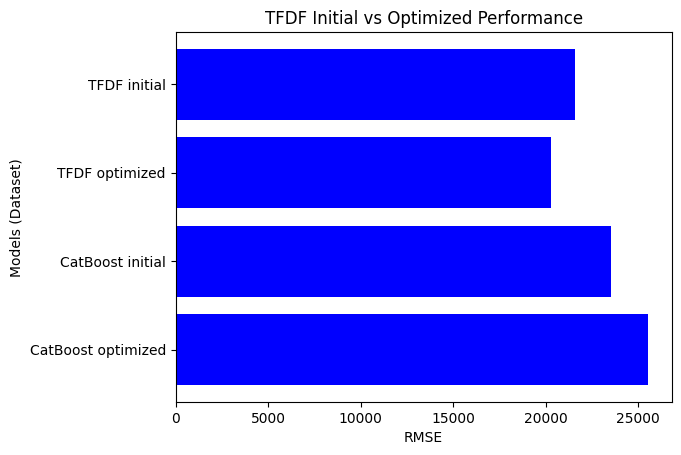

In [71]:
print(final_dict)
plot(final_dict)